# Uncertainty Estimation using TensorFlow Probability

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.layers import DenseVariational, DenseReparameterization, DenseFlipout, Convolution2DFlipout, Convolution2DReparameterization
from tensorflow_probability.python.layers import DistributionLambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
tf.compat.v1.enable_eager_execution()

import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

%matplotlib inline

print('TensorFlow version:', tf.__version__)
print('TensorFlow Probability version:', tfp.__version__)

TensorFlow version: 1.15.0-dev20190730
TensorFlow Probability version: 0.8.0-dev20190801


## Build the dataset for regression

In [2]:
def load_dataset(n, w0, b0, x_low, x_high):
    def s(x):
        g = (x - x_low) / (x_high - x_low)
        return 3 * (0.25 + g**2)
    def f(x, w, b):
        return w * x * (1. + np.sin(x)) + b
    x = (x_high - x_low) * np.random.rand(n) + x_low  # N(x_low, x_high)
    x = np.sort(x)
    eps = np.random.randn(n) * s(x)
    y = f(x, w0, b0) + eps
    return x, y

X_train.shape = (400, 1)
y_train.shape = (400, 1)
X_test.shape = (100, 1)


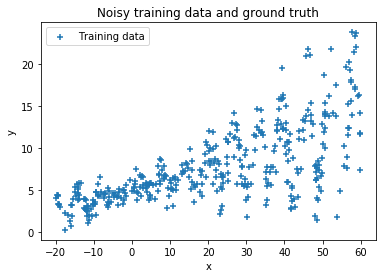

In [3]:
n_data = 500
n_train = 400
w0 = 0.125
b0 = 5.0
x_low, x_high = -20, 60

X, y = load_dataset(n_data, w0, b0, x_low, x_high)
X = np.expand_dims(X, 1)
y = np.expand_dims(y, 1)

idx_randperm = np.random.permutation(n_data)
idx_train = np.sort(idx_randperm[:n_train])
idx_test = np.sort(idx_randperm[n_train:])

X_train, y_train = X[idx_train], y[idx_train]
X_test = X[idx_test]

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)

plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Traditional point-estimate neural network

### Define the loss function of negative log-likelihood (input as prediction)

In [4]:
def neg_log_likelihood_with_dist(y_true, y_pred):
    return -tf.reduce_mean(y_pred.log_prob(y_true))

### Define and train the model

In [5]:
batch_size = 100
n_epochs = 3000
lr = 5e-3

def build_point_estimate_model(scale=1):
    model_in = Input(shape=(1,))
    x = Dense(16)(model_in)
    x = LeakyReLU(0.1)(x)
    x = Dense(64)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(16)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(1)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t, scale=scale))(x)
    model = Model(model_in, model_out)
    return model

pe_model = build_point_estimate_model()
pe_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
pe_model.summary()
hist = pe_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=2)

W0802 23:58:00.670957  7464 deprecation.py:323] From C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_core\python\keras\optimizer_v2\optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1088      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0     

Epoch 94/3000
400/400 - 0s - loss: 6.2073 - mean_squared_error: 11.9573
Epoch 95/3000
400/400 - 0s - loss: 6.2801 - mean_squared_error: 11.2105
Epoch 96/3000
400/400 - 0s - loss: 6.1764 - mean_squared_error: 11.8227
Epoch 97/3000
400/400 - 0s - loss: 6.2728 - mean_squared_error: 11.9979
Epoch 98/3000
400/400 - 0s - loss: 6.2029 - mean_squared_error: 11.3764
Epoch 99/3000
400/400 - 0s - loss: 6.2003 - mean_squared_error: 11.8315
Epoch 100/3000
400/400 - 0s - loss: 6.2121 - mean_squared_error: 12.1521
Epoch 101/3000
400/400 - 0s - loss: 6.2067 - mean_squared_error: 11.1202
Epoch 102/3000
400/400 - 0s - loss: 6.1696 - mean_squared_error: 10.7742
Epoch 103/3000
400/400 - 0s - loss: 6.1862 - mean_squared_error: 11.4048
Epoch 104/3000
400/400 - 0s - loss: 6.2038 - mean_squared_error: 11.2748
Epoch 105/3000
400/400 - 0s - loss: 6.2151 - mean_squared_error: 11.0880
Epoch 106/3000
400/400 - 0s - loss: 6.1982 - mean_squared_error: 11.8822
Epoch 107/3000
400/400 - 0s - loss: 6.1778 - mean_squared

Epoch 207/3000
400/400 - 0s - loss: 6.3255 - mean_squared_error: 12.4355
Epoch 208/3000
400/400 - 0s - loss: 6.4897 - mean_squared_error: 12.1585
Epoch 209/3000
400/400 - 0s - loss: 6.3215 - mean_squared_error: 11.7103
Epoch 210/3000
400/400 - 0s - loss: 6.2415 - mean_squared_error: 11.7077
Epoch 211/3000
400/400 - 0s - loss: 6.1652 - mean_squared_error: 11.4036
Epoch 212/3000
400/400 - 0s - loss: 6.2637 - mean_squared_error: 11.4180
Epoch 213/3000
400/400 - 0s - loss: 6.2226 - mean_squared_error: 11.2381
Epoch 214/3000
400/400 - 0s - loss: 6.2256 - mean_squared_error: 12.1998
Epoch 215/3000
400/400 - 0s - loss: 6.2822 - mean_squared_error: 11.1984
Epoch 216/3000
400/400 - 0s - loss: 6.2656 - mean_squared_error: 12.0159
Epoch 217/3000
400/400 - 0s - loss: 6.2570 - mean_squared_error: 11.9921
Epoch 218/3000
400/400 - 0s - loss: 6.2758 - mean_squared_error: 11.8996
Epoch 219/3000
400/400 - 0s - loss: 6.2550 - mean_squared_error: 11.0361
Epoch 220/3000
400/400 - 0s - loss: 6.2746 - mean_s

Epoch 320/3000
400/400 - 0s - loss: 6.3716 - mean_squared_error: 12.1455
Epoch 321/3000
400/400 - 0s - loss: 6.2582 - mean_squared_error: 11.7864
Epoch 322/3000
400/400 - 0s - loss: 6.2026 - mean_squared_error: 11.6261
Epoch 323/3000
400/400 - 0s - loss: 6.3288 - mean_squared_error: 11.7039
Epoch 324/3000
400/400 - 0s - loss: 6.4120 - mean_squared_error: 11.4043
Epoch 325/3000
400/400 - 0s - loss: 6.5095 - mean_squared_error: 11.7175
Epoch 326/3000
400/400 - 0s - loss: 6.3877 - mean_squared_error: 12.0866
Epoch 327/3000
400/400 - 0s - loss: 6.3248 - mean_squared_error: 11.3237
Epoch 328/3000
400/400 - 0s - loss: 6.3420 - mean_squared_error: 12.2123
Epoch 329/3000
400/400 - 0s - loss: 6.2538 - mean_squared_error: 11.9130
Epoch 330/3000
400/400 - 0s - loss: 6.2250 - mean_squared_error: 12.0294
Epoch 331/3000
400/400 - 0s - loss: 6.2191 - mean_squared_error: 12.3923
Epoch 332/3000
400/400 - 0s - loss: 6.2211 - mean_squared_error: 11.5114
Epoch 333/3000
400/400 - 0s - loss: 6.2433 - mean_s

Epoch 433/3000
400/400 - 0s - loss: 6.1836 - mean_squared_error: 11.5222
Epoch 434/3000
400/400 - 0s - loss: 6.2996 - mean_squared_error: 11.5642
Epoch 435/3000
400/400 - 0s - loss: 6.2009 - mean_squared_error: 11.1627
Epoch 436/3000
400/400 - 0s - loss: 6.2166 - mean_squared_error: 11.8211
Epoch 437/3000
400/400 - 0s - loss: 6.3218 - mean_squared_error: 11.6457
Epoch 438/3000
400/400 - 0s - loss: 6.4864 - mean_squared_error: 11.8541
Epoch 439/3000
400/400 - 0s - loss: 6.1469 - mean_squared_error: 11.2784
Epoch 440/3000
400/400 - 0s - loss: 6.4079 - mean_squared_error: 11.4189
Epoch 441/3000
400/400 - 0s - loss: 6.3242 - mean_squared_error: 11.6222
Epoch 442/3000
400/400 - 0s - loss: 6.2854 - mean_squared_error: 10.7583
Epoch 443/3000
400/400 - 0s - loss: 6.2628 - mean_squared_error: 11.6269
Epoch 444/3000
400/400 - 0s - loss: 6.2859 - mean_squared_error: 11.1586
Epoch 445/3000
400/400 - 0s - loss: 6.2157 - mean_squared_error: 11.5959
Epoch 446/3000
400/400 - 0s - loss: 6.4037 - mean_s

Epoch 546/3000
400/400 - 0s - loss: 6.1744 - mean_squared_error: 11.3428
Epoch 547/3000
400/400 - 0s - loss: 6.1879 - mean_squared_error: 11.4598
Epoch 548/3000
400/400 - 0s - loss: 6.1658 - mean_squared_error: 11.2319
Epoch 549/3000
400/400 - 0s - loss: 6.1770 - mean_squared_error: 11.7191
Epoch 550/3000
400/400 - 0s - loss: 6.1751 - mean_squared_error: 11.2203
Epoch 551/3000
400/400 - 0s - loss: 6.1749 - mean_squared_error: 11.2712
Epoch 552/3000
400/400 - 0s - loss: 6.1904 - mean_squared_error: 11.6721
Epoch 553/3000
400/400 - 0s - loss: 6.3055 - mean_squared_error: 11.6156
Epoch 554/3000
400/400 - 0s - loss: 6.1620 - mean_squared_error: 11.0864
Epoch 555/3000
400/400 - 0s - loss: 6.3006 - mean_squared_error: 11.8626
Epoch 556/3000
400/400 - 0s - loss: 6.1811 - mean_squared_error: 11.5171
Epoch 557/3000
400/400 - 0s - loss: 6.2065 - mean_squared_error: 11.4944
Epoch 558/3000
400/400 - 0s - loss: 6.2176 - mean_squared_error: 11.5365
Epoch 559/3000
400/400 - 0s - loss: 6.1649 - mean_s

Epoch 659/3000
400/400 - 0s - loss: 6.2894 - mean_squared_error: 11.4231
Epoch 660/3000
400/400 - 0s - loss: 6.2369 - mean_squared_error: 11.1581
Epoch 661/3000
400/400 - 0s - loss: 6.3150 - mean_squared_error: 12.1772
Epoch 662/3000
400/400 - 0s - loss: 6.3608 - mean_squared_error: 11.3806
Epoch 663/3000
400/400 - 0s - loss: 6.3444 - mean_squared_error: 11.9571
Epoch 664/3000
400/400 - 0s - loss: 6.2106 - mean_squared_error: 11.6308
Epoch 665/3000
400/400 - 0s - loss: 6.1635 - mean_squared_error: 12.0559
Epoch 666/3000
400/400 - 0s - loss: 6.2098 - mean_squared_error: 11.5568
Epoch 667/3000
400/400 - 0s - loss: 6.1375 - mean_squared_error: 11.5853
Epoch 668/3000
400/400 - 0s - loss: 6.2599 - mean_squared_error: 11.4368
Epoch 669/3000
400/400 - 0s - loss: 6.1845 - mean_squared_error: 12.1428
Epoch 670/3000
400/400 - 0s - loss: 6.1684 - mean_squared_error: 11.8790
Epoch 671/3000
400/400 - 0s - loss: 6.1742 - mean_squared_error: 11.0591
Epoch 672/3000
400/400 - 0s - loss: 6.1768 - mean_s

Epoch 772/3000
400/400 - 0s - loss: 6.1238 - mean_squared_error: 11.2042
Epoch 773/3000
400/400 - 0s - loss: 6.1930 - mean_squared_error: 11.3865
Epoch 774/3000
400/400 - 0s - loss: 6.1978 - mean_squared_error: 11.5515
Epoch 775/3000
400/400 - 0s - loss: 6.3267 - mean_squared_error: 11.9139
Epoch 776/3000
400/400 - 0s - loss: 6.2054 - mean_squared_error: 11.6818
Epoch 777/3000
400/400 - 0s - loss: 6.2572 - mean_squared_error: 11.1971
Epoch 778/3000
400/400 - 0s - loss: 6.1650 - mean_squared_error: 11.4090
Epoch 779/3000
400/400 - 0s - loss: 6.1843 - mean_squared_error: 10.9636
Epoch 780/3000
400/400 - 0s - loss: 6.1584 - mean_squared_error: 11.3347
Epoch 781/3000
400/400 - 0s - loss: 6.1285 - mean_squared_error: 11.4930
Epoch 782/3000
400/400 - 0s - loss: 6.1435 - mean_squared_error: 11.2791
Epoch 783/3000
400/400 - 0s - loss: 6.1307 - mean_squared_error: 11.5109
Epoch 784/3000
400/400 - 0s - loss: 6.1496 - mean_squared_error: 11.6413
Epoch 785/3000
400/400 - 0s - loss: 6.1504 - mean_s

Epoch 885/3000
400/400 - 0s - loss: 6.1292 - mean_squared_error: 12.0741
Epoch 886/3000
400/400 - 0s - loss: 6.1420 - mean_squared_error: 11.3699
Epoch 887/3000
400/400 - 0s - loss: 6.2104 - mean_squared_error: 11.6467
Epoch 888/3000
400/400 - 0s - loss: 6.1108 - mean_squared_error: 11.1269
Epoch 889/3000
400/400 - 0s - loss: 6.1803 - mean_squared_error: 11.4744
Epoch 890/3000
400/400 - 0s - loss: 6.1318 - mean_squared_error: 11.9403
Epoch 891/3000
400/400 - 0s - loss: 6.1321 - mean_squared_error: 10.8066
Epoch 892/3000
400/400 - 0s - loss: 6.1185 - mean_squared_error: 11.3076
Epoch 893/3000
400/400 - 0s - loss: 6.1651 - mean_squared_error: 11.6225
Epoch 894/3000
400/400 - 0s - loss: 6.1400 - mean_squared_error: 12.1918
Epoch 895/3000
400/400 - 0s - loss: 6.1435 - mean_squared_error: 11.5014
Epoch 896/3000
400/400 - 0s - loss: 6.1495 - mean_squared_error: 11.5251
Epoch 897/3000
400/400 - 0s - loss: 6.1243 - mean_squared_error: 11.8756
Epoch 898/3000
400/400 - 0s - loss: 6.1771 - mean_s

Epoch 998/3000
400/400 - 0s - loss: 6.1632 - mean_squared_error: 11.5083
Epoch 999/3000
400/400 - 0s - loss: 6.1463 - mean_squared_error: 11.2466
Epoch 1000/3000
400/400 - 0s - loss: 6.1138 - mean_squared_error: 10.8913
Epoch 1001/3000
400/400 - 0s - loss: 6.1334 - mean_squared_error: 11.3099
Epoch 1002/3000
400/400 - 0s - loss: 6.2639 - mean_squared_error: 11.6596
Epoch 1003/3000
400/400 - 0s - loss: 6.1140 - mean_squared_error: 11.3106
Epoch 1004/3000
400/400 - 0s - loss: 6.1939 - mean_squared_error: 11.4459
Epoch 1005/3000
400/400 - 0s - loss: 6.1312 - mean_squared_error: 11.2488
Epoch 1006/3000
400/400 - 0s - loss: 6.1798 - mean_squared_error: 11.1698
Epoch 1007/3000
400/400 - 0s - loss: 6.1466 - mean_squared_error: 11.6495
Epoch 1008/3000
400/400 - 0s - loss: 6.1079 - mean_squared_error: 10.4795
Epoch 1009/3000
400/400 - 0s - loss: 6.1504 - mean_squared_error: 11.4760
Epoch 1010/3000
400/400 - 0s - loss: 6.1207 - mean_squared_error: 10.9909
Epoch 1011/3000
400/400 - 0s - loss: 6.1

Epoch 1109/3000
400/400 - 0s - loss: 6.0849 - mean_squared_error: 11.3333
Epoch 1110/3000
400/400 - 0s - loss: 6.0849 - mean_squared_error: 11.4448
Epoch 1111/3000
400/400 - 0s - loss: 6.1731 - mean_squared_error: 11.7208
Epoch 1112/3000
400/400 - 0s - loss: 6.2997 - mean_squared_error: 11.2823
Epoch 1113/3000
400/400 - 0s - loss: 6.0506 - mean_squared_error: 11.2038
Epoch 1114/3000
400/400 - 0s - loss: 6.2126 - mean_squared_error: 11.5115
Epoch 1115/3000
400/400 - 0s - loss: 6.0947 - mean_squared_error: 11.5092
Epoch 1116/3000
400/400 - 0s - loss: 6.1179 - mean_squared_error: 11.1682
Epoch 1117/3000
400/400 - 0s - loss: 6.2430 - mean_squared_error: 11.9238
Epoch 1118/3000
400/400 - 0s - loss: 6.1733 - mean_squared_error: 11.0208
Epoch 1119/3000
400/400 - 0s - loss: 6.1877 - mean_squared_error: 12.0960
Epoch 1120/3000
400/400 - 0s - loss: 6.0821 - mean_squared_error: 11.5156
Epoch 1121/3000
400/400 - 0s - loss: 6.1852 - mean_squared_error: 11.9869
Epoch 1122/3000
400/400 - 0s - loss: 6

Epoch 1220/3000
400/400 - 0s - loss: 6.2165 - mean_squared_error: 11.5519
Epoch 1221/3000
400/400 - 0s - loss: 6.0372 - mean_squared_error: 11.7015
Epoch 1222/3000
400/400 - 0s - loss: 6.0952 - mean_squared_error: 11.5726
Epoch 1223/3000
400/400 - 0s - loss: 6.0862 - mean_squared_error: 11.5288
Epoch 1224/3000
400/400 - 0s - loss: 6.1460 - mean_squared_error: 10.7782
Epoch 1225/3000
400/400 - 0s - loss: 6.0501 - mean_squared_error: 10.7895
Epoch 1226/3000
400/400 - 0s - loss: 6.0695 - mean_squared_error: 11.3165
Epoch 1227/3000
400/400 - 0s - loss: 6.1103 - mean_squared_error: 11.3864
Epoch 1228/3000
400/400 - 0s - loss: 6.1109 - mean_squared_error: 11.2289
Epoch 1229/3000
400/400 - 0s - loss: 6.0719 - mean_squared_error: 10.9048
Epoch 1230/3000
400/400 - 0s - loss: 6.0678 - mean_squared_error: 10.7170
Epoch 1231/3000
400/400 - 0s - loss: 6.0779 - mean_squared_error: 10.8000
Epoch 1232/3000
400/400 - 0s - loss: 6.0414 - mean_squared_error: 10.9988
Epoch 1233/3000
400/400 - 0s - loss: 6

Epoch 1331/3000
400/400 - 0s - loss: 6.0770 - mean_squared_error: 10.8527
Epoch 1332/3000
400/400 - 0s - loss: 6.0833 - mean_squared_error: 11.8298
Epoch 1333/3000
400/400 - 0s - loss: 6.0532 - mean_squared_error: 11.0162
Epoch 1334/3000
400/400 - 0s - loss: 6.0482 - mean_squared_error: 11.0418
Epoch 1335/3000
400/400 - 0s - loss: 6.0644 - mean_squared_error: 11.3145
Epoch 1336/3000
400/400 - 0s - loss: 6.0753 - mean_squared_error: 11.1982
Epoch 1337/3000
400/400 - 0s - loss: 6.0648 - mean_squared_error: 11.2890
Epoch 1338/3000
400/400 - 0s - loss: 6.0674 - mean_squared_error: 11.5507
Epoch 1339/3000
400/400 - 0s - loss: 6.0617 - mean_squared_error: 11.3646
Epoch 1340/3000
400/400 - 0s - loss: 6.0574 - mean_squared_error: 11.9036
Epoch 1341/3000
400/400 - 0s - loss: 6.1293 - mean_squared_error: 10.8799
Epoch 1342/3000
400/400 - 0s - loss: 6.0334 - mean_squared_error: 11.2988
Epoch 1343/3000
400/400 - 0s - loss: 6.1015 - mean_squared_error: 11.5042
Epoch 1344/3000
400/400 - 0s - loss: 6

Epoch 1442/3000
400/400 - 0s - loss: 6.1524 - mean_squared_error: 11.5597
Epoch 1443/3000
400/400 - 0s - loss: 6.2350 - mean_squared_error: 11.3514
Epoch 1444/3000
400/400 - 0s - loss: 6.0255 - mean_squared_error: 11.4032
Epoch 1445/3000
400/400 - 0s - loss: 6.0952 - mean_squared_error: 11.2116
Epoch 1446/3000
400/400 - 0s - loss: 6.0188 - mean_squared_error: 11.1983
Epoch 1447/3000
400/400 - 0s - loss: 6.0318 - mean_squared_error: 11.2644
Epoch 1448/3000
400/400 - 0s - loss: 6.0022 - mean_squared_error: 10.7996
Epoch 1449/3000
400/400 - 0s - loss: 6.0189 - mean_squared_error: 11.7727
Epoch 1450/3000
400/400 - 0s - loss: 6.0066 - mean_squared_error: 11.5150
Epoch 1451/3000
400/400 - 0s - loss: 6.0563 - mean_squared_error: 11.6124
Epoch 1452/3000
400/400 - 0s - loss: 6.0199 - mean_squared_error: 11.2459
Epoch 1453/3000
400/400 - 0s - loss: 6.0937 - mean_squared_error: 11.6519
Epoch 1454/3000
400/400 - 0s - loss: 5.9894 - mean_squared_error: 11.3254
Epoch 1455/3000
400/400 - 0s - loss: 6

Epoch 1553/3000
400/400 - 0s - loss: 6.0929 - mean_squared_error: 11.4221
Epoch 1554/3000
400/400 - 0s - loss: 6.0294 - mean_squared_error: 10.7383
Epoch 1555/3000
400/400 - 0s - loss: 6.0827 - mean_squared_error: 11.6085
Epoch 1556/3000
400/400 - 0s - loss: 6.1098 - mean_squared_error: 11.7016
Epoch 1557/3000
400/400 - 0s - loss: 6.1151 - mean_squared_error: 11.7325
Epoch 1558/3000
400/400 - 0s - loss: 6.1364 - mean_squared_error: 11.0184
Epoch 1559/3000
400/400 - 0s - loss: 6.0465 - mean_squared_error: 11.6660
Epoch 1560/3000
400/400 - 0s - loss: 5.9731 - mean_squared_error: 10.4999
Epoch 1561/3000
400/400 - 0s - loss: 6.0275 - mean_squared_error: 10.9643
Epoch 1562/3000
400/400 - 0s - loss: 5.9627 - mean_squared_error: 11.3706
Epoch 1563/3000
400/400 - 0s - loss: 5.9964 - mean_squared_error: 11.1793
Epoch 1564/3000
400/400 - 0s - loss: 6.0068 - mean_squared_error: 11.0215
Epoch 1565/3000
400/400 - 0s - loss: 6.0119 - mean_squared_error: 10.9961
Epoch 1566/3000
400/400 - 0s - loss: 5

Epoch 1664/3000
400/400 - 0s - loss: 6.0436 - mean_squared_error: 11.1639
Epoch 1665/3000
400/400 - 0s - loss: 6.0902 - mean_squared_error: 11.7216
Epoch 1666/3000
400/400 - 0s - loss: 6.1679 - mean_squared_error: 11.3850
Epoch 1667/3000
400/400 - 0s - loss: 5.9040 - mean_squared_error: 11.2686
Epoch 1668/3000
400/400 - 0s - loss: 6.0658 - mean_squared_error: 11.7953
Epoch 1669/3000
400/400 - 0s - loss: 5.9957 - mean_squared_error: 11.4146
Epoch 1670/3000
400/400 - 0s - loss: 6.0548 - mean_squared_error: 11.1516
Epoch 1671/3000
400/400 - 0s - loss: 6.1025 - mean_squared_error: 10.7427
Epoch 1672/3000
400/400 - 0s - loss: 6.2472 - mean_squared_error: 11.9276
Epoch 1673/3000
400/400 - 0s - loss: 6.1768 - mean_squared_error: 11.2233
Epoch 1674/3000
400/400 - 0s - loss: 6.0473 - mean_squared_error: 11.7167
Epoch 1675/3000
400/400 - 0s - loss: 5.9680 - mean_squared_error: 10.9695
Epoch 1676/3000
400/400 - 0s - loss: 5.9770 - mean_squared_error: 10.7869
Epoch 1677/3000
400/400 - 0s - loss: 5

Epoch 1775/3000
400/400 - 0s - loss: 5.9618 - mean_squared_error: 10.8236
Epoch 1776/3000
400/400 - 0s - loss: 5.9691 - mean_squared_error: 11.4402
Epoch 1777/3000
400/400 - 0s - loss: 5.9608 - mean_squared_error: 10.8921
Epoch 1778/3000
400/400 - 0s - loss: 5.9608 - mean_squared_error: 11.1538
Epoch 1779/3000
400/400 - 0s - loss: 6.0031 - mean_squared_error: 10.7085
Epoch 1780/3000
400/400 - 0s - loss: 5.9318 - mean_squared_error: 11.3224
Epoch 1781/3000
400/400 - 0s - loss: 5.8968 - mean_squared_error: 10.5279
Epoch 1782/3000
400/400 - 0s - loss: 5.9559 - mean_squared_error: 11.0268
Epoch 1783/3000
400/400 - 0s - loss: 5.9779 - mean_squared_error: 11.3194
Epoch 1784/3000
400/400 - 0s - loss: 5.9893 - mean_squared_error: 11.2952
Epoch 1785/3000
400/400 - 0s - loss: 5.8981 - mean_squared_error: 10.5412
Epoch 1786/3000
400/400 - 0s - loss: 5.9597 - mean_squared_error: 10.5807
Epoch 1787/3000
400/400 - 0s - loss: 6.0322 - mean_squared_error: 10.7834
Epoch 1788/3000
400/400 - 0s - loss: 5

Epoch 1886/3000
400/400 - 0s - loss: 5.9199 - mean_squared_error: 10.8662
Epoch 1887/3000
400/400 - 0s - loss: 5.9337 - mean_squared_error: 11.0463
Epoch 1888/3000
400/400 - 0s - loss: 6.0225 - mean_squared_error: 10.8226
Epoch 1889/3000
400/400 - 0s - loss: 5.9893 - mean_squared_error: 11.1722
Epoch 1890/3000
400/400 - 0s - loss: 5.9244 - mean_squared_error: 10.6546
Epoch 1891/3000
400/400 - 0s - loss: 5.9500 - mean_squared_error: 11.0868
Epoch 1892/3000
400/400 - 0s - loss: 5.9160 - mean_squared_error: 11.2039
Epoch 1893/3000
400/400 - 0s - loss: 5.9102 - mean_squared_error: 10.8259
Epoch 1894/3000
400/400 - 0s - loss: 5.9386 - mean_squared_error: 11.4660
Epoch 1895/3000
400/400 - 0s - loss: 5.8871 - mean_squared_error: 11.3184
Epoch 1896/3000
400/400 - 0s - loss: 5.8612 - mean_squared_error: 11.1848
Epoch 1897/3000
400/400 - 0s - loss: 5.9178 - mean_squared_error: 11.3536
Epoch 1898/3000
400/400 - 0s - loss: 5.9156 - mean_squared_error: 10.6260
Epoch 1899/3000
400/400 - 0s - loss: 5

Epoch 1997/3000
400/400 - 0s - loss: 6.0184 - mean_squared_error: 10.9090
Epoch 1998/3000
400/400 - 0s - loss: 6.0034 - mean_squared_error: 11.4553
Epoch 1999/3000
400/400 - 0s - loss: 5.9830 - mean_squared_error: 11.4556
Epoch 2000/3000
400/400 - 0s - loss: 6.0596 - mean_squared_error: 11.7470
Epoch 2001/3000
400/400 - 0s - loss: 6.0490 - mean_squared_error: 11.3560
Epoch 2002/3000
400/400 - 0s - loss: 6.0128 - mean_squared_error: 11.2610
Epoch 2003/3000
400/400 - 0s - loss: 6.0254 - mean_squared_error: 11.6933
Epoch 2004/3000
400/400 - 0s - loss: 6.0505 - mean_squared_error: 11.4692
Epoch 2005/3000
400/400 - 0s - loss: 6.0899 - mean_squared_error: 10.8368
Epoch 2006/3000
400/400 - 0s - loss: 6.0483 - mean_squared_error: 10.9602
Epoch 2007/3000
400/400 - 0s - loss: 5.9838 - mean_squared_error: 11.0893
Epoch 2008/3000
400/400 - 0s - loss: 6.0745 - mean_squared_error: 11.0943
Epoch 2009/3000
400/400 - 0s - loss: 5.9869 - mean_squared_error: 11.1241
Epoch 2010/3000
400/400 - 0s - loss: 6

Epoch 2108/3000
400/400 - 0s - loss: 5.8793 - mean_squared_error: 11.3053
Epoch 2109/3000
400/400 - 0s - loss: 5.8844 - mean_squared_error: 10.7986
Epoch 2110/3000
400/400 - 0s - loss: 5.8999 - mean_squared_error: 11.1948
Epoch 2111/3000
400/400 - 0s - loss: 5.9066 - mean_squared_error: 10.9014
Epoch 2112/3000
400/400 - 0s - loss: 5.9118 - mean_squared_error: 11.9992
Epoch 2113/3000
400/400 - 0s - loss: 5.8840 - mean_squared_error: 11.0715
Epoch 2114/3000
400/400 - 0s - loss: 5.8442 - mean_squared_error: 10.5910
Epoch 2115/3000
400/400 - 0s - loss: 5.9078 - mean_squared_error: 10.8611
Epoch 2116/3000
400/400 - 0s - loss: 5.9070 - mean_squared_error: 11.3132
Epoch 2117/3000
400/400 - 0s - loss: 5.9356 - mean_squared_error: 10.2359
Epoch 2118/3000
400/400 - 0s - loss: 5.9050 - mean_squared_error: 11.4393
Epoch 2119/3000
400/400 - 0s - loss: 5.9009 - mean_squared_error: 10.5862
Epoch 2120/3000
400/400 - 0s - loss: 5.8710 - mean_squared_error: 11.4007
Epoch 2121/3000
400/400 - 0s - loss: 6

Epoch 2219/3000
400/400 - 0s - loss: 5.8241 - mean_squared_error: 10.7823
Epoch 2220/3000
400/400 - 0s - loss: 6.0130 - mean_squared_error: 11.2559
Epoch 2221/3000
400/400 - 0s - loss: 5.8473 - mean_squared_error: 11.0211
Epoch 2222/3000
400/400 - 0s - loss: 5.9010 - mean_squared_error: 10.9806
Epoch 2223/3000
400/400 - 0s - loss: 5.8987 - mean_squared_error: 10.6682
Epoch 2224/3000
400/400 - 0s - loss: 5.8862 - mean_squared_error: 11.0765
Epoch 2225/3000
400/400 - 0s - loss: 6.0161 - mean_squared_error: 11.0125
Epoch 2226/3000
400/400 - 0s - loss: 5.9538 - mean_squared_error: 10.6526
Epoch 2227/3000
400/400 - 0s - loss: 5.9478 - mean_squared_error: 11.1288
Epoch 2228/3000
400/400 - 0s - loss: 5.8673 - mean_squared_error: 11.1690
Epoch 2229/3000
400/400 - 0s - loss: 5.8286 - mean_squared_error: 10.8328
Epoch 2230/3000
400/400 - 0s - loss: 5.8845 - mean_squared_error: 11.4701
Epoch 2231/3000
400/400 - 0s - loss: 5.8259 - mean_squared_error: 10.7396
Epoch 2232/3000
400/400 - 0s - loss: 5

Epoch 2330/3000
400/400 - 0s - loss: 5.7853 - mean_squared_error: 11.2752
Epoch 2331/3000
400/400 - 0s - loss: 5.8449 - mean_squared_error: 11.4360
Epoch 2332/3000
400/400 - 0s - loss: 5.8213 - mean_squared_error: 10.6125
Epoch 2333/3000
400/400 - 0s - loss: 5.8136 - mean_squared_error: 10.5636
Epoch 2334/3000
400/400 - 0s - loss: 5.8851 - mean_squared_error: 11.2551
Epoch 2335/3000
400/400 - 0s - loss: 5.8842 - mean_squared_error: 10.8483
Epoch 2336/3000
400/400 - 0s - loss: 5.7860 - mean_squared_error: 10.9571
Epoch 2337/3000
400/400 - 0s - loss: 5.8597 - mean_squared_error: 10.7224
Epoch 2338/3000
400/400 - 0s - loss: 5.8182 - mean_squared_error: 10.7971
Epoch 2339/3000
400/400 - 0s - loss: 5.9348 - mean_squared_error: 11.1274
Epoch 2340/3000
400/400 - 0s - loss: 6.0472 - mean_squared_error: 11.8122
Epoch 2341/3000
400/400 - 0s - loss: 5.8334 - mean_squared_error: 10.6552
Epoch 2342/3000
400/400 - 0s - loss: 5.9048 - mean_squared_error: 10.7809
Epoch 2343/3000
400/400 - 0s - loss: 5

Epoch 2441/3000
400/400 - 0s - loss: 5.7485 - mean_squared_error: 10.3945
Epoch 2442/3000
400/400 - 0s - loss: 5.8060 - mean_squared_error: 10.7538
Epoch 2443/3000
400/400 - 0s - loss: 5.8104 - mean_squared_error: 11.0876
Epoch 2444/3000
400/400 - 0s - loss: 5.8071 - mean_squared_error: 10.8616
Epoch 2445/3000
400/400 - 0s - loss: 5.8886 - mean_squared_error: 11.3590
Epoch 2446/3000
400/400 - 0s - loss: 5.8233 - mean_squared_error: 11.0651
Epoch 2447/3000
400/400 - 0s - loss: 5.8214 - mean_squared_error: 11.2077
Epoch 2448/3000
400/400 - 0s - loss: 5.7818 - mean_squared_error: 10.3496
Epoch 2449/3000
400/400 - 0s - loss: 5.7649 - mean_squared_error: 10.1285
Epoch 2450/3000
400/400 - 0s - loss: 5.7921 - mean_squared_error: 10.7955
Epoch 2451/3000
400/400 - 0s - loss: 5.7443 - mean_squared_error: 10.3916
Epoch 2452/3000
400/400 - 0s - loss: 5.8044 - mean_squared_error: 10.9480
Epoch 2453/3000
400/400 - 0s - loss: 5.7571 - mean_squared_error: 10.2447
Epoch 2454/3000
400/400 - 0s - loss: 5

Epoch 2552/3000
400/400 - 0s - loss: 5.7670 - mean_squared_error: 11.2861
Epoch 2553/3000
400/400 - 0s - loss: 5.7328 - mean_squared_error: 10.3219
Epoch 2554/3000
400/400 - 0s - loss: 5.7383 - mean_squared_error: 10.6826
Epoch 2555/3000
400/400 - 0s - loss: 5.7660 - mean_squared_error: 10.4908
Epoch 2556/3000
400/400 - 0s - loss: 5.7313 - mean_squared_error: 10.7055
Epoch 2557/3000
400/400 - 0s - loss: 5.7330 - mean_squared_error: 10.5212
Epoch 2558/3000
400/400 - 0s - loss: 5.7183 - mean_squared_error: 10.5616
Epoch 2559/3000
400/400 - 0s - loss: 5.7399 - mean_squared_error: 10.6084
Epoch 2560/3000
400/400 - 0s - loss: 5.7617 - mean_squared_error: 11.0106
Epoch 2561/3000
400/400 - 0s - loss: 5.6768 - mean_squared_error: 10.0238
Epoch 2562/3000
400/400 - 0s - loss: 5.7477 - mean_squared_error: 11.0862
Epoch 2563/3000
400/400 - 0s - loss: 5.7191 - mean_squared_error: 10.9603
Epoch 2564/3000
400/400 - 0s - loss: 5.7692 - mean_squared_error: 11.3805
Epoch 2565/3000
400/400 - 0s - loss: 5

Epoch 2663/3000
400/400 - 0s - loss: 5.7371 - mean_squared_error: 10.6461
Epoch 2664/3000
400/400 - 0s - loss: 5.7094 - mean_squared_error: 11.1639
Epoch 2665/3000
400/400 - 0s - loss: 5.7227 - mean_squared_error: 10.4961
Epoch 2666/3000
400/400 - 0s - loss: 5.7135 - mean_squared_error: 11.0409
Epoch 2667/3000
400/400 - 0s - loss: 5.6847 - mean_squared_error: 10.1613
Epoch 2668/3000
400/400 - 0s - loss: 5.7137 - mean_squared_error: 11.3445
Epoch 2669/3000
400/400 - 0s - loss: 5.7214 - mean_squared_error: 10.2433
Epoch 2670/3000
400/400 - 0s - loss: 5.7310 - mean_squared_error: 9.8299
Epoch 2671/3000
400/400 - 0s - loss: 5.9174 - mean_squared_error: 10.9246
Epoch 2672/3000
400/400 - 0s - loss: 5.6877 - mean_squared_error: 10.7477
Epoch 2673/3000
400/400 - 0s - loss: 5.7369 - mean_squared_error: 10.7587
Epoch 2674/3000
400/400 - 0s - loss: 5.7178 - mean_squared_error: 10.5744
Epoch 2675/3000
400/400 - 0s - loss: 5.7042 - mean_squared_error: 10.0003
Epoch 2676/3000
400/400 - 0s - loss: 5.

Epoch 2774/3000
400/400 - 0s - loss: 5.8767 - mean_squared_error: 11.2954
Epoch 2775/3000
400/400 - 0s - loss: 5.6669 - mean_squared_error: 10.6138
Epoch 2776/3000
400/400 - 0s - loss: 5.7546 - mean_squared_error: 10.4859
Epoch 2777/3000
400/400 - 0s - loss: 5.7076 - mean_squared_error: 10.5241
Epoch 2778/3000
400/400 - 0s - loss: 5.7688 - mean_squared_error: 11.0574
Epoch 2779/3000
400/400 - 0s - loss: 5.6793 - mean_squared_error: 9.8577
Epoch 2780/3000
400/400 - 0s - loss: 5.7338 - mean_squared_error: 11.1707
Epoch 2781/3000
400/400 - 0s - loss: 5.7252 - mean_squared_error: 10.5567
Epoch 2782/3000
400/400 - 0s - loss: 5.6643 - mean_squared_error: 10.3018
Epoch 2783/3000
400/400 - 0s - loss: 5.7635 - mean_squared_error: 11.0485
Epoch 2784/3000
400/400 - 0s - loss: 5.7382 - mean_squared_error: 10.6911
Epoch 2785/3000
400/400 - 0s - loss: 5.6665 - mean_squared_error: 10.3922
Epoch 2786/3000
400/400 - 0s - loss: 5.6788 - mean_squared_error: 10.5341
Epoch 2787/3000
400/400 - 0s - loss: 5.

Epoch 2885/3000
400/400 - 0s - loss: 5.6659 - mean_squared_error: 10.6236
Epoch 2886/3000
400/400 - 0s - loss: 5.6880 - mean_squared_error: 10.1507
Epoch 2887/3000
400/400 - 0s - loss: 5.6463 - mean_squared_error: 10.2890
Epoch 2888/3000
400/400 - 0s - loss: 5.6883 - mean_squared_error: 10.3134
Epoch 2889/3000
400/400 - 0s - loss: 5.6540 - mean_squared_error: 10.2702
Epoch 2890/3000
400/400 - 0s - loss: 5.7956 - mean_squared_error: 10.3978
Epoch 2891/3000
400/400 - 0s - loss: 5.6813 - mean_squared_error: 10.5624
Epoch 2892/3000
400/400 - 0s - loss: 5.7703 - mean_squared_error: 10.3704
Epoch 2893/3000
400/400 - 0s - loss: 5.6696 - mean_squared_error: 10.8873
Epoch 2894/3000
400/400 - 0s - loss: 5.7025 - mean_squared_error: 10.8206
Epoch 2895/3000
400/400 - 0s - loss: 5.6686 - mean_squared_error: 10.5541
Epoch 2896/3000
400/400 - 0s - loss: 5.7085 - mean_squared_error: 10.2011
Epoch 2897/3000
400/400 - 0s - loss: 5.8250 - mean_squared_error: 10.7209
Epoch 2898/3000
400/400 - 0s - loss: 5

Epoch 2996/3000
400/400 - 0s - loss: 5.7067 - mean_squared_error: 10.6193
Epoch 2997/3000
400/400 - 0s - loss: 5.6937 - mean_squared_error: 10.6796
Epoch 2998/3000
400/400 - 0s - loss: 5.7008 - mean_squared_error: 11.0215
Epoch 2999/3000
400/400 - 0s - loss: 5.7339 - mean_squared_error: 10.3488
Epoch 3000/3000
400/400 - 0s - loss: 5.7804 - mean_squared_error: 10.4338


### Plot the training loss and predict the test data

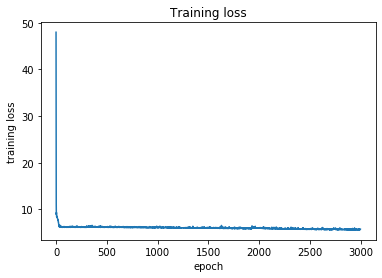

In [6]:
plt.plot(range(n_epochs), hist.history['loss'])
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('training loss')
y_test_pred_pe = pe_model(X_test)

### Plot the training and test data

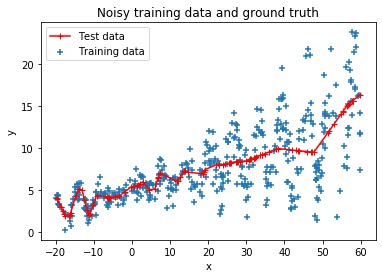

In [7]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.plot(X_test, y_test_pred_pe.mean(), 'r-', marker='+', label='Test data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Estimate aleatoric uncertainty

### Define and train the model

In [8]:
def build_aleatoric_model():
    model_in = Input(shape=(1,))
    x = Dense(16)(model_in)
    x = LeakyReLU(0.1)(x)
    x = Dense(64)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(16)(x)
    x = LeakyReLU(0.1)(x)
    x = Dense(2)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],
                                                        scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])))(x)
    model = Model(model_in, model_out)
    return model

al_model = build_aleatoric_model()
al_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
al_model.summary()
hist = al_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                32        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1088      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16)                0   

400/400 - 0s - loss: 2.3322 - mean_squared_error: 23.1880
Epoch 94/3000
400/400 - 0s - loss: 2.3285 - mean_squared_error: 19.3260
Epoch 95/3000
400/400 - 0s - loss: 2.3388 - mean_squared_error: 21.5605
Epoch 96/3000
400/400 - 0s - loss: 2.3354 - mean_squared_error: 18.2018
Epoch 97/3000
400/400 - 0s - loss: 2.3401 - mean_squared_error: 23.2464
Epoch 98/3000
400/400 - 0s - loss: 2.3335 - mean_squared_error: 22.3663
Epoch 99/3000
400/400 - 0s - loss: 2.3331 - mean_squared_error: 22.1076
Epoch 100/3000
400/400 - 0s - loss: 2.3247 - mean_squared_error: 22.5524
Epoch 101/3000
400/400 - 0s - loss: 2.3316 - mean_squared_error: 21.2387
Epoch 102/3000
400/400 - 0s - loss: 2.3458 - mean_squared_error: 22.7975
Epoch 103/3000
400/400 - 0s - loss: 2.3193 - mean_squared_error: 18.0310
Epoch 104/3000
400/400 - 0s - loss: 2.3360 - mean_squared_error: 20.9560
Epoch 105/3000
400/400 - 0s - loss: 2.3255 - mean_squared_error: 19.0321
Epoch 106/3000
400/400 - 0s - loss: 2.3328 - mean_squared_error: 21.2994

Epoch 206/3000
400/400 - 0s - loss: 2.3032 - mean_squared_error: 24.1012
Epoch 207/3000
400/400 - 0s - loss: 2.3043 - mean_squared_error: 18.5147
Epoch 208/3000
400/400 - 0s - loss: 2.3113 - mean_squared_error: 22.8965
Epoch 209/3000
400/400 - 0s - loss: 2.3150 - mean_squared_error: 22.4907
Epoch 210/3000
400/400 - 0s - loss: 2.3556 - mean_squared_error: 21.6987
Epoch 211/3000
400/400 - 0s - loss: 2.3541 - mean_squared_error: 26.4487
Epoch 212/3000
400/400 - 0s - loss: 2.3312 - mean_squared_error: 26.8613
Epoch 213/3000
400/400 - 0s - loss: 2.3178 - mean_squared_error: 19.6293
Epoch 214/3000
400/400 - 0s - loss: 2.3124 - mean_squared_error: 24.2693
Epoch 215/3000
400/400 - 0s - loss: 2.2948 - mean_squared_error: 25.8988
Epoch 216/3000
400/400 - 0s - loss: 2.3010 - mean_squared_error: 22.0219
Epoch 217/3000
400/400 - 0s - loss: 2.3064 - mean_squared_error: 24.8959
Epoch 218/3000
400/400 - 0s - loss: 2.3027 - mean_squared_error: 25.2187
Epoch 219/3000
400/400 - 0s - loss: 2.2996 - mean_s

Epoch 319/3000
400/400 - 0s - loss: 2.2546 - mean_squared_error: 21.3596
Epoch 320/3000
400/400 - 0s - loss: 2.2623 - mean_squared_error: 23.1301
Epoch 321/3000
400/400 - 0s - loss: 2.2610 - mean_squared_error: 23.2156
Epoch 322/3000
400/400 - 0s - loss: 2.2761 - mean_squared_error: 21.0718
Epoch 323/3000
400/400 - 0s - loss: 2.2760 - mean_squared_error: 19.1248
Epoch 324/3000
400/400 - 0s - loss: 2.2659 - mean_squared_error: 24.3720
Epoch 325/3000
400/400 - 0s - loss: 2.2795 - mean_squared_error: 20.5301
Epoch 326/3000
400/400 - 0s - loss: 2.2675 - mean_squared_error: 18.9644
Epoch 327/3000
400/400 - 0s - loss: 2.2583 - mean_squared_error: 19.7985
Epoch 328/3000
400/400 - 0s - loss: 2.2616 - mean_squared_error: 22.1483
Epoch 329/3000
400/400 - 0s - loss: 2.2653 - mean_squared_error: 22.9502
Epoch 330/3000
400/400 - 0s - loss: 2.2538 - mean_squared_error: 20.8055
Epoch 331/3000
400/400 - 0s - loss: 2.2731 - mean_squared_error: 23.4001
Epoch 332/3000
400/400 - 0s - loss: 2.2716 - mean_s

Epoch 432/3000
400/400 - 0s - loss: 2.2755 - mean_squared_error: 20.7073
Epoch 433/3000
400/400 - 0s - loss: 2.2809 - mean_squared_error: 22.1866
Epoch 434/3000
400/400 - 0s - loss: 2.2662 - mean_squared_error: 19.7395
Epoch 435/3000
400/400 - 0s - loss: 2.2509 - mean_squared_error: 23.1497
Epoch 436/3000
400/400 - 0s - loss: 2.2482 - mean_squared_error: 25.2523
Epoch 437/3000
400/400 - 0s - loss: 2.2500 - mean_squared_error: 19.5024
Epoch 438/3000
400/400 - 0s - loss: 2.2486 - mean_squared_error: 21.3161
Epoch 439/3000
400/400 - 0s - loss: 2.2451 - mean_squared_error: 22.3595
Epoch 440/3000
400/400 - 0s - loss: 2.2527 - mean_squared_error: 24.6650
Epoch 441/3000
400/400 - 0s - loss: 2.2545 - mean_squared_error: 20.8376
Epoch 442/3000
400/400 - 0s - loss: 2.2606 - mean_squared_error: 19.1254
Epoch 443/3000
400/400 - 0s - loss: 2.2583 - mean_squared_error: 24.1347
Epoch 444/3000
400/400 - 0s - loss: 2.2480 - mean_squared_error: 21.6459
Epoch 445/3000
400/400 - 0s - loss: 2.2635 - mean_s

Epoch 545/3000
400/400 - 0s - loss: 2.2572 - mean_squared_error: 22.9875
Epoch 546/3000
400/400 - 0s - loss: 2.2628 - mean_squared_error: 19.6407
Epoch 547/3000
400/400 - 0s - loss: 2.2576 - mean_squared_error: 22.3377
Epoch 548/3000
400/400 - 0s - loss: 2.2618 - mean_squared_error: 22.7183
Epoch 549/3000
400/400 - 0s - loss: 2.2536 - mean_squared_error: 21.3972
Epoch 550/3000
400/400 - 0s - loss: 2.2466 - mean_squared_error: 22.8524
Epoch 551/3000
400/400 - 0s - loss: 2.2502 - mean_squared_error: 18.9902
Epoch 552/3000
400/400 - 0s - loss: 2.2547 - mean_squared_error: 19.6554
Epoch 553/3000
400/400 - 0s - loss: 2.2436 - mean_squared_error: 21.8079
Epoch 554/3000
400/400 - 0s - loss: 2.2618 - mean_squared_error: 23.2655
Epoch 555/3000
400/400 - 0s - loss: 2.2543 - mean_squared_error: 22.7483
Epoch 556/3000
400/400 - 0s - loss: 2.2426 - mean_squared_error: 20.1576
Epoch 557/3000
400/400 - 0s - loss: 2.2455 - mean_squared_error: 17.5792
Epoch 558/3000
400/400 - 0s - loss: 2.2711 - mean_s

Epoch 658/3000
400/400 - 0s - loss: 2.2496 - mean_squared_error: 22.3645
Epoch 659/3000
400/400 - 0s - loss: 2.2447 - mean_squared_error: 23.8111
Epoch 660/3000
400/400 - 0s - loss: 2.2398 - mean_squared_error: 22.1533
Epoch 661/3000
400/400 - 0s - loss: 2.2472 - mean_squared_error: 24.5795
Epoch 662/3000
400/400 - 0s - loss: 2.2416 - mean_squared_error: 21.5683
Epoch 663/3000
400/400 - 0s - loss: 2.2423 - mean_squared_error: 22.5772
Epoch 664/3000
400/400 - 0s - loss: 2.2462 - mean_squared_error: 20.5129
Epoch 665/3000
400/400 - 0s - loss: 2.2422 - mean_squared_error: 23.8169
Epoch 666/3000
400/400 - 0s - loss: 2.2383 - mean_squared_error: 18.6494
Epoch 667/3000
400/400 - 0s - loss: 2.2427 - mean_squared_error: 21.0717
Epoch 668/3000
400/400 - 0s - loss: 2.2380 - mean_squared_error: 22.5367
Epoch 669/3000
400/400 - 0s - loss: 2.2438 - mean_squared_error: 20.8152
Epoch 670/3000
400/400 - 0s - loss: 2.2424 - mean_squared_error: 20.6276
Epoch 671/3000
400/400 - 0s - loss: 2.2406 - mean_s

Epoch 771/3000
400/400 - 0s - loss: 2.2431 - mean_squared_error: 22.2994
Epoch 772/3000
400/400 - 0s - loss: 2.2402 - mean_squared_error: 19.1868
Epoch 773/3000
400/400 - 0s - loss: 2.2446 - mean_squared_error: 23.3807
Epoch 774/3000
400/400 - 0s - loss: 2.2487 - mean_squared_error: 19.6604
Epoch 775/3000
400/400 - 0s - loss: 2.2520 - mean_squared_error: 23.2229
Epoch 776/3000
400/400 - 0s - loss: 2.2597 - mean_squared_error: 20.7832
Epoch 777/3000
400/400 - 0s - loss: 2.2428 - mean_squared_error: 22.4768
Epoch 778/3000
400/400 - 0s - loss: 2.2424 - mean_squared_error: 20.4358
Epoch 779/3000
400/400 - 0s - loss: 2.2394 - mean_squared_error: 21.6347
Epoch 780/3000
400/400 - 0s - loss: 2.2715 - mean_squared_error: 25.4961
Epoch 781/3000
400/400 - 0s - loss: 2.2584 - mean_squared_error: 23.0305
Epoch 782/3000
400/400 - 0s - loss: 2.2434 - mean_squared_error: 22.3698
Epoch 783/3000
400/400 - 0s - loss: 2.2397 - mean_squared_error: 19.3426
Epoch 784/3000
400/400 - 0s - loss: 2.2372 - mean_s

Epoch 884/3000
400/400 - 0s - loss: 2.2385 - mean_squared_error: 21.1336
Epoch 885/3000
400/400 - 0s - loss: 2.2336 - mean_squared_error: 22.6869
Epoch 886/3000
400/400 - 0s - loss: 2.2340 - mean_squared_error: 18.7119
Epoch 887/3000
400/400 - 0s - loss: 2.2328 - mean_squared_error: 18.8259
Epoch 888/3000
400/400 - 0s - loss: 2.2440 - mean_squared_error: 20.2488
Epoch 889/3000
400/400 - 0s - loss: 2.2353 - mean_squared_error: 25.7650
Epoch 890/3000
400/400 - 0s - loss: 2.2325 - mean_squared_error: 23.2779
Epoch 891/3000
400/400 - 0s - loss: 2.2369 - mean_squared_error: 21.1717
Epoch 892/3000
400/400 - 0s - loss: 2.2404 - mean_squared_error: 20.6954
Epoch 893/3000
400/400 - 0s - loss: 2.2442 - mean_squared_error: 20.8029
Epoch 894/3000
400/400 - 0s - loss: 2.2359 - mean_squared_error: 21.6589
Epoch 895/3000
400/400 - 0s - loss: 2.2497 - mean_squared_error: 20.7825
Epoch 896/3000
400/400 - 0s - loss: 2.2356 - mean_squared_error: 23.3083
Epoch 897/3000
400/400 - 0s - loss: 2.2370 - mean_s

Epoch 997/3000
400/400 - 0s - loss: 2.2467 - mean_squared_error: 22.4327
Epoch 998/3000
400/400 - 0s - loss: 2.2642 - mean_squared_error: 26.8016
Epoch 999/3000
400/400 - 0s - loss: 2.2546 - mean_squared_error: 26.7323
Epoch 1000/3000
400/400 - 0s - loss: 2.2609 - mean_squared_error: 22.9749
Epoch 1001/3000
400/400 - 0s - loss: 2.2476 - mean_squared_error: 24.2858
Epoch 1002/3000
400/400 - 0s - loss: 2.2470 - mean_squared_error: 25.1721
Epoch 1003/3000
400/400 - 0s - loss: 2.2419 - mean_squared_error: 24.1033
Epoch 1004/3000
400/400 - 0s - loss: 2.2305 - mean_squared_error: 18.8188
Epoch 1005/3000
400/400 - 0s - loss: 2.2343 - mean_squared_error: 21.1511
Epoch 1006/3000
400/400 - 0s - loss: 2.2358 - mean_squared_error: 19.8835
Epoch 1007/3000
400/400 - 0s - loss: 2.2359 - mean_squared_error: 19.4994
Epoch 1008/3000
400/400 - 0s - loss: 2.2409 - mean_squared_error: 22.5046
Epoch 1009/3000
400/400 - 0s - loss: 2.2363 - mean_squared_error: 19.9248
Epoch 1010/3000
400/400 - 0s - loss: 2.25

Epoch 1108/3000
400/400 - 0s - loss: 2.2262 - mean_squared_error: 22.4507
Epoch 1109/3000
400/400 - 0s - loss: 2.2297 - mean_squared_error: 22.4113
Epoch 1110/3000
400/400 - 0s - loss: 2.2279 - mean_squared_error: 19.5512
Epoch 1111/3000
400/400 - 0s - loss: 2.2294 - mean_squared_error: 20.3804
Epoch 1112/3000
400/400 - 0s - loss: 2.2304 - mean_squared_error: 19.3071
Epoch 1113/3000
400/400 - 0s - loss: 2.2375 - mean_squared_error: 19.4748
Epoch 1114/3000
400/400 - 0s - loss: 2.2275 - mean_squared_error: 22.5128
Epoch 1115/3000
400/400 - 0s - loss: 2.2245 - mean_squared_error: 20.0575
Epoch 1116/3000
400/400 - 0s - loss: 2.2296 - mean_squared_error: 22.2643
Epoch 1117/3000
400/400 - 0s - loss: 2.2254 - mean_squared_error: 20.7865
Epoch 1118/3000
400/400 - 0s - loss: 2.2294 - mean_squared_error: 20.5454
Epoch 1119/3000
400/400 - 0s - loss: 2.2241 - mean_squared_error: 22.3625
Epoch 1120/3000
400/400 - 0s - loss: 2.2348 - mean_squared_error: 19.9018
Epoch 1121/3000
400/400 - 0s - loss: 2

Epoch 1219/3000
400/400 - 0s - loss: 2.2261 - mean_squared_error: 21.7800
Epoch 1220/3000
400/400 - 0s - loss: 2.2295 - mean_squared_error: 22.0143
Epoch 1221/3000
400/400 - 0s - loss: 2.2232 - mean_squared_error: 20.2655
Epoch 1222/3000
400/400 - 0s - loss: 2.2263 - mean_squared_error: 22.0989
Epoch 1223/3000
400/400 - 0s - loss: 2.2293 - mean_squared_error: 20.7222
Epoch 1224/3000
400/400 - 0s - loss: 2.2297 - mean_squared_error: 20.3672
Epoch 1225/3000
400/400 - 0s - loss: 2.2380 - mean_squared_error: 21.7090
Epoch 1226/3000
400/400 - 0s - loss: 2.2280 - mean_squared_error: 21.0086
Epoch 1227/3000
400/400 - 0s - loss: 2.2342 - mean_squared_error: 21.1901
Epoch 1228/3000
400/400 - 0s - loss: 2.2241 - mean_squared_error: 19.2084
Epoch 1229/3000
400/400 - 0s - loss: 2.2316 - mean_squared_error: 20.0061
Epoch 1230/3000
400/400 - 0s - loss: 2.2275 - mean_squared_error: 20.6864
Epoch 1231/3000
400/400 - 0s - loss: 2.2374 - mean_squared_error: 20.7413
Epoch 1232/3000
400/400 - 0s - loss: 2

Epoch 1330/3000
400/400 - 0s - loss: 2.2237 - mean_squared_error: 19.2733
Epoch 1331/3000
400/400 - 0s - loss: 2.2470 - mean_squared_error: 22.1267
Epoch 1332/3000
400/400 - 0s - loss: 2.2322 - mean_squared_error: 22.0935
Epoch 1333/3000
400/400 - 0s - loss: 2.2234 - mean_squared_error: 20.7048
Epoch 1334/3000
400/400 - 0s - loss: 2.2262 - mean_squared_error: 23.0418
Epoch 1335/3000
400/400 - 0s - loss: 2.2264 - mean_squared_error: 20.7993
Epoch 1336/3000
400/400 - 0s - loss: 2.2316 - mean_squared_error: 18.8457
Epoch 1337/3000
400/400 - 0s - loss: 2.2478 - mean_squared_error: 20.4485
Epoch 1338/3000
400/400 - 0s - loss: 2.2318 - mean_squared_error: 21.7327
Epoch 1339/3000
400/400 - 0s - loss: 2.2202 - mean_squared_error: 24.5007
Epoch 1340/3000
400/400 - 0s - loss: 2.2345 - mean_squared_error: 22.1094
Epoch 1341/3000
400/400 - 0s - loss: 2.2375 - mean_squared_error: 22.6252
Epoch 1342/3000
400/400 - 0s - loss: 2.2310 - mean_squared_error: 21.6827
Epoch 1343/3000
400/400 - 0s - loss: 2

Epoch 1441/3000
400/400 - 0s - loss: 2.2512 - mean_squared_error: 26.1694
Epoch 1442/3000
400/400 - 0s - loss: 2.2268 - mean_squared_error: 23.9806
Epoch 1443/3000
400/400 - 0s - loss: 2.2232 - mean_squared_error: 22.0974
Epoch 1444/3000
400/400 - 0s - loss: 2.2281 - mean_squared_error: 20.4796
Epoch 1445/3000
400/400 - 0s - loss: 2.2346 - mean_squared_error: 19.9841
Epoch 1446/3000
400/400 - 0s - loss: 2.2558 - mean_squared_error: 23.1084
Epoch 1447/3000
400/400 - 0s - loss: 2.2450 - mean_squared_error: 22.3510
Epoch 1448/3000
400/400 - 0s - loss: 2.2193 - mean_squared_error: 21.3988
Epoch 1449/3000
400/400 - 0s - loss: 2.2276 - mean_squared_error: 21.2372
Epoch 1450/3000
400/400 - 0s - loss: 2.2347 - mean_squared_error: 20.9477
Epoch 1451/3000
400/400 - 0s - loss: 2.2350 - mean_squared_error: 22.6065
Epoch 1452/3000
400/400 - 0s - loss: 2.2347 - mean_squared_error: 24.7964
Epoch 1453/3000
400/400 - 0s - loss: 2.2230 - mean_squared_error: 22.3831
Epoch 1454/3000
400/400 - 0s - loss: 2

Epoch 1552/3000
400/400 - 0s - loss: 2.2238 - mean_squared_error: 19.0416
Epoch 1553/3000
400/400 - 0s - loss: 2.2308 - mean_squared_error: 22.2250
Epoch 1554/3000
400/400 - 0s - loss: 2.2319 - mean_squared_error: 19.7780
Epoch 1555/3000
400/400 - 0s - loss: 2.2379 - mean_squared_error: 21.8781
Epoch 1556/3000
400/400 - 0s - loss: 2.2407 - mean_squared_error: 17.3294
Epoch 1557/3000
400/400 - 0s - loss: 2.2364 - mean_squared_error: 19.4509
Epoch 1558/3000
400/400 - 0s - loss: 2.2159 - mean_squared_error: 22.0148
Epoch 1559/3000
400/400 - 0s - loss: 2.2412 - mean_squared_error: 19.2720
Epoch 1560/3000
400/400 - 0s - loss: 2.2328 - mean_squared_error: 20.8907
Epoch 1561/3000
400/400 - 0s - loss: 2.2330 - mean_squared_error: 23.4079
Epoch 1562/3000
400/400 - 0s - loss: 2.2203 - mean_squared_error: 20.6440
Epoch 1563/3000
400/400 - 0s - loss: 2.2225 - mean_squared_error: 19.9866
Epoch 1564/3000
400/400 - 0s - loss: 2.2256 - mean_squared_error: 19.1788
Epoch 1565/3000
400/400 - 0s - loss: 2

Epoch 1663/3000
400/400 - 0s - loss: 2.2257 - mean_squared_error: 20.7915
Epoch 1664/3000
400/400 - 0s - loss: 2.2228 - mean_squared_error: 18.5044
Epoch 1665/3000
400/400 - 0s - loss: 2.2216 - mean_squared_error: 20.9892
Epoch 1666/3000
400/400 - 0s - loss: 2.2182 - mean_squared_error: 19.3386
Epoch 1667/3000
400/400 - 0s - loss: 2.2184 - mean_squared_error: 19.1847
Epoch 1668/3000
400/400 - 0s - loss: 2.2178 - mean_squared_error: 21.4731
Epoch 1669/3000
400/400 - 0s - loss: 2.2222 - mean_squared_error: 23.3239
Epoch 1670/3000
400/400 - 0s - loss: 2.2220 - mean_squared_error: 23.7935
Epoch 1671/3000
400/400 - 0s - loss: 2.2190 - mean_squared_error: 20.4564
Epoch 1672/3000
400/400 - 0s - loss: 2.2288 - mean_squared_error: 25.6326
Epoch 1673/3000
400/400 - 0s - loss: 2.2168 - mean_squared_error: 16.0855
Epoch 1674/3000
400/400 - 0s - loss: 2.2234 - mean_squared_error: 20.3806
Epoch 1675/3000
400/400 - 0s - loss: 2.2293 - mean_squared_error: 19.7625
Epoch 1676/3000
400/400 - 0s - loss: 2

Epoch 1774/3000
400/400 - 0s - loss: 2.2288 - mean_squared_error: 20.3784
Epoch 1775/3000
400/400 - 0s - loss: 2.2411 - mean_squared_error: 21.5913
Epoch 1776/3000
400/400 - 0s - loss: 2.2300 - mean_squared_error: 21.3149
Epoch 1777/3000
400/400 - 0s - loss: 2.2460 - mean_squared_error: 22.6896
Epoch 1778/3000
400/400 - 0s - loss: 2.2174 - mean_squared_error: 22.0526
Epoch 1779/3000
400/400 - 0s - loss: 2.2345 - mean_squared_error: 22.7184
Epoch 1780/3000
400/400 - 0s - loss: 2.2464 - mean_squared_error: 19.7023
Epoch 1781/3000
400/400 - 0s - loss: 2.2275 - mean_squared_error: 24.9725
Epoch 1782/3000
400/400 - 0s - loss: 2.2522 - mean_squared_error: 22.6846
Epoch 1783/3000
400/400 - 0s - loss: 2.2353 - mean_squared_error: 24.4224
Epoch 1784/3000
400/400 - 0s - loss: 2.2235 - mean_squared_error: 22.4279
Epoch 1785/3000
400/400 - 0s - loss: 2.2266 - mean_squared_error: 22.9469
Epoch 1786/3000
400/400 - 0s - loss: 2.2350 - mean_squared_error: 22.3831
Epoch 1787/3000
400/400 - 0s - loss: 2

Epoch 1885/3000
400/400 - 0s - loss: 2.2125 - mean_squared_error: 23.5873
Epoch 1886/3000
400/400 - 0s - loss: 2.2072 - mean_squared_error: 20.8663
Epoch 1887/3000
400/400 - 0s - loss: 2.2231 - mean_squared_error: 22.1770
Epoch 1888/3000
400/400 - 0s - loss: 2.2197 - mean_squared_error: 15.4979
Epoch 1889/3000
400/400 - 0s - loss: 2.2152 - mean_squared_error: 21.5527
Epoch 1890/3000
400/400 - 0s - loss: 2.2082 - mean_squared_error: 18.4168
Epoch 1891/3000
400/400 - 0s - loss: 2.2064 - mean_squared_error: 20.4440
Epoch 1892/3000
400/400 - 0s - loss: 2.2070 - mean_squared_error: 19.4277
Epoch 1893/3000
400/400 - 0s - loss: 2.2216 - mean_squared_error: 22.8480
Epoch 1894/3000
400/400 - 0s - loss: 2.2203 - mean_squared_error: 18.8954
Epoch 1895/3000
400/400 - 0s - loss: 2.2206 - mean_squared_error: 20.8612
Epoch 1896/3000
400/400 - 0s - loss: 2.2157 - mean_squared_error: 19.0096
Epoch 1897/3000
400/400 - 0s - loss: 2.2161 - mean_squared_error: 21.7926
Epoch 1898/3000
400/400 - 0s - loss: 2

Epoch 1996/3000
400/400 - 0s - loss: 2.2095 - mean_squared_error: 23.3807
Epoch 1997/3000
400/400 - 0s - loss: 2.1988 - mean_squared_error: 21.8688
Epoch 1998/3000
400/400 - 0s - loss: 2.2022 - mean_squared_error: 21.3865
Epoch 1999/3000
400/400 - 0s - loss: 2.2001 - mean_squared_error: 18.2205
Epoch 2000/3000
400/400 - 0s - loss: 2.2150 - mean_squared_error: 20.5485
Epoch 2001/3000
400/400 - 0s - loss: 2.2094 - mean_squared_error: 18.3080
Epoch 2002/3000
400/400 - 0s - loss: 2.2139 - mean_squared_error: 24.2891
Epoch 2003/3000
400/400 - 0s - loss: 2.2115 - mean_squared_error: 20.3442
Epoch 2004/3000
400/400 - 0s - loss: 2.2182 - mean_squared_error: 20.2148
Epoch 2005/3000
400/400 - 0s - loss: 2.2076 - mean_squared_error: 22.9250
Epoch 2006/3000
400/400 - 0s - loss: 2.2133 - mean_squared_error: 22.0458
Epoch 2007/3000
400/400 - 0s - loss: 2.2103 - mean_squared_error: 18.7980
Epoch 2008/3000
400/400 - 0s - loss: 2.1997 - mean_squared_error: 19.8120
Epoch 2009/3000
400/400 - 0s - loss: 2

Epoch 2107/3000
400/400 - 0s - loss: 2.1860 - mean_squared_error: 24.7577
Epoch 2108/3000
400/400 - 0s - loss: 2.1879 - mean_squared_error: 20.7721
Epoch 2109/3000
400/400 - 0s - loss: 2.1850 - mean_squared_error: 21.0568
Epoch 2110/3000
400/400 - 0s - loss: 2.1897 - mean_squared_error: 17.7156
Epoch 2111/3000
400/400 - 0s - loss: 2.1845 - mean_squared_error: 22.4855
Epoch 2112/3000
400/400 - 0s - loss: 2.1937 - mean_squared_error: 20.6659
Epoch 2113/3000
400/400 - 0s - loss: 2.1796 - mean_squared_error: 18.7437
Epoch 2114/3000
400/400 - 0s - loss: 2.1864 - mean_squared_error: 20.0811
Epoch 2115/3000
400/400 - 0s - loss: 2.1958 - mean_squared_error: 21.4685
Epoch 2116/3000
400/400 - 0s - loss: 2.1937 - mean_squared_error: 22.8710
Epoch 2117/3000
400/400 - 0s - loss: 2.1918 - mean_squared_error: 19.6693
Epoch 2118/3000
400/400 - 0s - loss: 2.1869 - mean_squared_error: 20.6640
Epoch 2119/3000
400/400 - 0s - loss: 2.1916 - mean_squared_error: 19.3527
Epoch 2120/3000
400/400 - 0s - loss: 2

Epoch 2218/3000
400/400 - 0s - loss: 2.2114 - mean_squared_error: 21.1597
Epoch 2219/3000
400/400 - 0s - loss: 2.1845 - mean_squared_error: 21.0779
Epoch 2220/3000
400/400 - 0s - loss: 2.2021 - mean_squared_error: 21.3171
Epoch 2221/3000
400/400 - 0s - loss: 2.1708 - mean_squared_error: 22.4914
Epoch 2222/3000
400/400 - 0s - loss: 2.1847 - mean_squared_error: 21.7866
Epoch 2223/3000
400/400 - 0s - loss: 2.1750 - mean_squared_error: 19.6649
Epoch 2224/3000
400/400 - 0s - loss: 2.1882 - mean_squared_error: 20.1528
Epoch 2225/3000
400/400 - 0s - loss: 2.1847 - mean_squared_error: 26.4923
Epoch 2226/3000
400/400 - 0s - loss: 2.1673 - mean_squared_error: 17.0822
Epoch 2227/3000
400/400 - 0s - loss: 2.1827 - mean_squared_error: 22.0203
Epoch 2228/3000
400/400 - 0s - loss: 2.1833 - mean_squared_error: 19.6700
Epoch 2229/3000
400/400 - 0s - loss: 2.1882 - mean_squared_error: 22.1631
Epoch 2230/3000
400/400 - 0s - loss: 2.1734 - mean_squared_error: 21.2720
Epoch 2231/3000
400/400 - 0s - loss: 2

Epoch 2329/3000
400/400 - 0s - loss: 2.1685 - mean_squared_error: 23.8139
Epoch 2330/3000
400/400 - 0s - loss: 2.1586 - mean_squared_error: 19.0403
Epoch 2331/3000
400/400 - 0s - loss: 2.1620 - mean_squared_error: 21.2563
Epoch 2332/3000
400/400 - 0s - loss: 2.1600 - mean_squared_error: 21.9562
Epoch 2333/3000
400/400 - 0s - loss: 2.1569 - mean_squared_error: 20.8848
Epoch 2334/3000
400/400 - 0s - loss: 2.1788 - mean_squared_error: 22.7056
Epoch 2335/3000
400/400 - 0s - loss: 2.1778 - mean_squared_error: 23.8905
Epoch 2336/3000
400/400 - 0s - loss: 2.1797 - mean_squared_error: 22.8037
Epoch 2337/3000
400/400 - 0s - loss: 2.1588 - mean_squared_error: 19.9972
Epoch 2338/3000
400/400 - 0s - loss: 2.1632 - mean_squared_error: 17.5500
Epoch 2339/3000
400/400 - 0s - loss: 2.1806 - mean_squared_error: 22.0665
Epoch 2340/3000
400/400 - 0s - loss: 2.1807 - mean_squared_error: 21.8498
Epoch 2341/3000
400/400 - 0s - loss: 2.1733 - mean_squared_error: 19.7356
Epoch 2342/3000
400/400 - 0s - loss: 2

Epoch 2440/3000
400/400 - 0s - loss: 2.1389 - mean_squared_error: 22.7800
Epoch 2441/3000
400/400 - 0s - loss: 2.1447 - mean_squared_error: 22.8525
Epoch 2442/3000
400/400 - 0s - loss: 2.1364 - mean_squared_error: 23.7369
Epoch 2443/3000
400/400 - 0s - loss: 2.1462 - mean_squared_error: 21.1652
Epoch 2444/3000
400/400 - 0s - loss: 2.1635 - mean_squared_error: 20.5657
Epoch 2445/3000
400/400 - 0s - loss: 2.1853 - mean_squared_error: 25.3429
Epoch 2446/3000
400/400 - 0s - loss: 2.1585 - mean_squared_error: 22.9836
Epoch 2447/3000
400/400 - 0s - loss: 2.1498 - mean_squared_error: 22.2759
Epoch 2448/3000
400/400 - 0s - loss: 2.1556 - mean_squared_error: 21.1972
Epoch 2449/3000
400/400 - 0s - loss: 2.1713 - mean_squared_error: 20.0839
Epoch 2450/3000
400/400 - 0s - loss: 2.1585 - mean_squared_error: 22.8335
Epoch 2451/3000
400/400 - 0s - loss: 2.1723 - mean_squared_error: 18.8051
Epoch 2452/3000
400/400 - 0s - loss: 2.1614 - mean_squared_error: 21.0787
Epoch 2453/3000
400/400 - 0s - loss: 2

Epoch 2551/3000
400/400 - 0s - loss: 2.1284 - mean_squared_error: 22.2158
Epoch 2552/3000
400/400 - 0s - loss: 2.1330 - mean_squared_error: 22.1846
Epoch 2553/3000
400/400 - 0s - loss: 2.1492 - mean_squared_error: 22.3354
Epoch 2554/3000
400/400 - 0s - loss: 2.1244 - mean_squared_error: 20.8625
Epoch 2555/3000
400/400 - 0s - loss: 2.1329 - mean_squared_error: 23.1741
Epoch 2556/3000
400/400 - 0s - loss: 2.1437 - mean_squared_error: 18.5305
Epoch 2557/3000
400/400 - 0s - loss: 2.1734 - mean_squared_error: 20.1292
Epoch 2558/3000
400/400 - 0s - loss: 2.1654 - mean_squared_error: 21.1267
Epoch 2559/3000
400/400 - 0s - loss: 2.1400 - mean_squared_error: 25.7978
Epoch 2560/3000
400/400 - 0s - loss: 2.1215 - mean_squared_error: 21.6021
Epoch 2561/3000
400/400 - 0s - loss: 2.1338 - mean_squared_error: 22.9046
Epoch 2562/3000
400/400 - 0s - loss: 2.1268 - mean_squared_error: 22.8469
Epoch 2563/3000
400/400 - 0s - loss: 2.1326 - mean_squared_error: 19.8255
Epoch 2564/3000
400/400 - 0s - loss: 2

Epoch 2662/3000
400/400 - 0s - loss: 2.1271 - mean_squared_error: 22.9145
Epoch 2663/3000
400/400 - 0s - loss: 2.1179 - mean_squared_error: 20.0464
Epoch 2664/3000
400/400 - 0s - loss: 2.1214 - mean_squared_error: 18.8048
Epoch 2665/3000
400/400 - 0s - loss: 2.1146 - mean_squared_error: 22.9114
Epoch 2666/3000
400/400 - 0s - loss: 2.1146 - mean_squared_error: 20.2570
Epoch 2667/3000
400/400 - 0s - loss: 2.1222 - mean_squared_error: 21.1341
Epoch 2668/3000
400/400 - 0s - loss: 2.1198 - mean_squared_error: 21.7558
Epoch 2669/3000
400/400 - 0s - loss: 2.1116 - mean_squared_error: 19.3180
Epoch 2670/3000
400/400 - 0s - loss: 2.1226 - mean_squared_error: 21.8790
Epoch 2671/3000
400/400 - 0s - loss: 2.1266 - mean_squared_error: 21.4143
Epoch 2672/3000
400/400 - 0s - loss: 2.1203 - mean_squared_error: 19.2741
Epoch 2673/3000
400/400 - 0s - loss: 2.1263 - mean_squared_error: 23.7426
Epoch 2674/3000
400/400 - 0s - loss: 2.1328 - mean_squared_error: 20.3554
Epoch 2675/3000
400/400 - 0s - loss: 2

Epoch 2773/3000
400/400 - 0s - loss: 2.1181 - mean_squared_error: 21.4708
Epoch 2774/3000
400/400 - 0s - loss: 2.1214 - mean_squared_error: 19.8259
Epoch 2775/3000
400/400 - 0s - loss: 2.1347 - mean_squared_error: 20.6480
Epoch 2776/3000
400/400 - 0s - loss: 2.1258 - mean_squared_error: 20.0078
Epoch 2777/3000
400/400 - 0s - loss: 2.1131 - mean_squared_error: 21.4441
Epoch 2778/3000
400/400 - 0s - loss: 2.1198 - mean_squared_error: 24.2830
Epoch 2779/3000
400/400 - 0s - loss: 2.1095 - mean_squared_error: 22.1433
Epoch 2780/3000
400/400 - 0s - loss: 2.1209 - mean_squared_error: 20.9810
Epoch 2781/3000
400/400 - 0s - loss: 2.1050 - mean_squared_error: 23.2301
Epoch 2782/3000
400/400 - 0s - loss: 2.1136 - mean_squared_error: 20.6181
Epoch 2783/3000
400/400 - 0s - loss: 2.1497 - mean_squared_error: 22.0503
Epoch 2784/3000
400/400 - 0s - loss: 2.1260 - mean_squared_error: 19.5041
Epoch 2785/3000
400/400 - 0s - loss: 2.1230 - mean_squared_error: 22.4299
Epoch 2786/3000
400/400 - 0s - loss: 2

Epoch 2884/3000
400/400 - 0s - loss: 2.1016 - mean_squared_error: 18.6929
Epoch 2885/3000
400/400 - 0s - loss: 2.1059 - mean_squared_error: 23.2875
Epoch 2886/3000
400/400 - 0s - loss: 2.0976 - mean_squared_error: 19.6215
Epoch 2887/3000
400/400 - 0s - loss: 2.1054 - mean_squared_error: 22.7947
Epoch 2888/3000
400/400 - 0s - loss: 2.1049 - mean_squared_error: 15.2865
Epoch 2889/3000
400/400 - 0s - loss: 2.1226 - mean_squared_error: 20.1250
Epoch 2890/3000
400/400 - 0s - loss: 2.1316 - mean_squared_error: 19.2004
Epoch 2891/3000
400/400 - 0s - loss: 2.1253 - mean_squared_error: 24.8122
Epoch 2892/3000
400/400 - 0s - loss: 2.1003 - mean_squared_error: 22.1971
Epoch 2893/3000
400/400 - 0s - loss: 2.1147 - mean_squared_error: 19.2741
Epoch 2894/3000
400/400 - 0s - loss: 2.1026 - mean_squared_error: 20.5077
Epoch 2895/3000
400/400 - 0s - loss: 2.1145 - mean_squared_error: 23.8265
Epoch 2896/3000
400/400 - 0s - loss: 2.1239 - mean_squared_error: 23.2191
Epoch 2897/3000
400/400 - 0s - loss: 2

Epoch 2995/3000
400/400 - 0s - loss: 2.1265 - mean_squared_error: 24.4537
Epoch 2996/3000
400/400 - 0s - loss: 2.1197 - mean_squared_error: 20.9300
Epoch 2997/3000
400/400 - 0s - loss: 2.1250 - mean_squared_error: 23.9353
Epoch 2998/3000
400/400 - 0s - loss: 2.1221 - mean_squared_error: 18.1747
Epoch 2999/3000
400/400 - 0s - loss: 2.1401 - mean_squared_error: 23.8150
Epoch 3000/3000
400/400 - 0s - loss: 2.1485 - mean_squared_error: 21.1627


### Plot the training loss and predict the test data

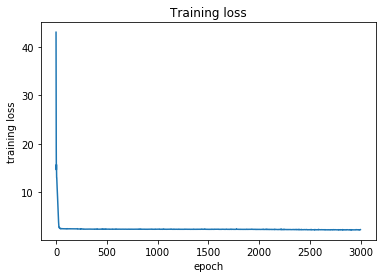

In [9]:
plt.plot(range(n_epochs), hist.history['loss'])
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('training loss')
y_test_pred_al = al_model(X_test)
y_test_pred_al_mean = y_test_pred_al.mean()
y_test_pred_al_stddev = y_test_pred_al.stddev()

### Plot the training and test data

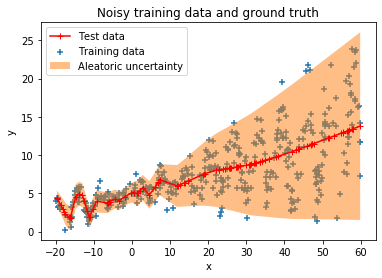

In [10]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
plt.plot(X_test, y_test_pred_al_mean, 'r-', marker='+', label='Test data')
plt.fill_between(np.squeeze(X_test), 
                 np.squeeze(y_test_pred_al_mean + 2 * y_test_pred_al_stddev),
                 np.squeeze(y_test_pred_al_mean - 2 * y_test_pred_al_stddev),
                 alpha=0.5, label='Aleatoric uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Estimate epistemic uncertainty

In [11]:
n_epochs = 10000
lr = 5e-3

### Specify the surrogate posterior over `kernel` and `bias` of `DenseVariational`

In [12]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.0))
    return Sequential([tfp.layers.VariableLayer(2 * n, dtype=dtype),
                       tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                           tfd.Normal(loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                           reinterpreted_batch_ndims=1))
    ])

### Specify the prior over `kernel` and `bias` of `DenseVariational`

In [13]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return Sequential([tfp.layers.VariableLayer(n, dtype=dtype),
                       tfp.layers.DistributionLambda(lambda t: tfd.Independent(
                           tfd.Normal(loc=t, scale=1.0), reinterpreted_batch_ndims=1)),
    ])

### Define and train the model

In [14]:
def build_epistemic_model(train_size, scale=1):
    model_in = Input(shape=(1,))
    x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(model_in)
    x = LeakyReLU(0.1)(x)
    x = DenseVariational(64, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    x = DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t, scale=scale))(x)
    model = Model(model_in, model_out)
    return model

ep_model = build_epistemic_model(n_train, scale=10)
ep_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
ep_model.summary()
hist = ep_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_variational (DenseVari (None, 16)                96        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_variational_1 (DenseVa (None, 64)                3264      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_variational_2 (DenseVa (None, 16)                3120      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16)                0   

Epoch 84/10000
400/400 - 0s - loss: 689.8350 - mean_squared_error: 136824.4844
Epoch 85/10000
400/400 - 0s - loss: 2181.8572 - mean_squared_error: 434473.4375
Epoch 86/10000
400/400 - 0s - loss: 2430.8576 - mean_squared_error: 485828.2812
Epoch 87/10000
400/400 - 0s - loss: 457.9007 - mean_squared_error: 91103.2031
Epoch 88/10000
400/400 - 0s - loss: 1801.2404 - mean_squared_error: 361492.8125
Epoch 89/10000
400/400 - 0s - loss: 2227.2505 - mean_squared_error: 443340.8438
Epoch 90/10000
400/400 - 0s - loss: 4553.3752 - mean_squared_error: 908254.5000
Epoch 91/10000
400/400 - 0s - loss: 475.2947 - mean_squared_error: 94508.2031
Epoch 92/10000
400/400 - 0s - loss: 928.3879 - mean_squared_error: 185587.6562
Epoch 93/10000
400/400 - 0s - loss: 841.1128 - mean_squared_error: 167690.5625
Epoch 94/10000
400/400 - 0s - loss: 1337.7034 - mean_squared_error: 266622.2188
Epoch 95/10000
400/400 - 0s - loss: 1045.5938 - mean_squared_error: 208206.0469
Epoch 96/10000
400/400 - 0s - loss: 2279.3331 -

Epoch 187/10000
400/400 - 0s - loss: 128.8426 - mean_squared_error: 25016.1855
Epoch 188/10000
400/400 - 0s - loss: 268.2411 - mean_squared_error: 53276.0508
Epoch 189/10000
400/400 - 0s - loss: 622.8116 - mean_squared_error: 123336.7422
Epoch 190/10000
400/400 - 0s - loss: 1445.9999 - mean_squared_error: 289092.1875
Epoch 191/10000
400/400 - 0s - loss: 136.8299 - mean_squared_error: 26840.5176
Epoch 192/10000
400/400 - 0s - loss: 2021.3046 - mean_squared_error: 403733.4375
Epoch 193/10000
400/400 - 0s - loss: 352.2869 - mean_squared_error: 69401.0391
Epoch 194/10000
400/400 - 0s - loss: 758.0590 - mean_squared_error: 151123.8750
Epoch 195/10000
400/400 - 0s - loss: 1095.3467 - mean_squared_error: 217893.6406
Epoch 196/10000
400/400 - 0s - loss: 415.2898 - mean_squared_error: 82671.6641
Epoch 197/10000
400/400 - 0s - loss: 223.4051 - mean_squared_error: 43957.5312
Epoch 198/10000
400/400 - 0s - loss: 468.4489 - mean_squared_error: 93528.9219
Epoch 199/10000
400/400 - 0s - loss: 95.0247

Epoch 291/10000
400/400 - 0s - loss: 391.4592 - mean_squared_error: 77928.7031
Epoch 292/10000
400/400 - 0s - loss: 473.1962 - mean_squared_error: 94466.3203
Epoch 293/10000
400/400 - 0s - loss: 490.9303 - mean_squared_error: 97855.3516
Epoch 294/10000
400/400 - 0s - loss: 414.4060 - mean_squared_error: 83077.6484
Epoch 295/10000
400/400 - 0s - loss: 219.9055 - mean_squared_error: 43545.6836
Epoch 296/10000
400/400 - 0s - loss: 77.0802 - mean_squared_error: 14957.4502
Epoch 297/10000
400/400 - 0s - loss: 77.3057 - mean_squared_error: 14940.9521
Epoch 298/10000
400/400 - 0s - loss: 432.6820 - mean_squared_error: 85680.9297
Epoch 299/10000
400/400 - 0s - loss: 491.6255 - mean_squared_error: 97557.8281
Epoch 300/10000
400/400 - 0s - loss: 125.2823 - mean_squared_error: 24456.4746
Epoch 301/10000
400/400 - 0s - loss: 89.1420 - mean_squared_error: 17104.2812
Epoch 302/10000
400/400 - 0s - loss: 104.0844 - mean_squared_error: 20196.7383
Epoch 303/10000
400/400 - 0s - loss: 106.0783 - mean_sq

Epoch 395/10000
400/400 - 0s - loss: 379.9541 - mean_squared_error: 74846.2812
Epoch 396/10000
400/400 - 0s - loss: 149.5746 - mean_squared_error: 29313.7969
Epoch 397/10000
400/400 - 0s - loss: 74.9123 - mean_squared_error: 14362.2002
Epoch 398/10000
400/400 - 0s - loss: 668.9965 - mean_squared_error: 133291.1562
Epoch 399/10000
400/400 - 0s - loss: 80.5852 - mean_squared_error: 15719.2842
Epoch 400/10000
400/400 - 0s - loss: 32.5429 - mean_squared_error: 5962.0552
Epoch 401/10000
400/400 - 0s - loss: 110.0795 - mean_squared_error: 21487.4531
Epoch 402/10000
400/400 - 0s - loss: 59.5505 - mean_squared_error: 11386.0850
Epoch 403/10000
400/400 - 0s - loss: 162.3767 - mean_squared_error: 31669.2598
Epoch 404/10000
400/400 - 0s - loss: 56.1768 - mean_squared_error: 10499.1191
Epoch 405/10000
400/400 - 0s - loss: 114.5315 - mean_squared_error: 22549.2656
Epoch 406/10000
400/400 - 0s - loss: 115.3094 - mean_squared_error: 22476.8516
Epoch 407/10000
400/400 - 0s - loss: 591.9931 - mean_squa

Epoch 500/10000
400/400 - 0s - loss: 29.3486 - mean_squared_error: 5344.6670
Epoch 501/10000
400/400 - 0s - loss: 80.7463 - mean_squared_error: 15568.2002
Epoch 502/10000
400/400 - 0s - loss: 39.1461 - mean_squared_error: 7429.8892
Epoch 503/10000
400/400 - 0s - loss: 191.7354 - mean_squared_error: 37866.0742
Epoch 504/10000
400/400 - 0s - loss: 242.2309 - mean_squared_error: 47650.2617
Epoch 505/10000
400/400 - 0s - loss: 100.0348 - mean_squared_error: 19606.9570
Epoch 506/10000
400/400 - 0s - loss: 26.5858 - mean_squared_error: 4852.3555
Epoch 507/10000
400/400 - 0s - loss: 163.1809 - mean_squared_error: 31873.4473
Epoch 508/10000
400/400 - 0s - loss: 119.5493 - mean_squared_error: 23065.5293
Epoch 509/10000
400/400 - 0s - loss: 69.1496 - mean_squared_error: 13317.7441
Epoch 510/10000
400/400 - 0s - loss: 59.4933 - mean_squared_error: 11429.0850
Epoch 511/10000
400/400 - 0s - loss: 88.3803 - mean_squared_error: 17036.2266
Epoch 512/10000
400/400 - 0s - loss: 109.2824 - mean_squared_e

Epoch 605/10000
400/400 - 0s - loss: 41.9457 - mean_squared_error: 7777.2373
Epoch 606/10000
400/400 - 0s - loss: 963.6868 - mean_squared_error: 192025.4375
Epoch 607/10000
400/400 - 0s - loss: 16.0049 - mean_squared_error: 2714.7080
Epoch 608/10000
400/400 - 0s - loss: 39.7213 - mean_squared_error: 7286.9307
Epoch 609/10000
400/400 - 0s - loss: 410.9968 - mean_squared_error: 81959.7031
Epoch 610/10000
400/400 - 0s - loss: 1026.3690 - mean_squared_error: 204901.6562
Epoch 611/10000
400/400 - 0s - loss: 113.6204 - mean_squared_error: 21987.1406
Epoch 612/10000
400/400 - 0s - loss: 23.2922 - mean_squared_error: 4211.6313
Epoch 613/10000
400/400 - 0s - loss: 19.2655 - mean_squared_error: 3327.1550
Epoch 614/10000
400/400 - 0s - loss: 56.4032 - mean_squared_error: 10763.2900
Epoch 615/10000
400/400 - 0s - loss: 74.4515 - mean_squared_error: 14405.9727
Epoch 616/10000
400/400 - 0s - loss: 159.2555 - mean_squared_error: 31317.1250
Epoch 617/10000
400/400 - 0s - loss: 23.5541 - mean_squared_e

Epoch 711/10000
400/400 - 0s - loss: 40.8085 - mean_squared_error: 7462.2568
Epoch 712/10000
400/400 - 0s - loss: 86.6129 - mean_squared_error: 16675.9629
Epoch 713/10000
400/400 - 0s - loss: 110.7780 - mean_squared_error: 21549.6582
Epoch 714/10000
400/400 - 0s - loss: 114.1030 - mean_squared_error: 22255.7578
Epoch 715/10000
400/400 - 0s - loss: 299.3984 - mean_squared_error: 59351.2695
Epoch 716/10000
400/400 - 0s - loss: 9.5690 - mean_squared_error: 1332.8309
Epoch 717/10000
400/400 - 0s - loss: 61.4543 - mean_squared_error: 11764.9365
Epoch 718/10000
400/400 - 0s - loss: 49.7015 - mean_squared_error: 9609.7842
Epoch 719/10000
400/400 - 0s - loss: 20.9532 - mean_squared_error: 3708.4695
Epoch 720/10000
400/400 - 0s - loss: 44.0459 - mean_squared_error: 8157.1777
Epoch 721/10000
400/400 - 0s - loss: 152.5811 - mean_squared_error: 29941.6797
Epoch 722/10000
400/400 - 0s - loss: 18.2387 - mean_squared_error: 3004.7224
Epoch 723/10000
400/400 - 0s - loss: 256.3244 - mean_squared_error:

Epoch 817/10000
400/400 - 0s - loss: 38.7774 - mean_squared_error: 7217.2251
Epoch 818/10000
400/400 - 0s - loss: 29.6729 - mean_squared_error: 5437.9951
Epoch 819/10000
400/400 - 0s - loss: 18.4472 - mean_squared_error: 3203.6162
Epoch 820/10000
400/400 - 0s - loss: 41.0319 - mean_squared_error: 7606.5508
Epoch 821/10000
400/400 - 0s - loss: 35.2508 - mean_squared_error: 6572.5264
Epoch 822/10000
400/400 - 0s - loss: 57.2937 - mean_squared_error: 10893.3662
Epoch 823/10000
400/400 - 0s - loss: 126.3496 - mean_squared_error: 24697.0469
Epoch 824/10000
400/400 - 0s - loss: 35.6555 - mean_squared_error: 6559.6987
Epoch 825/10000
400/400 - 0s - loss: 178.3537 - mean_squared_error: 35468.3750
Epoch 826/10000
400/400 - 0s - loss: 25.0092 - mean_squared_error: 4381.0874
Epoch 827/10000
400/400 - 0s - loss: 95.5037 - mean_squared_error: 18560.5195
Epoch 828/10000
400/400 - 0s - loss: 121.2591 - mean_squared_error: 23779.1055
Epoch 829/10000
400/400 - 0s - loss: 43.8877 - mean_squared_error: 8

Epoch 923/10000
400/400 - 0s - loss: 24.1612 - mean_squared_error: 4296.9062
Epoch 924/10000
400/400 - 0s - loss: 10.0318 - mean_squared_error: 1479.8491
Epoch 925/10000
400/400 - 0s - loss: 30.0808 - mean_squared_error: 5307.5044
Epoch 926/10000
400/400 - 0s - loss: 18.1100 - mean_squared_error: 3042.1052
Epoch 927/10000
400/400 - 0s - loss: 32.3888 - mean_squared_error: 5810.6567
Epoch 928/10000
400/400 - 0s - loss: 70.1060 - mean_squared_error: 13335.6650
Epoch 929/10000
400/400 - 0s - loss: 61.3328 - mean_squared_error: 11616.1289
Epoch 930/10000
400/400 - 0s - loss: 20.7317 - mean_squared_error: 3537.9680
Epoch 931/10000
400/400 - 0s - loss: 79.7440 - mean_squared_error: 15438.5312
Epoch 932/10000
400/400 - 0s - loss: 18.0595 - mean_squared_error: 3075.2078
Epoch 933/10000
400/400 - 0s - loss: 13.1397 - mean_squared_error: 2036.9719
Epoch 934/10000
400/400 - 0s - loss: 54.2288 - mean_squared_error: 10157.1465
Epoch 935/10000
400/400 - 0s - loss: 28.0796 - mean_squared_error: 5021.

Epoch 1029/10000
400/400 - 0s - loss: 20.5914 - mean_squared_error: 3541.5137
Epoch 1030/10000
400/400 - 0s - loss: 16.2476 - mean_squared_error: 2732.0122
Epoch 1031/10000
400/400 - 0s - loss: 33.0837 - mean_squared_error: 6008.0874
Epoch 1032/10000
400/400 - 0s - loss: 23.7455 - mean_squared_error: 4163.3882
Epoch 1033/10000
400/400 - 0s - loss: 39.6353 - mean_squared_error: 7377.8105
Epoch 1034/10000
400/400 - 0s - loss: 12.6000 - mean_squared_error: 1899.7178
Epoch 1035/10000
400/400 - 0s - loss: 31.1045 - mean_squared_error: 5709.3169
Epoch 1036/10000
400/400 - 0s - loss: 205.6291 - mean_squared_error: 40517.7969
Epoch 1037/10000
400/400 - 0s - loss: 34.0714 - mean_squared_error: 6292.4683
Epoch 1038/10000
400/400 - 0s - loss: 22.4751 - mean_squared_error: 4069.6516
Epoch 1039/10000
400/400 - 0s - loss: 9.8063 - mean_squared_error: 1379.7466
Epoch 1040/10000
400/400 - 0s - loss: 31.4551 - mean_squared_error: 5644.2739
Epoch 1041/10000
400/400 - 0s - loss: 106.5110 - mean_squared_e

Epoch 1134/10000
400/400 - 0s - loss: 34.0563 - mean_squared_error: 6158.4126
Epoch 1135/10000
400/400 - 0s - loss: 38.7103 - mean_squared_error: 7239.2598
Epoch 1136/10000
400/400 - 0s - loss: 7.0990 - mean_squared_error: 861.0093
Epoch 1137/10000
400/400 - 0s - loss: 43.8815 - mean_squared_error: 8314.2822
Epoch 1138/10000
400/400 - 0s - loss: 22.9641 - mean_squared_error: 4041.3237
Epoch 1139/10000
400/400 - 0s - loss: 42.2438 - mean_squared_error: 7772.5713
Epoch 1140/10000
400/400 - 0s - loss: 39.9860 - mean_squared_error: 7381.3877
Epoch 1141/10000
400/400 - 0s - loss: 10.3887 - mean_squared_error: 1493.2021
Epoch 1142/10000
400/400 - 0s - loss: 8.9317 - mean_squared_error: 1226.8198
Epoch 1143/10000
400/400 - 0s - loss: 50.7812 - mean_squared_error: 9548.2510
Epoch 1144/10000
400/400 - 0s - loss: 34.7763 - mean_squared_error: 6260.9438
Epoch 1145/10000
400/400 - 0s - loss: 24.1837 - mean_squared_error: 4262.5063
Epoch 1146/10000
400/400 - 0s - loss: 13.5425 - mean_squared_error:

Epoch 1240/10000
400/400 - 0s - loss: 18.0471 - mean_squared_error: 3111.5923
Epoch 1241/10000
400/400 - 0s - loss: 34.7964 - mean_squared_error: 6440.6899
Epoch 1242/10000
400/400 - 0s - loss: 25.6928 - mean_squared_error: 4555.2861
Epoch 1243/10000
400/400 - 0s - loss: 34.2170 - mean_squared_error: 6276.6636
Epoch 1244/10000
400/400 - 0s - loss: 11.8664 - mean_squared_error: 1823.3632
Epoch 1245/10000
400/400 - 0s - loss: 14.0469 - mean_squared_error: 2257.0774
Epoch 1246/10000
400/400 - 0s - loss: 14.7912 - mean_squared_error: 2327.9612
Epoch 1247/10000
400/400 - 0s - loss: 12.1937 - mean_squared_error: 1872.4695
Epoch 1248/10000
400/400 - 0s - loss: 31.4943 - mean_squared_error: 5716.2500
Epoch 1249/10000
400/400 - 0s - loss: 44.9280 - mean_squared_error: 8329.7402
Epoch 1250/10000
400/400 - 0s - loss: 33.3407 - mean_squared_error: 6040.4639
Epoch 1251/10000
400/400 - 0s - loss: 24.5542 - mean_squared_error: 4300.7251
Epoch 1252/10000
400/400 - 0s - loss: 32.8641 - mean_squared_err

Epoch 1346/10000
400/400 - 0s - loss: 7.4366 - mean_squared_error: 925.4664
Epoch 1347/10000
400/400 - 0s - loss: 29.6416 - mean_squared_error: 5445.8374
Epoch 1348/10000
400/400 - 0s - loss: 29.0533 - mean_squared_error: 5186.6958
Epoch 1349/10000
400/400 - 0s - loss: 6.7489 - mean_squared_error: 822.7151
Epoch 1350/10000
400/400 - 0s - loss: 8.5769 - mean_squared_error: 1182.2407
Epoch 1351/10000
400/400 - 0s - loss: 9.0641 - mean_squared_error: 1267.7872
Epoch 1352/10000
400/400 - 0s - loss: 13.9051 - mean_squared_error: 2202.8721
Epoch 1353/10000
400/400 - 0s - loss: 9.1758 - mean_squared_error: 1317.4298
Epoch 1354/10000
400/400 - 0s - loss: 14.9188 - mean_squared_error: 2372.4053
Epoch 1355/10000
400/400 - 0s - loss: 6.5224 - mean_squared_error: 750.1628
Epoch 1356/10000
400/400 - 0s - loss: 5.0913 - mean_squared_error: 413.9290
Epoch 1357/10000
400/400 - 0s - loss: 74.2600 - mean_squared_error: 14437.2285
Epoch 1358/10000
400/400 - 0s - loss: 15.7914 - mean_squared_error: 2558.4

Epoch 1452/10000
400/400 - 0s - loss: 12.8242 - mean_squared_error: 1942.7772
Epoch 1453/10000
400/400 - 0s - loss: 42.0707 - mean_squared_error: 7731.9756
Epoch 1454/10000
400/400 - 0s - loss: 53.2843 - mean_squared_error: 9976.3105
Epoch 1455/10000
400/400 - 0s - loss: 9.3682 - mean_squared_error: 1313.3131
Epoch 1456/10000
400/400 - 0s - loss: 17.5048 - mean_squared_error: 2967.4351
Epoch 1457/10000
400/400 - 0s - loss: 83.5697 - mean_squared_error: 16038.2695
Epoch 1458/10000
400/400 - 0s - loss: 57.1863 - mean_squared_error: 10878.0195
Epoch 1459/10000
400/400 - 0s - loss: 15.6099 - mean_squared_error: 2577.4072
Epoch 1460/10000
400/400 - 0s - loss: 10.0831 - mean_squared_error: 1453.6128
Epoch 1461/10000
400/400 - 0s - loss: 13.3295 - mean_squared_error: 2125.4031
Epoch 1462/10000
400/400 - 0s - loss: 11.6256 - mean_squared_error: 1805.2083
Epoch 1463/10000
400/400 - 0s - loss: 12.3858 - mean_squared_error: 1893.5325
Epoch 1464/10000
400/400 - 0s - loss: 38.2327 - mean_squared_er

Epoch 1558/10000
400/400 - 0s - loss: 12.5600 - mean_squared_error: 1946.6356
Epoch 1559/10000
400/400 - 0s - loss: 11.9725 - mean_squared_error: 1828.9287
Epoch 1560/10000
400/400 - 0s - loss: 6.1410 - mean_squared_error: 702.2595
Epoch 1561/10000
400/400 - 0s - loss: 9.9412 - mean_squared_error: 1452.1625
Epoch 1562/10000
400/400 - 0s - loss: 10.4733 - mean_squared_error: 1477.1428
Epoch 1563/10000
400/400 - 0s - loss: 21.1875 - mean_squared_error: 3659.8076
Epoch 1564/10000
400/400 - 0s - loss: 7.0782 - mean_squared_error: 868.7564
Epoch 1565/10000
400/400 - 0s - loss: 9.0029 - mean_squared_error: 1248.4265
Epoch 1566/10000
400/400 - 0s - loss: 6.9366 - mean_squared_error: 837.1121
Epoch 1567/10000
400/400 - 0s - loss: 13.7048 - mean_squared_error: 2301.4980
Epoch 1568/10000
400/400 - 0s - loss: 9.8367 - mean_squared_error: 1419.7524
Epoch 1569/10000
400/400 - 0s - loss: 15.8718 - mean_squared_error: 2658.3406
Epoch 1570/10000
400/400 - 0s - loss: 42.5019 - mean_squared_error: 7972.

Epoch 1664/10000
400/400 - 0s - loss: 10.5997 - mean_squared_error: 1550.7759
Epoch 1665/10000
400/400 - 0s - loss: 20.9865 - mean_squared_error: 3642.9075
Epoch 1666/10000
400/400 - 0s - loss: 16.3915 - mean_squared_error: 2851.7346
Epoch 1667/10000
400/400 - 0s - loss: 20.8424 - mean_squared_error: 3684.0891
Epoch 1668/10000
400/400 - 0s - loss: 4.9323 - mean_squared_error: 417.3489
Epoch 1669/10000
400/400 - 0s - loss: 8.2912 - mean_squared_error: 1073.1748
Epoch 1670/10000
400/400 - 0s - loss: 11.6369 - mean_squared_error: 1654.9435
Epoch 1671/10000
400/400 - 0s - loss: 18.8194 - mean_squared_error: 3222.3169
Epoch 1672/10000
400/400 - 0s - loss: 7.6385 - mean_squared_error: 943.8075
Epoch 1673/10000
400/400 - 0s - loss: 4.8581 - mean_squared_error: 396.8947
Epoch 1674/10000
400/400 - 0s - loss: 6.6062 - mean_squared_error: 780.0627
Epoch 1675/10000
400/400 - 0s - loss: 9.4287 - mean_squared_error: 1350.5253
Epoch 1676/10000
400/400 - 0s - loss: 15.5743 - mean_squared_error: 2583.2

Epoch 1770/10000
400/400 - 0s - loss: 10.4621 - mean_squared_error: 1544.6913
Epoch 1771/10000
400/400 - 0s - loss: 10.2300 - mean_squared_error: 1482.9337
Epoch 1772/10000
400/400 - 0s - loss: 9.5617 - mean_squared_error: 1291.9949
Epoch 1773/10000
400/400 - 0s - loss: 11.4566 - mean_squared_error: 1693.5381
Epoch 1774/10000
400/400 - 0s - loss: 15.7633 - mean_squared_error: 2619.8340
Epoch 1775/10000
400/400 - 0s - loss: 10.2225 - mean_squared_error: 1464.5967
Epoch 1776/10000
400/400 - 0s - loss: 15.8740 - mean_squared_error: 2675.6318
Epoch 1777/10000
400/400 - 0s - loss: 12.2693 - mean_squared_error: 1913.6245
Epoch 1778/10000
400/400 - 0s - loss: 17.8524 - mean_squared_error: 3018.3428
Epoch 1779/10000
400/400 - 0s - loss: 16.0834 - mean_squared_error: 2663.0566
Epoch 1780/10000
400/400 - 0s - loss: 19.7794 - mean_squared_error: 3381.1548
Epoch 1781/10000
400/400 - 0s - loss: 18.3821 - mean_squared_error: 3170.5784
Epoch 1782/10000
400/400 - 0s - loss: 11.4689 - mean_squared_erro

Epoch 1877/10000
400/400 - 0s - loss: 6.0132 - mean_squared_error: 658.9339
Epoch 1878/10000
400/400 - 0s - loss: 13.7106 - mean_squared_error: 2209.6968
Epoch 1879/10000
400/400 - 0s - loss: 7.0592 - mean_squared_error: 880.7079
Epoch 1880/10000
400/400 - 0s - loss: 11.6525 - mean_squared_error: 1740.7773
Epoch 1881/10000
400/400 - 0s - loss: 9.8424 - mean_squared_error: 1442.5635
Epoch 1882/10000
400/400 - 0s - loss: 11.7661 - mean_squared_error: 1806.6648
Epoch 1883/10000
400/400 - 0s - loss: 17.7995 - mean_squared_error: 2911.3572
Epoch 1884/10000
400/400 - 0s - loss: 12.3752 - mean_squared_error: 1922.8291
Epoch 1885/10000
400/400 - 0s - loss: 16.9680 - mean_squared_error: 2765.2256
Epoch 1886/10000
400/400 - 0s - loss: 10.0347 - mean_squared_error: 1440.7557
Epoch 1887/10000
400/400 - 0s - loss: 8.5153 - mean_squared_error: 1117.4868
Epoch 1888/10000
400/400 - 0s - loss: 12.0518 - mean_squared_error: 1836.8517
Epoch 1889/10000
400/400 - 0s - loss: 10.6205 - mean_squared_error: 15

Epoch 1984/10000
400/400 - 0s - loss: 16.2917 - mean_squared_error: 2723.8708
Epoch 1985/10000
400/400 - 0s - loss: 6.6770 - mean_squared_error: 718.7162
Epoch 1986/10000
400/400 - 0s - loss: 11.7457 - mean_squared_error: 1768.1575
Epoch 1987/10000
400/400 - 0s - loss: 8.5455 - mean_squared_error: 1135.7220
Epoch 1988/10000
400/400 - 0s - loss: 9.5950 - mean_squared_error: 1384.1318
Epoch 1989/10000
400/400 - 0s - loss: 8.8286 - mean_squared_error: 1168.2012
Epoch 1990/10000
400/400 - 0s - loss: 7.8908 - mean_squared_error: 1085.0734
Epoch 1991/10000
400/400 - 0s - loss: 5.6062 - mean_squared_error: 540.1017
Epoch 1992/10000
400/400 - 0s - loss: 31.4872 - mean_squared_error: 5774.4077
Epoch 1993/10000
400/400 - 0s - loss: 29.3427 - mean_squared_error: 5378.3379
Epoch 1994/10000
400/400 - 0s - loss: 11.4245 - mean_squared_error: 1723.4520
Epoch 1995/10000
400/400 - 0s - loss: 7.1341 - mean_squared_error: 879.3855
Epoch 1996/10000
400/400 - 0s - loss: 15.7748 - mean_squared_error: 2605.4

Epoch 2091/10000
400/400 - 0s - loss: 6.7603 - mean_squared_error: 782.1509
Epoch 2092/10000
400/400 - 0s - loss: 19.5477 - mean_squared_error: 3451.9243
Epoch 2093/10000
400/400 - 0s - loss: 8.9693 - mean_squared_error: 1184.0865
Epoch 2094/10000
400/400 - 0s - loss: 15.4284 - mean_squared_error: 2545.7061
Epoch 2095/10000
400/400 - 0s - loss: 4.9230 - mean_squared_error: 403.7300
Epoch 2096/10000
400/400 - 0s - loss: 6.9191 - mean_squared_error: 813.4899
Epoch 2097/10000
400/400 - 0s - loss: 32.0369 - mean_squared_error: 5890.5298
Epoch 2098/10000
400/400 - 0s - loss: 7.7473 - mean_squared_error: 987.2949
Epoch 2099/10000
400/400 - 0s - loss: 10.0834 - mean_squared_error: 1474.3203
Epoch 2100/10000
400/400 - 0s - loss: 11.0359 - mean_squared_error: 1618.7169
Epoch 2101/10000
400/400 - 0s - loss: 8.9511 - mean_squared_error: 1221.8380
Epoch 2102/10000
400/400 - 0s - loss: 13.5044 - mean_squared_error: 2160.5505
Epoch 2103/10000
400/400 - 0s - loss: 4.9887 - mean_squared_error: 441.738

Epoch 2198/10000
400/400 - 0s - loss: 15.0752 - mean_squared_error: 2393.6938
Epoch 2199/10000
400/400 - 0s - loss: 9.3560 - mean_squared_error: 1294.4165
Epoch 2200/10000
400/400 - 0s - loss: 8.1081 - mean_squared_error: 1085.5094
Epoch 2201/10000
400/400 - 0s - loss: 4.4776 - mean_squared_error: 287.7919
Epoch 2202/10000
400/400 - 0s - loss: 7.2059 - mean_squared_error: 861.9512
Epoch 2203/10000
400/400 - 0s - loss: 6.7066 - mean_squared_error: 800.1580
Epoch 2204/10000
400/400 - 0s - loss: 9.4224 - mean_squared_error: 1339.5029
Epoch 2205/10000
400/400 - 0s - loss: 9.1432 - mean_squared_error: 1218.3885
Epoch 2206/10000
400/400 - 0s - loss: 4.9209 - mean_squared_error: 406.4569
Epoch 2207/10000
400/400 - 0s - loss: 4.1324 - mean_squared_error: 270.0256
Epoch 2208/10000
400/400 - 0s - loss: 8.1548 - mean_squared_error: 1109.0496
Epoch 2209/10000
400/400 - 0s - loss: 10.8028 - mean_squared_error: 1574.1187
Epoch 2210/10000
400/400 - 0s - loss: 8.5737 - mean_squared_error: 1154.5891
Ep

Epoch 2305/10000
400/400 - 0s - loss: 7.7965 - mean_squared_error: 1029.9257
Epoch 2306/10000
400/400 - 0s - loss: 5.8631 - mean_squared_error: 586.6681
Epoch 2307/10000
400/400 - 0s - loss: 6.5288 - mean_squared_error: 749.7908
Epoch 2308/10000
400/400 - 0s - loss: 5.4714 - mean_squared_error: 538.0229
Epoch 2309/10000
400/400 - 0s - loss: 7.4248 - mean_squared_error: 924.1614
Epoch 2310/10000
400/400 - 0s - loss: 11.7270 - mean_squared_error: 1791.3667
Epoch 2311/10000
400/400 - 0s - loss: 7.5462 - mean_squared_error: 925.4228
Epoch 2312/10000
400/400 - 0s - loss: 6.0175 - mean_squared_error: 626.3197
Epoch 2313/10000
400/400 - 0s - loss: 14.2120 - mean_squared_error: 2302.6545
Epoch 2314/10000
400/400 - 0s - loss: 4.6852 - mean_squared_error: 384.4535
Epoch 2315/10000
400/400 - 0s - loss: 10.0150 - mean_squared_error: 1391.6321
Epoch 2316/10000
400/400 - 0s - loss: 7.8412 - mean_squared_error: 1012.2728
Epoch 2317/10000
400/400 - 0s - loss: 6.5008 - mean_squared_error: 741.0650
Epoc

Epoch 2413/10000
400/400 - 0s - loss: 5.8177 - mean_squared_error: 579.0886
Epoch 2414/10000
400/400 - 0s - loss: 5.0528 - mean_squared_error: 430.1697
Epoch 2415/10000
400/400 - 0s - loss: 6.6802 - mean_squared_error: 751.6760
Epoch 2416/10000
400/400 - 0s - loss: 5.1606 - mean_squared_error: 439.0012
Epoch 2417/10000
400/400 - 0s - loss: 6.1201 - mean_squared_error: 700.1969
Epoch 2418/10000
400/400 - 0s - loss: 5.2585 - mean_squared_error: 459.8236
Epoch 2419/10000
400/400 - 0s - loss: 4.6645 - mean_squared_error: 372.5848
Epoch 2420/10000
400/400 - 0s - loss: 11.8153 - mean_squared_error: 1772.9164
Epoch 2421/10000
400/400 - 0s - loss: 5.2772 - mean_squared_error: 487.1232
Epoch 2422/10000
400/400 - 0s - loss: 5.1746 - mean_squared_error: 440.1921
Epoch 2423/10000
400/400 - 0s - loss: 8.7911 - mean_squared_error: 1182.8364
Epoch 2424/10000
400/400 - 0s - loss: 5.5426 - mean_squared_error: 559.2213
Epoch 2425/10000
400/400 - 0s - loss: 4.4142 - mean_squared_error: 290.6166
Epoch 242

Epoch 2521/10000
400/400 - 0s - loss: 4.8479 - mean_squared_error: 381.4280
Epoch 2522/10000
400/400 - 0s - loss: 6.4867 - mean_squared_error: 726.4149
Epoch 2523/10000
400/400 - 0s - loss: 7.3434 - mean_squared_error: 842.7576
Epoch 2524/10000
400/400 - 0s - loss: 5.1533 - mean_squared_error: 432.9914
Epoch 2525/10000
400/400 - 0s - loss: 5.8448 - mean_squared_error: 578.9409
Epoch 2526/10000
400/400 - 0s - loss: 5.3718 - mean_squared_error: 504.7061
Epoch 2527/10000
400/400 - 0s - loss: 5.6242 - mean_squared_error: 554.7340
Epoch 2528/10000
400/400 - 0s - loss: 9.1965 - mean_squared_error: 1248.5853
Epoch 2529/10000
400/400 - 0s - loss: 4.3150 - mean_squared_error: 271.9541
Epoch 2530/10000
400/400 - 0s - loss: 4.8226 - mean_squared_error: 374.9220
Epoch 2531/10000
400/400 - 0s - loss: 7.1610 - mean_squared_error: 873.9512
Epoch 2532/10000
400/400 - 0s - loss: 4.1284 - mean_squared_error: 226.4873
Epoch 2533/10000
400/400 - 0s - loss: 4.2108 - mean_squared_error: 284.9713
Epoch 2534/

Epoch 2629/10000
400/400 - 0s - loss: 4.7711 - mean_squared_error: 382.9414
Epoch 2630/10000
400/400 - 0s - loss: 4.1562 - mean_squared_error: 260.0561
Epoch 2631/10000
400/400 - 0s - loss: 5.1539 - mean_squared_error: 443.5078
Epoch 2632/10000
400/400 - 0s - loss: 4.5204 - mean_squared_error: 338.0864
Epoch 2633/10000
400/400 - 0s - loss: 5.8564 - mean_squared_error: 554.7565
Epoch 2634/10000
400/400 - 0s - loss: 5.1683 - mean_squared_error: 479.0947
Epoch 2635/10000
400/400 - 0s - loss: 5.9443 - mean_squared_error: 621.4802
Epoch 2636/10000
400/400 - 0s - loss: 4.1526 - mean_squared_error: 239.6594
Epoch 2637/10000
400/400 - 0s - loss: 4.1376 - mean_squared_error: 272.1085
Epoch 2638/10000
400/400 - 0s - loss: 5.6065 - mean_squared_error: 529.4018
Epoch 2639/10000
400/400 - 0s - loss: 5.2613 - mean_squared_error: 464.6805
Epoch 2640/10000
400/400 - 0s - loss: 5.0641 - mean_squared_error: 457.2070
Epoch 2641/10000
400/400 - 0s - loss: 4.9712 - mean_squared_error: 440.5197
Epoch 2642/1

Epoch 2737/10000
400/400 - 0s - loss: 4.5372 - mean_squared_error: 319.9773
Epoch 2738/10000
400/400 - 0s - loss: 5.7239 - mean_squared_error: 600.5695
Epoch 2739/10000
400/400 - 0s - loss: 5.4052 - mean_squared_error: 506.9955
Epoch 2740/10000
400/400 - 0s - loss: 5.4057 - mean_squared_error: 516.6049
Epoch 2741/10000
400/400 - 0s - loss: 5.0239 - mean_squared_error: 427.4280
Epoch 2742/10000
400/400 - 0s - loss: 5.1861 - mean_squared_error: 452.8401
Epoch 2743/10000
400/400 - 0s - loss: 4.1730 - mean_squared_error: 269.7296
Epoch 2744/10000
400/400 - 0s - loss: 4.4466 - mean_squared_error: 322.0739
Epoch 2745/10000
400/400 - 0s - loss: 10.1172 - mean_squared_error: 1473.3912
Epoch 2746/10000
400/400 - 0s - loss: 5.1136 - mean_squared_error: 470.9951
Epoch 2747/10000
400/400 - 0s - loss: 5.0825 - mean_squared_error: 423.4347
Epoch 2748/10000
400/400 - 0s - loss: 7.4953 - mean_squared_error: 910.0549
Epoch 2749/10000
400/400 - 0s - loss: 4.4719 - mean_squared_error: 306.8988
Epoch 2750

Epoch 2845/10000
400/400 - 0s - loss: 5.7787 - mean_squared_error: 544.4218
Epoch 2846/10000
400/400 - 0s - loss: 4.2202 - mean_squared_error: 262.4853
Epoch 2847/10000
400/400 - 0s - loss: 4.9533 - mean_squared_error: 446.1606
Epoch 2848/10000
400/400 - 0s - loss: 4.9487 - mean_squared_error: 427.1459
Epoch 2849/10000
400/400 - 0s - loss: 4.9713 - mean_squared_error: 390.5944
Epoch 2850/10000
400/400 - 0s - loss: 4.2054 - mean_squared_error: 282.6363
Epoch 2851/10000
400/400 - 0s - loss: 4.0685 - mean_squared_error: 220.5168
Epoch 2852/10000
400/400 - 0s - loss: 5.4571 - mean_squared_error: 500.4301
Epoch 2853/10000
400/400 - 0s - loss: 5.2482 - mean_squared_error: 444.2765
Epoch 2854/10000
400/400 - 0s - loss: 4.3937 - mean_squared_error: 276.7780
Epoch 2855/10000
400/400 - 0s - loss: 5.0225 - mean_squared_error: 412.6663
Epoch 2856/10000
400/400 - 0s - loss: 4.1394 - mean_squared_error: 235.5420
Epoch 2857/10000
400/400 - 0s - loss: 4.2764 - mean_squared_error: 264.5848
Epoch 2858/1

Epoch 2953/10000
400/400 - 0s - loss: 4.1874 - mean_squared_error: 266.1309
Epoch 2954/10000
400/400 - 0s - loss: 5.2226 - mean_squared_error: 475.2710
Epoch 2955/10000
400/400 - 0s - loss: 4.0466 - mean_squared_error: 234.3812
Epoch 2956/10000
400/400 - 0s - loss: 7.3349 - mean_squared_error: 905.4600
Epoch 2957/10000
400/400 - 0s - loss: 5.0001 - mean_squared_error: 407.1393
Epoch 2958/10000
400/400 - 0s - loss: 4.3386 - mean_squared_error: 304.9753
Epoch 2959/10000
400/400 - 0s - loss: 4.6287 - mean_squared_error: 346.0173
Epoch 2960/10000
400/400 - 0s - loss: 5.0132 - mean_squared_error: 397.5721
Epoch 2961/10000
400/400 - 0s - loss: 4.3759 - mean_squared_error: 304.4674
Epoch 2962/10000
400/400 - 0s - loss: 4.3599 - mean_squared_error: 297.4308
Epoch 2963/10000
400/400 - 0s - loss: 4.9592 - mean_squared_error: 373.4704
Epoch 2964/10000
400/400 - 0s - loss: 4.6772 - mean_squared_error: 341.3375
Epoch 2965/10000
400/400 - 0s - loss: 4.2488 - mean_squared_error: 280.0217
Epoch 2966/1

Epoch 3061/10000
400/400 - 0s - loss: 4.0508 - mean_squared_error: 208.3227
Epoch 3062/10000
400/400 - 0s - loss: 3.8729 - mean_squared_error: 182.7831
Epoch 3063/10000
400/400 - 0s - loss: 4.0094 - mean_squared_error: 232.4356
Epoch 3064/10000
400/400 - 0s - loss: 4.0902 - mean_squared_error: 275.6265
Epoch 3065/10000
400/400 - 0s - loss: 3.9540 - mean_squared_error: 191.2381
Epoch 3066/10000
400/400 - 0s - loss: 6.1471 - mean_squared_error: 645.1747
Epoch 3067/10000
400/400 - 0s - loss: 3.8968 - mean_squared_error: 183.4183
Epoch 3068/10000
400/400 - 0s - loss: 4.0092 - mean_squared_error: 222.3383
Epoch 3069/10000
400/400 - 0s - loss: 4.3811 - mean_squared_error: 263.5307
Epoch 3070/10000
400/400 - 0s - loss: 4.4833 - mean_squared_error: 308.7845
Epoch 3071/10000
400/400 - 0s - loss: 4.6151 - mean_squared_error: 331.7474
Epoch 3072/10000
400/400 - 0s - loss: 3.6058 - mean_squared_error: 138.0221
Epoch 3073/10000
400/400 - 0s - loss: 5.1833 - mean_squared_error: 427.6643
Epoch 3074/1

Epoch 3169/10000
400/400 - 0s - loss: 4.3734 - mean_squared_error: 323.8170
Epoch 3170/10000
400/400 - 0s - loss: 4.1032 - mean_squared_error: 247.4695
Epoch 3171/10000
400/400 - 0s - loss: 4.3715 - mean_squared_error: 263.4208
Epoch 3172/10000
400/400 - 0s - loss: 4.4002 - mean_squared_error: 313.6729
Epoch 3173/10000
400/400 - 0s - loss: 3.8282 - mean_squared_error: 175.4955
Epoch 3174/10000
400/400 - 0s - loss: 3.9834 - mean_squared_error: 210.5676
Epoch 3175/10000
400/400 - 0s - loss: 4.0083 - mean_squared_error: 227.5391
Epoch 3176/10000
400/400 - 0s - loss: 4.5786 - mean_squared_error: 338.0300
Epoch 3177/10000
400/400 - 0s - loss: 4.6087 - mean_squared_error: 354.5929
Epoch 3178/10000
400/400 - 0s - loss: 4.0282 - mean_squared_error: 217.0984
Epoch 3179/10000
400/400 - 0s - loss: 4.1109 - mean_squared_error: 241.5783
Epoch 3180/10000
400/400 - 0s - loss: 3.9946 - mean_squared_error: 204.2608
Epoch 3181/10000
400/400 - 0s - loss: 3.9018 - mean_squared_error: 188.6919
Epoch 3182/1

Epoch 3277/10000
400/400 - 0s - loss: 5.5983 - mean_squared_error: 549.8606
Epoch 3278/10000
400/400 - 0s - loss: 4.1436 - mean_squared_error: 242.9349
Epoch 3279/10000
400/400 - 0s - loss: 4.2654 - mean_squared_error: 275.5783
Epoch 3280/10000
400/400 - 0s - loss: 4.7449 - mean_squared_error: 378.0463
Epoch 3281/10000
400/400 - 0s - loss: 4.1305 - mean_squared_error: 245.1024
Epoch 3282/10000
400/400 - 0s - loss: 3.8504 - mean_squared_error: 174.9456
Epoch 3283/10000
400/400 - 0s - loss: 3.7781 - mean_squared_error: 172.6143
Epoch 3284/10000
400/400 - 0s - loss: 3.6667 - mean_squared_error: 147.0390
Epoch 3285/10000
400/400 - 0s - loss: 3.9762 - mean_squared_error: 209.9393
Epoch 3286/10000
400/400 - 0s - loss: 4.5353 - mean_squared_error: 368.4227
Epoch 3287/10000
400/400 - 0s - loss: 4.0594 - mean_squared_error: 213.2519
Epoch 3288/10000
400/400 - 0s - loss: 4.2238 - mean_squared_error: 234.0502
Epoch 3289/10000
400/400 - 0s - loss: 3.8709 - mean_squared_error: 188.0395
Epoch 3290/1

Epoch 3385/10000
400/400 - 0s - loss: 4.1397 - mean_squared_error: 257.7288
Epoch 3386/10000
400/400 - 0s - loss: 3.7549 - mean_squared_error: 182.7524
Epoch 3387/10000
400/400 - 0s - loss: 3.7376 - mean_squared_error: 172.7961
Epoch 3388/10000
400/400 - 0s - loss: 3.8411 - mean_squared_error: 163.5415
Epoch 3389/10000
400/400 - 0s - loss: 3.6722 - mean_squared_error: 159.3719
Epoch 3390/10000
400/400 - 0s - loss: 4.6569 - mean_squared_error: 349.2984
Epoch 3391/10000
400/400 - 0s - loss: 3.9790 - mean_squared_error: 223.0618
Epoch 3392/10000
400/400 - 0s - loss: 3.7032 - mean_squared_error: 150.5714
Epoch 3393/10000
400/400 - 0s - loss: 3.6133 - mean_squared_error: 146.8690
Epoch 3394/10000
400/400 - 0s - loss: 5.5847 - mean_squared_error: 500.5596
Epoch 3395/10000
400/400 - 0s - loss: 3.8010 - mean_squared_error: 190.3134
Epoch 3396/10000
400/400 - 0s - loss: 3.9801 - mean_squared_error: 201.7336
Epoch 3397/10000
400/400 - 0s - loss: 4.4093 - mean_squared_error: 320.9151
Epoch 3398/1

Epoch 3493/10000
400/400 - 0s - loss: 3.7464 - mean_squared_error: 144.2793
Epoch 3494/10000
400/400 - 0s - loss: 3.9302 - mean_squared_error: 191.2617
Epoch 3495/10000
400/400 - 0s - loss: 3.6141 - mean_squared_error: 122.9044
Epoch 3496/10000
400/400 - 0s - loss: 3.7560 - mean_squared_error: 166.7840
Epoch 3497/10000
400/400 - 0s - loss: 4.1797 - mean_squared_error: 253.2555
Epoch 3498/10000
400/400 - 0s - loss: 3.7615 - mean_squared_error: 161.8488
Epoch 3499/10000
400/400 - 0s - loss: 4.1578 - mean_squared_error: 225.4681
Epoch 3500/10000
400/400 - 0s - loss: 3.7950 - mean_squared_error: 142.3759
Epoch 3501/10000
400/400 - 0s - loss: 3.8548 - mean_squared_error: 178.5567
Epoch 3502/10000
400/400 - 0s - loss: 3.8833 - mean_squared_error: 170.6813
Epoch 3503/10000
400/400 - 0s - loss: 4.0141 - mean_squared_error: 205.9661
Epoch 3504/10000
400/400 - 0s - loss: 4.0905 - mean_squared_error: 230.6233
Epoch 3505/10000
400/400 - 0s - loss: 3.6347 - mean_squared_error: 131.9682
Epoch 3506/1

Epoch 3601/10000
400/400 - 0s - loss: 3.7206 - mean_squared_error: 133.5338
Epoch 3602/10000
400/400 - 0s - loss: 3.9446 - mean_squared_error: 189.8514
Epoch 3603/10000
400/400 - 0s - loss: 3.7798 - mean_squared_error: 160.9008
Epoch 3604/10000
400/400 - 0s - loss: 3.9779 - mean_squared_error: 209.8118
Epoch 3605/10000
400/400 - 0s - loss: 3.6813 - mean_squared_error: 139.6718
Epoch 3606/10000
400/400 - 0s - loss: 4.2178 - mean_squared_error: 248.2492
Epoch 3607/10000
400/400 - 0s - loss: 4.0395 - mean_squared_error: 208.3644
Epoch 3608/10000
400/400 - 0s - loss: 3.9260 - mean_squared_error: 174.9582
Epoch 3609/10000
400/400 - 0s - loss: 3.5726 - mean_squared_error: 110.1530
Epoch 3610/10000
400/400 - 0s - loss: 3.6847 - mean_squared_error: 144.9981
Epoch 3611/10000
400/400 - 0s - loss: 3.8268 - mean_squared_error: 178.9305
Epoch 3612/10000
400/400 - 0s - loss: 4.0044 - mean_squared_error: 225.4401
Epoch 3613/10000
400/400 - 0s - loss: 3.7816 - mean_squared_error: 176.0820
Epoch 3614/1

Epoch 3709/10000
400/400 - 0s - loss: 4.0193 - mean_squared_error: 218.9458
Epoch 3710/10000
400/400 - 0s - loss: 4.3046 - mean_squared_error: 246.7709
Epoch 3711/10000
400/400 - 0s - loss: 3.6715 - mean_squared_error: 151.4376
Epoch 3712/10000
400/400 - 0s - loss: 3.8230 - mean_squared_error: 174.5621
Epoch 3713/10000
400/400 - 0s - loss: 3.5677 - mean_squared_error: 134.7022
Epoch 3714/10000
400/400 - 0s - loss: 4.1047 - mean_squared_error: 223.8022
Epoch 3715/10000
400/400 - 0s - loss: 4.2423 - mean_squared_error: 260.6567
Epoch 3716/10000
400/400 - 0s - loss: 3.7819 - mean_squared_error: 170.9215
Epoch 3717/10000
400/400 - 0s - loss: 3.7097 - mean_squared_error: 161.7555
Epoch 3718/10000
400/400 - 0s - loss: 3.6622 - mean_squared_error: 147.0518
Epoch 3719/10000
400/400 - 0s - loss: 3.7375 - mean_squared_error: 175.3876
Epoch 3720/10000
400/400 - 0s - loss: 3.8291 - mean_squared_error: 183.7753
Epoch 3721/10000
400/400 - 0s - loss: 4.1822 - mean_squared_error: 262.6084
Epoch 3722/1

Epoch 3817/10000
400/400 - 0s - loss: 4.0214 - mean_squared_error: 193.3927
Epoch 3818/10000
400/400 - 0s - loss: 3.9003 - mean_squared_error: 184.2422
Epoch 3819/10000
400/400 - 0s - loss: 3.7622 - mean_squared_error: 174.0197
Epoch 3820/10000
400/400 - 0s - loss: 3.7507 - mean_squared_error: 153.2904
Epoch 3821/10000
400/400 - 0s - loss: 3.6549 - mean_squared_error: 126.1110
Epoch 3822/10000
400/400 - 0s - loss: 3.7509 - mean_squared_error: 164.7118
Epoch 3823/10000
400/400 - 0s - loss: 3.7259 - mean_squared_error: 148.0161
Epoch 3824/10000
400/400 - 0s - loss: 3.6252 - mean_squared_error: 143.6180
Epoch 3825/10000
400/400 - 0s - loss: 3.7410 - mean_squared_error: 155.3969
Epoch 3826/10000
400/400 - 0s - loss: 3.7603 - mean_squared_error: 158.1172
Epoch 3827/10000
400/400 - 0s - loss: 3.5677 - mean_squared_error: 132.6940
Epoch 3828/10000
400/400 - 0s - loss: 3.8507 - mean_squared_error: 190.7217
Epoch 3829/10000
400/400 - 0s - loss: 4.0661 - mean_squared_error: 217.1251
Epoch 3830/1

Epoch 3925/10000
400/400 - 0s - loss: 3.6836 - mean_squared_error: 132.4374
Epoch 3926/10000
400/400 - 0s - loss: 3.6554 - mean_squared_error: 121.1695
Epoch 3927/10000
400/400 - 0s - loss: 3.7902 - mean_squared_error: 170.4007
Epoch 3928/10000
400/400 - 0s - loss: 3.6719 - mean_squared_error: 144.1902
Epoch 3929/10000
400/400 - 0s - loss: 3.5743 - mean_squared_error: 120.4301
Epoch 3930/10000
400/400 - 0s - loss: 3.7629 - mean_squared_error: 141.1679
Epoch 3931/10000
400/400 - 0s - loss: 3.6950 - mean_squared_error: 165.8620
Epoch 3932/10000
400/400 - 0s - loss: 3.6069 - mean_squared_error: 133.5430
Epoch 3933/10000
400/400 - 0s - loss: 3.5724 - mean_squared_error: 128.6243
Epoch 3934/10000
400/400 - 0s - loss: 3.5618 - mean_squared_error: 122.4275
Epoch 3935/10000
400/400 - 0s - loss: 4.3297 - mean_squared_error: 274.3694
Epoch 3936/10000
400/400 - 0s - loss: 3.9361 - mean_squared_error: 217.8899
Epoch 3937/10000
400/400 - 0s - loss: 3.7743 - mean_squared_error: 164.7793
Epoch 3938/1

Epoch 4033/10000
400/400 - 0s - loss: 3.6765 - mean_squared_error: 123.3069
Epoch 4034/10000
400/400 - 0s - loss: 3.8343 - mean_squared_error: 166.4015
Epoch 4035/10000
400/400 - 0s - loss: 3.6699 - mean_squared_error: 145.0277
Epoch 4036/10000
400/400 - 0s - loss: 3.7242 - mean_squared_error: 160.4941
Epoch 4037/10000
400/400 - 0s - loss: 4.4607 - mean_squared_error: 315.2527
Epoch 4038/10000
400/400 - 0s - loss: 3.6800 - mean_squared_error: 155.9333
Epoch 4039/10000
400/400 - 0s - loss: 3.7326 - mean_squared_error: 151.3529
Epoch 4040/10000
400/400 - 0s - loss: 3.5450 - mean_squared_error: 127.6905
Epoch 4041/10000
400/400 - 0s - loss: 3.7187 - mean_squared_error: 151.3191
Epoch 4042/10000
400/400 - 0s - loss: 3.7161 - mean_squared_error: 151.5230
Epoch 4043/10000
400/400 - 0s - loss: 3.6328 - mean_squared_error: 150.7298
Epoch 4044/10000
400/400 - 0s - loss: 3.6327 - mean_squared_error: 151.4479
Epoch 4045/10000
400/400 - 0s - loss: 3.5962 - mean_squared_error: 121.3992
Epoch 4046/1

Epoch 4141/10000
400/400 - 0s - loss: 3.5643 - mean_squared_error: 110.8757
Epoch 4142/10000
400/400 - 0s - loss: 3.6148 - mean_squared_error: 144.0533
Epoch 4143/10000
400/400 - 0s - loss: 3.6194 - mean_squared_error: 126.1137
Epoch 4144/10000
400/400 - 0s - loss: 3.8457 - mean_squared_error: 177.0100
Epoch 4145/10000
400/400 - 0s - loss: 3.5937 - mean_squared_error: 146.9823
Epoch 4146/10000
400/400 - 0s - loss: 3.5615 - mean_squared_error: 134.3720
Epoch 4147/10000
400/400 - 0s - loss: 3.5894 - mean_squared_error: 142.1577
Epoch 4148/10000
400/400 - 0s - loss: 3.5613 - mean_squared_error: 124.8767
Epoch 4149/10000
400/400 - 0s - loss: 3.7159 - mean_squared_error: 145.8750
Epoch 4150/10000
400/400 - 0s - loss: 3.5768 - mean_squared_error: 129.0620
Epoch 4151/10000
400/400 - 0s - loss: 3.5957 - mean_squared_error: 137.3317
Epoch 4152/10000
400/400 - 0s - loss: 3.5175 - mean_squared_error: 128.6043
Epoch 4153/10000
400/400 - 0s - loss: 3.5779 - mean_squared_error: 143.2128
Epoch 4154/1

Epoch 4249/10000
400/400 - 0s - loss: 3.4925 - mean_squared_error: 110.2100
Epoch 4250/10000
400/400 - 0s - loss: 3.6062 - mean_squared_error: 132.2420
Epoch 4251/10000
400/400 - 0s - loss: 3.5731 - mean_squared_error: 126.2676
Epoch 4252/10000
400/400 - 0s - loss: 3.6309 - mean_squared_error: 136.7175
Epoch 4253/10000
400/400 - 0s - loss: 3.7562 - mean_squared_error: 154.9901
Epoch 4254/10000
400/400 - 0s - loss: 3.5988 - mean_squared_error: 122.8227
Epoch 4255/10000
400/400 - 0s - loss: 3.5895 - mean_squared_error: 143.9350
Epoch 4256/10000
400/400 - 0s - loss: 3.5655 - mean_squared_error: 134.5009
Epoch 4257/10000
400/400 - 0s - loss: 3.6191 - mean_squared_error: 143.0527
Epoch 4258/10000
400/400 - 0s - loss: 4.0221 - mean_squared_error: 234.5715
Epoch 4259/10000
400/400 - 0s - loss: 3.5818 - mean_squared_error: 131.9465
Epoch 4260/10000
400/400 - 0s - loss: 3.6231 - mean_squared_error: 135.6702
Epoch 4261/10000
400/400 - 0s - loss: 3.5653 - mean_squared_error: 119.1859
Epoch 4262/1

Epoch 4357/10000
400/400 - 0s - loss: 3.5327 - mean_squared_error: 117.3806
Epoch 4358/10000
400/400 - 0s - loss: 3.5621 - mean_squared_error: 133.1252
Epoch 4359/10000
400/400 - 0s - loss: 3.5932 - mean_squared_error: 134.9226
Epoch 4360/10000
400/400 - 0s - loss: 3.7533 - mean_squared_error: 181.6886
Epoch 4361/10000
400/400 - 0s - loss: 3.5409 - mean_squared_error: 127.4492
Epoch 4362/10000
400/400 - 0s - loss: 3.5598 - mean_squared_error: 125.7897
Epoch 4363/10000
400/400 - 0s - loss: 3.5790 - mean_squared_error: 131.8881
Epoch 4364/10000
400/400 - 0s - loss: 3.5867 - mean_squared_error: 132.6753
Epoch 4365/10000
400/400 - 0s - loss: 3.6625 - mean_squared_error: 128.9313
Epoch 4366/10000
400/400 - 0s - loss: 3.5747 - mean_squared_error: 138.1051
Epoch 4367/10000
400/400 - 0s - loss: 3.5720 - mean_squared_error: 129.5172
Epoch 4368/10000
400/400 - 0s - loss: 3.5842 - mean_squared_error: 132.8702
Epoch 4369/10000
400/400 - 0s - loss: 3.5188 - mean_squared_error: 135.6930
Epoch 4370/1

Epoch 4465/10000
400/400 - 0s - loss: 3.5869 - mean_squared_error: 128.9572
Epoch 4466/10000
400/400 - 0s - loss: 3.5276 - mean_squared_error: 129.6284
Epoch 4467/10000
400/400 - 0s - loss: 3.6125 - mean_squared_error: 142.6993
Epoch 4468/10000
400/400 - 0s - loss: 3.5494 - mean_squared_error: 118.9300
Epoch 4469/10000
400/400 - 0s - loss: 3.5182 - mean_squared_error: 129.0857
Epoch 4470/10000
400/400 - 0s - loss: 3.5007 - mean_squared_error: 115.1372
Epoch 4471/10000
400/400 - 0s - loss: 3.5764 - mean_squared_error: 142.9928
Epoch 4472/10000
400/400 - 0s - loss: 3.4996 - mean_squared_error: 134.6101
Epoch 4473/10000
400/400 - 0s - loss: 3.6544 - mean_squared_error: 158.8235
Epoch 4474/10000
400/400 - 0s - loss: 3.5098 - mean_squared_error: 110.0973
Epoch 4475/10000
400/400 - 0s - loss: 3.5791 - mean_squared_error: 152.5459
Epoch 4476/10000
400/400 - 0s - loss: 3.5066 - mean_squared_error: 111.2405
Epoch 4477/10000
400/400 - 0s - loss: 3.5114 - mean_squared_error: 136.1833
Epoch 4478/1

Epoch 4573/10000
400/400 - 0s - loss: 3.5152 - mean_squared_error: 126.5574
Epoch 4574/10000
400/400 - 0s - loss: 3.5103 - mean_squared_error: 129.7933
Epoch 4575/10000
400/400 - 0s - loss: 3.5108 - mean_squared_error: 118.2049
Epoch 4576/10000
400/400 - 0s - loss: 3.6074 - mean_squared_error: 177.8472
Epoch 4577/10000
400/400 - 0s - loss: 3.6932 - mean_squared_error: 165.0674
Epoch 4578/10000
400/400 - 0s - loss: 3.5238 - mean_squared_error: 119.7204
Epoch 4579/10000
400/400 - 0s - loss: 3.5000 - mean_squared_error: 122.7595
Epoch 4580/10000
400/400 - 0s - loss: 3.5226 - mean_squared_error: 116.3973
Epoch 4581/10000
400/400 - 0s - loss: 3.4896 - mean_squared_error: 115.6996
Epoch 4582/10000
400/400 - 0s - loss: 3.4935 - mean_squared_error: 127.0197
Epoch 4583/10000
400/400 - 0s - loss: 3.5043 - mean_squared_error: 124.4309
Epoch 4584/10000
400/400 - 0s - loss: 3.7020 - mean_squared_error: 148.8585
Epoch 4585/10000
400/400 - 0s - loss: 3.5396 - mean_squared_error: 135.8110
Epoch 4586/1

Epoch 4681/10000
400/400 - 0s - loss: 3.4950 - mean_squared_error: 121.2255
Epoch 4682/10000
400/400 - 0s - loss: 3.4751 - mean_squared_error: 113.9138
Epoch 4683/10000
400/400 - 0s - loss: 3.4827 - mean_squared_error: 110.5188
Epoch 4684/10000
400/400 - 0s - loss: 3.4632 - mean_squared_error: 122.0369
Epoch 4685/10000
400/400 - 0s - loss: 3.4995 - mean_squared_error: 128.0995
Epoch 4686/10000
400/400 - 0s - loss: 3.4978 - mean_squared_error: 108.8277
Epoch 4687/10000
400/400 - 0s - loss: 3.4893 - mean_squared_error: 129.6692
Epoch 4688/10000
400/400 - 0s - loss: 3.6029 - mean_squared_error: 152.4123
Epoch 4689/10000
400/400 - 0s - loss: 3.4952 - mean_squared_error: 134.3791
Epoch 4690/10000
400/400 - 0s - loss: 3.5436 - mean_squared_error: 147.2615
Epoch 4691/10000
400/400 - 0s - loss: 3.4680 - mean_squared_error: 115.4601
Epoch 4692/10000
400/400 - 0s - loss: 3.5169 - mean_squared_error: 126.3653
Epoch 4693/10000
400/400 - 0s - loss: 3.5429 - mean_squared_error: 117.7805
Epoch 4694/1

Epoch 4789/10000
400/400 - 0s - loss: 3.5395 - mean_squared_error: 123.7119
Epoch 4790/10000
400/400 - 0s - loss: 3.5616 - mean_squared_error: 117.6514
Epoch 4791/10000
400/400 - 0s - loss: 3.4866 - mean_squared_error: 143.0973
Epoch 4792/10000
400/400 - 0s - loss: 3.4700 - mean_squared_error: 110.6903
Epoch 4793/10000
400/400 - 0s - loss: 3.6418 - mean_squared_error: 151.2767
Epoch 4794/10000
400/400 - 0s - loss: 3.4704 - mean_squared_error: 107.9305
Epoch 4795/10000
400/400 - 0s - loss: 3.5077 - mean_squared_error: 140.2735
Epoch 4796/10000
400/400 - 0s - loss: 3.5313 - mean_squared_error: 132.1061
Epoch 4797/10000
400/400 - 0s - loss: 3.5345 - mean_squared_error: 147.5228
Epoch 4798/10000
400/400 - 0s - loss: 3.4954 - mean_squared_error: 120.7148
Epoch 4799/10000
400/400 - 0s - loss: 3.4686 - mean_squared_error: 120.7988
Epoch 4800/10000
400/400 - 0s - loss: 3.5339 - mean_squared_error: 125.3020
Epoch 4801/10000
400/400 - 0s - loss: 3.6241 - mean_squared_error: 128.4848
Epoch 4802/1

Epoch 4897/10000
400/400 - 0s - loss: 3.4755 - mean_squared_error: 129.2107
Epoch 4898/10000
400/400 - 0s - loss: 3.4845 - mean_squared_error: 115.2896
Epoch 4899/10000
400/400 - 0s - loss: 3.4772 - mean_squared_error: 117.6640
Epoch 4900/10000
400/400 - 0s - loss: 3.4700 - mean_squared_error: 122.1256
Epoch 4901/10000
400/400 - 0s - loss: 3.4495 - mean_squared_error: 116.3907
Epoch 4902/10000
400/400 - 0s - loss: 3.5246 - mean_squared_error: 137.8728
Epoch 4903/10000
400/400 - 0s - loss: 3.5121 - mean_squared_error: 135.6933
Epoch 4904/10000
400/400 - 0s - loss: 3.4554 - mean_squared_error: 125.5234
Epoch 4905/10000
400/400 - 0s - loss: 3.4897 - mean_squared_error: 116.4974
Epoch 4906/10000
400/400 - 0s - loss: 3.5067 - mean_squared_error: 132.9441
Epoch 4907/10000
400/400 - 0s - loss: 3.5444 - mean_squared_error: 116.5470
Epoch 4908/10000
400/400 - 0s - loss: 3.4702 - mean_squared_error: 108.5490
Epoch 4909/10000
400/400 - 0s - loss: 3.5002 - mean_squared_error: 122.8746
Epoch 4910/1

Epoch 5005/10000
400/400 - 0s - loss: 3.5546 - mean_squared_error: 130.7861
Epoch 5006/10000
400/400 - 0s - loss: 3.5095 - mean_squared_error: 120.6935
Epoch 5007/10000
400/400 - 0s - loss: 3.4676 - mean_squared_error: 114.4398
Epoch 5008/10000
400/400 - 0s - loss: 3.5081 - mean_squared_error: 132.1597
Epoch 5009/10000
400/400 - 0s - loss: 3.4295 - mean_squared_error: 128.3197
Epoch 5010/10000
400/400 - 0s - loss: 3.4725 - mean_squared_error: 116.0597
Epoch 5011/10000
400/400 - 0s - loss: 3.4473 - mean_squared_error: 107.3396
Epoch 5012/10000
400/400 - 0s - loss: 3.5142 - mean_squared_error: 123.9615
Epoch 5013/10000
400/400 - 0s - loss: 3.5585 - mean_squared_error: 149.8671
Epoch 5014/10000
400/400 - 0s - loss: 3.4525 - mean_squared_error: 124.0120
Epoch 5015/10000
400/400 - 0s - loss: 3.4974 - mean_squared_error: 125.9954
Epoch 5016/10000
400/400 - 0s - loss: 3.4752 - mean_squared_error: 123.5368
Epoch 5017/10000
400/400 - 0s - loss: 3.6390 - mean_squared_error: 140.8934
Epoch 5018/1

Epoch 5113/10000
400/400 - 0s - loss: 3.4697 - mean_squared_error: 100.1237
Epoch 5114/10000
400/400 - 0s - loss: 3.5194 - mean_squared_error: 117.9151
Epoch 5115/10000
400/400 - 0s - loss: 3.4804 - mean_squared_error: 128.6574
Epoch 5116/10000
400/400 - 0s - loss: 3.5591 - mean_squared_error: 129.3815
Epoch 5117/10000
400/400 - 0s - loss: 3.4615 - mean_squared_error: 127.7674
Epoch 5118/10000
400/400 - 0s - loss: 3.5099 - mean_squared_error: 140.8864
Epoch 5119/10000
400/400 - 0s - loss: 3.4915 - mean_squared_error: 127.7563
Epoch 5120/10000
400/400 - 0s - loss: 3.5461 - mean_squared_error: 155.5257
Epoch 5121/10000
400/400 - 0s - loss: 3.4778 - mean_squared_error: 112.9244
Epoch 5122/10000
400/400 - 0s - loss: 3.5058 - mean_squared_error: 126.8639
Epoch 5123/10000
400/400 - 0s - loss: 3.5920 - mean_squared_error: 146.8708
Epoch 5124/10000
400/400 - 0s - loss: 3.4541 - mean_squared_error: 113.5251
Epoch 5125/10000
400/400 - 0s - loss: 3.4727 - mean_squared_error: 116.8731
Epoch 5126/1

Epoch 5221/10000
400/400 - 0s - loss: 3.4426 - mean_squared_error: 114.4403
Epoch 5222/10000
400/400 - 0s - loss: 3.4316 - mean_squared_error: 117.2651
Epoch 5223/10000
400/400 - 0s - loss: 3.4714 - mean_squared_error: 133.6902
Epoch 5224/10000
400/400 - 0s - loss: 3.4598 - mean_squared_error: 115.7383
Epoch 5225/10000
400/400 - 0s - loss: 3.6241 - mean_squared_error: 154.5204
Epoch 5226/10000
400/400 - 0s - loss: 3.4717 - mean_squared_error: 133.9289
Epoch 5227/10000
400/400 - 0s - loss: 3.4560 - mean_squared_error: 109.6860
Epoch 5228/10000
400/400 - 0s - loss: 3.4530 - mean_squared_error: 105.8570
Epoch 5229/10000
400/400 - 0s - loss: 3.4429 - mean_squared_error: 110.7764
Epoch 5230/10000
400/400 - 0s - loss: 3.5093 - mean_squared_error: 125.3058
Epoch 5231/10000
400/400 - 0s - loss: 3.4528 - mean_squared_error: 124.9064
Epoch 5232/10000
400/400 - 0s - loss: 3.5565 - mean_squared_error: 147.6188
Epoch 5233/10000
400/400 - 0s - loss: 3.4751 - mean_squared_error: 129.1322
Epoch 5234/1

Epoch 5329/10000
400/400 - 0s - loss: 3.4694 - mean_squared_error: 105.6434
Epoch 5330/10000
400/400 - 0s - loss: 3.4812 - mean_squared_error: 111.8643
Epoch 5331/10000
400/400 - 0s - loss: 3.4348 - mean_squared_error: 112.2978
Epoch 5332/10000
400/400 - 0s - loss: 3.5925 - mean_squared_error: 149.0293
Epoch 5333/10000
400/400 - 0s - loss: 3.4725 - mean_squared_error: 109.8295
Epoch 5334/10000
400/400 - 0s - loss: 3.5025 - mean_squared_error: 143.8363
Epoch 5335/10000
400/400 - 0s - loss: 3.5001 - mean_squared_error: 130.3578
Epoch 5336/10000
400/400 - 0s - loss: 3.4501 - mean_squared_error: 124.9884
Epoch 5337/10000
400/400 - 0s - loss: 3.4775 - mean_squared_error: 121.0907
Epoch 5338/10000
400/400 - 0s - loss: 3.4710 - mean_squared_error: 121.2740
Epoch 5339/10000
400/400 - 0s - loss: 3.4578 - mean_squared_error: 117.6612
Epoch 5340/10000
400/400 - 0s - loss: 3.4905 - mean_squared_error: 117.5857
Epoch 5341/10000
400/400 - 0s - loss: 3.4453 - mean_squared_error: 105.3797
Epoch 5342/1

Epoch 5437/10000
400/400 - 0s - loss: 3.4645 - mean_squared_error: 118.2181
Epoch 5438/10000
400/400 - 0s - loss: 3.5270 - mean_squared_error: 144.2482
Epoch 5439/10000
400/400 - 0s - loss: 3.5281 - mean_squared_error: 134.9753
Epoch 5440/10000
400/400 - 0s - loss: 3.4919 - mean_squared_error: 109.0606
Epoch 5441/10000
400/400 - 0s - loss: 3.4729 - mean_squared_error: 108.3739
Epoch 5442/10000
400/400 - 0s - loss: 3.4608 - mean_squared_error: 107.5797
Epoch 5443/10000
400/400 - 0s - loss: 3.4843 - mean_squared_error: 117.1309
Epoch 5444/10000
400/400 - 0s - loss: 3.4889 - mean_squared_error: 126.1465
Epoch 5445/10000
400/400 - 0s - loss: 3.4827 - mean_squared_error: 117.6790
Epoch 5446/10000
400/400 - 0s - loss: 3.4747 - mean_squared_error: 131.7688
Epoch 5447/10000
400/400 - 0s - loss: 3.4963 - mean_squared_error: 117.7246
Epoch 5448/10000
400/400 - 0s - loss: 3.4760 - mean_squared_error: 102.9196
Epoch 5449/10000
400/400 - 0s - loss: 3.4547 - mean_squared_error: 111.6869
Epoch 5450/1

Epoch 5545/10000
400/400 - 0s - loss: 3.4731 - mean_squared_error: 120.8953
Epoch 5546/10000
400/400 - 0s - loss: 3.6263 - mean_squared_error: 158.6448
Epoch 5547/10000
400/400 - 0s - loss: 3.4800 - mean_squared_error: 119.6711
Epoch 5548/10000
400/400 - 0s - loss: 3.4733 - mean_squared_error: 114.2043
Epoch 5549/10000
400/400 - 0s - loss: 3.4761 - mean_squared_error: 122.0534
Epoch 5550/10000
400/400 - 0s - loss: 3.4861 - mean_squared_error: 122.3270
Epoch 5551/10000
400/400 - 0s - loss: 3.4544 - mean_squared_error: 123.0483
Epoch 5552/10000
400/400 - 0s - loss: 3.4389 - mean_squared_error: 118.9275
Epoch 5553/10000
400/400 - 0s - loss: 3.4541 - mean_squared_error: 114.0154
Epoch 5554/10000
400/400 - 0s - loss: 3.4614 - mean_squared_error: 112.1256
Epoch 5555/10000
400/400 - 0s - loss: 3.4486 - mean_squared_error: 113.7499
Epoch 5556/10000
400/400 - 0s - loss: 3.4475 - mean_squared_error: 115.7892
Epoch 5557/10000
400/400 - 0s - loss: 3.5552 - mean_squared_error: 135.8759
Epoch 5558/1

Epoch 5653/10000
400/400 - 0s - loss: 3.4627 - mean_squared_error: 112.5476
Epoch 5654/10000
400/400 - 0s - loss: 3.4540 - mean_squared_error: 105.1016
Epoch 5655/10000
400/400 - 0s - loss: 3.4703 - mean_squared_error: 113.7631
Epoch 5656/10000
400/400 - 0s - loss: 3.6084 - mean_squared_error: 151.0136
Epoch 5657/10000
400/400 - 0s - loss: 3.4750 - mean_squared_error: 126.0227
Epoch 5658/10000
400/400 - 0s - loss: 3.4766 - mean_squared_error: 128.0405
Epoch 5659/10000
400/400 - 0s - loss: 3.4533 - mean_squared_error: 109.6325
Epoch 5660/10000
400/400 - 0s - loss: 3.4689 - mean_squared_error: 127.1297
Epoch 5661/10000
400/400 - 0s - loss: 3.4619 - mean_squared_error: 112.6782
Epoch 5662/10000
400/400 - 0s - loss: 3.4674 - mean_squared_error: 105.1446
Epoch 5663/10000
400/400 - 0s - loss: 3.4742 - mean_squared_error: 118.8337
Epoch 5664/10000
400/400 - 0s - loss: 3.4845 - mean_squared_error: 111.6414
Epoch 5665/10000
400/400 - 0s - loss: 3.4789 - mean_squared_error: 115.7821
Epoch 5666/1

Epoch 5761/10000
400/400 - 0s - loss: 3.4755 - mean_squared_error: 117.2846
Epoch 5762/10000
400/400 - 0s - loss: 3.4550 - mean_squared_error: 118.9857
Epoch 5763/10000
400/400 - 0s - loss: 3.4967 - mean_squared_error: 128.9416
Epoch 5764/10000
400/400 - 0s - loss: 3.4594 - mean_squared_error: 119.1659
Epoch 5765/10000
400/400 - 0s - loss: 3.4781 - mean_squared_error: 121.3189
Epoch 5766/10000
400/400 - 0s - loss: 3.4747 - mean_squared_error: 127.6220
Epoch 5767/10000
400/400 - 0s - loss: 3.4757 - mean_squared_error: 117.7617
Epoch 5768/10000
400/400 - 0s - loss: 3.5893 - mean_squared_error: 155.3119
Epoch 5769/10000
400/400 - 0s - loss: 3.4506 - mean_squared_error: 116.1025
Epoch 5770/10000
400/400 - 0s - loss: 3.4659 - mean_squared_error: 107.5545
Epoch 5771/10000
400/400 - 0s - loss: 3.4528 - mean_squared_error: 123.0295
Epoch 5772/10000
400/400 - 0s - loss: 3.4392 - mean_squared_error: 124.8551
Epoch 5773/10000
400/400 - 0s - loss: 3.4549 - mean_squared_error: 120.3872
Epoch 5774/1

Epoch 5869/10000
400/400 - 0s - loss: 3.4529 - mean_squared_error: 110.4619
Epoch 5870/10000
400/400 - 0s - loss: 3.4838 - mean_squared_error: 116.8042
Epoch 5871/10000
400/400 - 0s - loss: 3.5016 - mean_squared_error: 131.1794
Epoch 5872/10000
400/400 - 0s - loss: 3.4572 - mean_squared_error: 106.0715
Epoch 5873/10000
400/400 - 0s - loss: 3.4546 - mean_squared_error: 110.0515
Epoch 5874/10000
400/400 - 0s - loss: 3.4831 - mean_squared_error: 129.8377
Epoch 5875/10000
400/400 - 0s - loss: 3.4614 - mean_squared_error: 124.2449
Epoch 5876/10000
400/400 - 0s - loss: 3.4383 - mean_squared_error: 112.1223
Epoch 5877/10000
400/400 - 0s - loss: 3.5592 - mean_squared_error: 140.2294
Epoch 5878/10000
400/400 - 0s - loss: 3.4468 - mean_squared_error: 111.8113
Epoch 5879/10000
400/400 - 0s - loss: 3.4521 - mean_squared_error: 109.3793
Epoch 5880/10000
400/400 - 0s - loss: 3.4552 - mean_squared_error: 119.6584
Epoch 5881/10000
400/400 - 0s - loss: 3.4442 - mean_squared_error: 115.6627
Epoch 5882/1

Epoch 5977/10000
400/400 - 0s - loss: 3.4609 - mean_squared_error: 108.6592
Epoch 5978/10000
400/400 - 0s - loss: 3.4649 - mean_squared_error: 118.4873
Epoch 5979/10000
400/400 - 0s - loss: 3.4596 - mean_squared_error: 123.4791
Epoch 5980/10000
400/400 - 0s - loss: 3.4692 - mean_squared_error: 112.1253
Epoch 5981/10000
400/400 - 0s - loss: 3.4513 - mean_squared_error: 112.9278
Epoch 5982/10000
400/400 - 0s - loss: 3.4839 - mean_squared_error: 138.3427
Epoch 5983/10000
400/400 - 0s - loss: 3.4581 - mean_squared_error: 119.7014
Epoch 5984/10000
400/400 - 0s - loss: 3.4512 - mean_squared_error: 108.2384
Epoch 5985/10000
400/400 - 0s - loss: 3.4432 - mean_squared_error: 108.8953
Epoch 5986/10000
400/400 - 0s - loss: 3.4503 - mean_squared_error: 123.2065
Epoch 5987/10000
400/400 - 0s - loss: 3.5115 - mean_squared_error: 121.2750
Epoch 5988/10000
400/400 - 0s - loss: 3.4554 - mean_squared_error: 126.2174
Epoch 5989/10000
400/400 - 0s - loss: 3.5174 - mean_squared_error: 137.0878
Epoch 5990/1

Epoch 6085/10000
400/400 - 0s - loss: 3.4765 - mean_squared_error: 130.5183
Epoch 6086/10000
400/400 - 0s - loss: 3.4703 - mean_squared_error: 142.9616
Epoch 6087/10000
400/400 - 0s - loss: 3.4650 - mean_squared_error: 107.0621
Epoch 6088/10000
400/400 - 0s - loss: 3.4665 - mean_squared_error: 112.8634
Epoch 6089/10000
400/400 - 0s - loss: 3.4751 - mean_squared_error: 123.0175
Epoch 6090/10000
400/400 - 0s - loss: 3.4494 - mean_squared_error: 100.6726
Epoch 6091/10000
400/400 - 0s - loss: 3.4503 - mean_squared_error: 119.4039
Epoch 6092/10000
400/400 - 0s - loss: 3.4503 - mean_squared_error: 101.4685
Epoch 6093/10000
400/400 - 0s - loss: 3.5095 - mean_squared_error: 127.8188
Epoch 6094/10000
400/400 - 0s - loss: 3.4458 - mean_squared_error: 106.0433
Epoch 6095/10000
400/400 - 0s - loss: 3.4597 - mean_squared_error: 108.0563
Epoch 6096/10000
400/400 - 0s - loss: 3.4737 - mean_squared_error: 117.0395
Epoch 6097/10000
400/400 - 0s - loss: 3.5652 - mean_squared_error: 130.5231
Epoch 6098/1

Epoch 6193/10000
400/400 - 0s - loss: 3.4652 - mean_squared_error: 113.0394
Epoch 6194/10000
400/400 - 0s - loss: 3.4632 - mean_squared_error: 113.1369
Epoch 6195/10000
400/400 - 0s - loss: 3.4545 - mean_squared_error: 110.6396
Epoch 6196/10000
400/400 - 0s - loss: 3.4832 - mean_squared_error: 123.9344
Epoch 6197/10000
400/400 - 0s - loss: 3.4548 - mean_squared_error: 104.7092
Epoch 6198/10000
400/400 - 0s - loss: 3.4526 - mean_squared_error: 127.0298
Epoch 6199/10000
400/400 - 0s - loss: 3.4542 - mean_squared_error: 109.5163
Epoch 6200/10000
400/400 - 0s - loss: 3.4738 - mean_squared_error: 128.0640
Epoch 6201/10000
400/400 - 0s - loss: 3.4635 - mean_squared_error: 111.5763
Epoch 6202/10000
400/400 - 0s - loss: 3.4368 - mean_squared_error: 103.2575
Epoch 6203/10000
400/400 - 0s - loss: 3.4547 - mean_squared_error: 124.3904
Epoch 6204/10000
400/400 - 0s - loss: 3.4443 - mean_squared_error: 97.7525
Epoch 6205/10000
400/400 - 0s - loss: 3.4456 - mean_squared_error: 104.4437
Epoch 6206/10

Epoch 6301/10000
400/400 - 0s - loss: 3.4669 - mean_squared_error: 107.2745
Epoch 6302/10000
400/400 - 0s - loss: 3.5023 - mean_squared_error: 120.7961
Epoch 6303/10000
400/400 - 0s - loss: 3.4620 - mean_squared_error: 113.5796
Epoch 6304/10000
400/400 - 0s - loss: 3.4643 - mean_squared_error: 110.0897
Epoch 6305/10000
400/400 - 0s - loss: 3.4746 - mean_squared_error: 120.3694
Epoch 6306/10000
400/400 - 0s - loss: 3.4636 - mean_squared_error: 136.1651
Epoch 6307/10000
400/400 - 0s - loss: 3.4753 - mean_squared_error: 125.2894
Epoch 6308/10000
400/400 - 0s - loss: 3.4492 - mean_squared_error: 116.6879
Epoch 6309/10000
400/400 - 0s - loss: 3.4459 - mean_squared_error: 109.1195
Epoch 6310/10000
400/400 - 0s - loss: 3.5221 - mean_squared_error: 125.6606
Epoch 6311/10000
400/400 - 0s - loss: 3.4800 - mean_squared_error: 124.4823
Epoch 6312/10000
400/400 - 0s - loss: 3.4766 - mean_squared_error: 111.2528
Epoch 6313/10000
400/400 - 0s - loss: 3.5602 - mean_squared_error: 141.5559
Epoch 6314/1

Epoch 6409/10000
400/400 - 0s - loss: 3.4928 - mean_squared_error: 117.3121
Epoch 6410/10000
400/400 - 0s - loss: 3.4793 - mean_squared_error: 128.9583
Epoch 6411/10000
400/400 - 0s - loss: 3.4684 - mean_squared_error: 114.5046
Epoch 6412/10000
400/400 - 0s - loss: 3.4527 - mean_squared_error: 121.4605
Epoch 6413/10000
400/400 - 0s - loss: 3.4723 - mean_squared_error: 111.4809
Epoch 6414/10000
400/400 - 0s - loss: 3.4855 - mean_squared_error: 116.1422
Epoch 6415/10000
400/400 - 0s - loss: 3.4592 - mean_squared_error: 127.3791
Epoch 6416/10000
400/400 - 0s - loss: 3.4646 - mean_squared_error: 116.4944
Epoch 6417/10000
400/400 - 0s - loss: 3.4782 - mean_squared_error: 127.1599
Epoch 6418/10000
400/400 - 0s - loss: 3.4464 - mean_squared_error: 124.7174
Epoch 6419/10000
400/400 - 0s - loss: 3.4615 - mean_squared_error: 128.2740
Epoch 6420/10000
400/400 - 0s - loss: 3.4971 - mean_squared_error: 131.8868
Epoch 6421/10000
400/400 - 0s - loss: 3.4440 - mean_squared_error: 106.2787
Epoch 6422/1

Epoch 6517/10000
400/400 - 0s - loss: 3.5129 - mean_squared_error: 134.0534
Epoch 6518/10000
400/400 - 0s - loss: 3.4644 - mean_squared_error: 124.8172
Epoch 6519/10000
400/400 - 0s - loss: 3.4889 - mean_squared_error: 113.4409
Epoch 6520/10000
400/400 - 0s - loss: 3.4424 - mean_squared_error: 124.2907
Epoch 6521/10000
400/400 - 0s - loss: 3.4674 - mean_squared_error: 134.0237
Epoch 6522/10000
400/400 - 0s - loss: 3.4842 - mean_squared_error: 137.5464
Epoch 6523/10000
400/400 - 0s - loss: 3.5593 - mean_squared_error: 134.4088
Epoch 6524/10000
400/400 - 0s - loss: 3.4522 - mean_squared_error: 103.0140
Epoch 6525/10000
400/400 - 0s - loss: 3.4911 - mean_squared_error: 126.1185
Epoch 6526/10000
400/400 - 0s - loss: 3.4800 - mean_squared_error: 113.9070
Epoch 6527/10000
400/400 - 0s - loss: 3.4486 - mean_squared_error: 113.0774
Epoch 6528/10000
400/400 - 0s - loss: 3.4613 - mean_squared_error: 128.1810
Epoch 6529/10000
400/400 - 0s - loss: 3.4603 - mean_squared_error: 115.0800
Epoch 6530/1

Epoch 6625/10000
400/400 - 0s - loss: 3.4409 - mean_squared_error: 107.8009
Epoch 6626/10000
400/400 - 0s - loss: 3.4902 - mean_squared_error: 119.2579
Epoch 6627/10000
400/400 - 0s - loss: 3.4759 - mean_squared_error: 114.3648
Epoch 6628/10000
400/400 - 0s - loss: 3.5631 - mean_squared_error: 119.2450
Epoch 6629/10000
400/400 - 0s - loss: 3.4770 - mean_squared_error: 113.3742
Epoch 6630/10000
400/400 - 0s - loss: 3.4822 - mean_squared_error: 118.1278
Epoch 6631/10000
400/400 - 0s - loss: 3.4649 - mean_squared_error: 122.4831
Epoch 6632/10000
400/400 - 0s - loss: 3.4664 - mean_squared_error: 114.9685
Epoch 6633/10000
400/400 - 0s - loss: 3.4859 - mean_squared_error: 120.3330
Epoch 6634/10000
400/400 - 0s - loss: 3.5417 - mean_squared_error: 124.8824
Epoch 6635/10000
400/400 - 0s - loss: 3.4578 - mean_squared_error: 110.4395
Epoch 6636/10000
400/400 - 0s - loss: 3.5985 - mean_squared_error: 148.1178
Epoch 6637/10000
400/400 - 0s - loss: 3.4520 - mean_squared_error: 113.5398
Epoch 6638/1

Epoch 6733/10000
400/400 - 0s - loss: 3.4649 - mean_squared_error: 116.6850
Epoch 6734/10000
400/400 - 0s - loss: 3.5177 - mean_squared_error: 115.2325
Epoch 6735/10000
400/400 - 0s - loss: 3.5152 - mean_squared_error: 139.8418
Epoch 6736/10000
400/400 - 0s - loss: 3.4871 - mean_squared_error: 114.0502
Epoch 6737/10000
400/400 - 0s - loss: 3.4719 - mean_squared_error: 105.1968
Epoch 6738/10000
400/400 - 0s - loss: 3.4694 - mean_squared_error: 115.0480
Epoch 6739/10000
400/400 - 0s - loss: 3.4610 - mean_squared_error: 122.3533
Epoch 6740/10000
400/400 - 0s - loss: 3.4571 - mean_squared_error: 110.3491
Epoch 6741/10000
400/400 - 0s - loss: 3.4731 - mean_squared_error: 107.9438
Epoch 6742/10000
400/400 - 0s - loss: 3.4928 - mean_squared_error: 131.3565
Epoch 6743/10000
400/400 - 0s - loss: 3.4718 - mean_squared_error: 95.3787
Epoch 6744/10000
400/400 - 0s - loss: 3.5262 - mean_squared_error: 140.5073
Epoch 6745/10000
400/400 - 0s - loss: 3.4726 - mean_squared_error: 117.2777
Epoch 6746/10

Epoch 6841/10000
400/400 - 0s - loss: 3.4677 - mean_squared_error: 122.5403
Epoch 6842/10000
400/400 - 0s - loss: 3.4581 - mean_squared_error: 108.3218
Epoch 6843/10000
400/400 - 0s - loss: 3.4697 - mean_squared_error: 120.0934
Epoch 6844/10000
400/400 - 0s - loss: 3.4786 - mean_squared_error: 115.6047
Epoch 6845/10000
400/400 - 0s - loss: 3.5111 - mean_squared_error: 129.8672
Epoch 6846/10000
400/400 - 0s - loss: 3.4924 - mean_squared_error: 117.0023
Epoch 6847/10000
400/400 - 0s - loss: 3.5146 - mean_squared_error: 132.7752
Epoch 6848/10000
400/400 - 0s - loss: 3.4998 - mean_squared_error: 118.4156
Epoch 6849/10000
400/400 - 0s - loss: 3.4994 - mean_squared_error: 125.4968
Epoch 6850/10000
400/400 - 0s - loss: 3.4846 - mean_squared_error: 119.0485
Epoch 6851/10000
400/400 - 0s - loss: 3.4479 - mean_squared_error: 119.0786
Epoch 6852/10000
400/400 - 0s - loss: 3.4674 - mean_squared_error: 118.3316
Epoch 6853/10000
400/400 - 0s - loss: 3.4800 - mean_squared_error: 121.4766
Epoch 6854/1

Epoch 6949/10000
400/400 - 0s - loss: 3.4773 - mean_squared_error: 122.2393
Epoch 6950/10000
400/400 - 0s - loss: 3.4673 - mean_squared_error: 114.0676
Epoch 6951/10000
400/400 - 0s - loss: 3.4821 - mean_squared_error: 125.2332
Epoch 6952/10000
400/400 - 0s - loss: 3.4614 - mean_squared_error: 123.5163
Epoch 6953/10000
400/400 - 0s - loss: 3.4760 - mean_squared_error: 112.4653
Epoch 6954/10000
400/400 - 0s - loss: 3.4588 - mean_squared_error: 109.0401
Epoch 6955/10000
400/400 - 0s - loss: 3.4489 - mean_squared_error: 122.2557
Epoch 6956/10000
400/400 - 0s - loss: 3.4863 - mean_squared_error: 102.4569
Epoch 6957/10000
400/400 - 0s - loss: 3.4888 - mean_squared_error: 125.0596
Epoch 6958/10000
400/400 - 0s - loss: 3.4661 - mean_squared_error: 120.2351
Epoch 6959/10000
400/400 - 0s - loss: 3.4682 - mean_squared_error: 128.8657
Epoch 6960/10000
400/400 - 0s - loss: 3.6869 - mean_squared_error: 155.6505
Epoch 6961/10000
400/400 - 0s - loss: 3.4450 - mean_squared_error: 108.4927
Epoch 6962/1

Epoch 7057/10000
400/400 - 0s - loss: 3.4663 - mean_squared_error: 110.0070
Epoch 7058/10000
400/400 - 0s - loss: 3.4393 - mean_squared_error: 103.8015
Epoch 7059/10000
400/400 - 0s - loss: 3.4527 - mean_squared_error: 116.8991
Epoch 7060/10000
400/400 - 0s - loss: 3.4981 - mean_squared_error: 113.3424
Epoch 7061/10000
400/400 - 0s - loss: 3.5322 - mean_squared_error: 115.3159
Epoch 7062/10000
400/400 - 0s - loss: 3.4757 - mean_squared_error: 121.0173
Epoch 7063/10000
400/400 - 0s - loss: 3.4785 - mean_squared_error: 127.2560
Epoch 7064/10000
400/400 - 0s - loss: 3.4659 - mean_squared_error: 112.5574
Epoch 7065/10000
400/400 - 0s - loss: 3.4367 - mean_squared_error: 105.6931
Epoch 7066/10000
400/400 - 0s - loss: 3.4963 - mean_squared_error: 130.3513
Epoch 7067/10000
400/400 - 0s - loss: 3.4467 - mean_squared_error: 121.3877
Epoch 7068/10000
400/400 - 0s - loss: 3.4936 - mean_squared_error: 116.8778
Epoch 7069/10000
400/400 - 0s - loss: 3.4510 - mean_squared_error: 111.2216
Epoch 7070/1

Epoch 7165/10000
400/400 - 0s - loss: 3.4280 - mean_squared_error: 118.0459
Epoch 7166/10000
400/400 - 0s - loss: 3.4981 - mean_squared_error: 123.2213
Epoch 7167/10000
400/400 - 0s - loss: 3.4641 - mean_squared_error: 113.1869
Epoch 7168/10000
400/400 - 0s - loss: 3.4519 - mean_squared_error: 113.1484
Epoch 7169/10000
400/400 - 0s - loss: 3.4613 - mean_squared_error: 115.0988
Epoch 7170/10000
400/400 - 0s - loss: 3.4621 - mean_squared_error: 121.1971
Epoch 7171/10000
400/400 - 0s - loss: 3.5168 - mean_squared_error: 128.9180
Epoch 7172/10000
400/400 - 0s - loss: 3.4597 - mean_squared_error: 122.0189
Epoch 7173/10000
400/400 - 0s - loss: 3.4484 - mean_squared_error: 104.1621
Epoch 7174/10000
400/400 - 0s - loss: 3.4618 - mean_squared_error: 116.9695
Epoch 7175/10000
400/400 - 0s - loss: 3.4474 - mean_squared_error: 115.2872
Epoch 7176/10000
400/400 - 0s - loss: 3.4583 - mean_squared_error: 120.3184
Epoch 7177/10000
400/400 - 0s - loss: 3.4500 - mean_squared_error: 100.5892
Epoch 7178/1

Epoch 7273/10000
400/400 - 0s - loss: 3.4696 - mean_squared_error: 118.7893
Epoch 7274/10000
400/400 - 0s - loss: 3.4411 - mean_squared_error: 106.6547
Epoch 7275/10000
400/400 - 0s - loss: 3.4485 - mean_squared_error: 120.6824
Epoch 7276/10000
400/400 - 0s - loss: 3.4516 - mean_squared_error: 97.7793
Epoch 7277/10000
400/400 - 0s - loss: 3.4801 - mean_squared_error: 126.8334
Epoch 7278/10000
400/400 - 0s - loss: 3.4601 - mean_squared_error: 108.1123
Epoch 7279/10000
400/400 - 0s - loss: 3.4436 - mean_squared_error: 105.7824
Epoch 7280/10000
400/400 - 0s - loss: 3.4420 - mean_squared_error: 103.8204
Epoch 7281/10000
400/400 - 0s - loss: 3.4996 - mean_squared_error: 127.5874
Epoch 7282/10000
400/400 - 0s - loss: 3.4579 - mean_squared_error: 110.9631
Epoch 7283/10000
400/400 - 0s - loss: 3.4627 - mean_squared_error: 104.3362
Epoch 7284/10000
400/400 - 0s - loss: 3.4761 - mean_squared_error: 132.3267
Epoch 7285/10000
400/400 - 0s - loss: 3.4875 - mean_squared_error: 106.0144
Epoch 7286/10

Epoch 7381/10000
400/400 - 0s - loss: 3.5642 - mean_squared_error: 135.5427
Epoch 7382/10000
400/400 - 0s - loss: 3.4706 - mean_squared_error: 105.0670
Epoch 7383/10000
400/400 - 0s - loss: 3.4364 - mean_squared_error: 105.6847
Epoch 7384/10000
400/400 - 0s - loss: 3.4562 - mean_squared_error: 111.1789
Epoch 7385/10000
400/400 - 0s - loss: 3.4628 - mean_squared_error: 140.5651
Epoch 7386/10000
400/400 - 0s - loss: 3.4542 - mean_squared_error: 117.1179
Epoch 7387/10000
400/400 - 0s - loss: 3.4696 - mean_squared_error: 115.1908
Epoch 7388/10000
400/400 - 0s - loss: 3.4732 - mean_squared_error: 118.7642
Epoch 7389/10000
400/400 - 0s - loss: 3.4865 - mean_squared_error: 115.3417
Epoch 7390/10000
400/400 - 0s - loss: 3.4613 - mean_squared_error: 100.6987
Epoch 7391/10000
400/400 - 0s - loss: 3.4681 - mean_squared_error: 131.2840
Epoch 7392/10000
400/400 - 0s - loss: 3.5077 - mean_squared_error: 127.2278
Epoch 7393/10000
400/400 - 0s - loss: 3.4767 - mean_squared_error: 113.2198
Epoch 7394/1

Epoch 7489/10000
400/400 - 0s - loss: 3.4596 - mean_squared_error: 112.0333
Epoch 7490/10000
400/400 - 0s - loss: 3.4654 - mean_squared_error: 143.6982
Epoch 7491/10000
400/400 - 0s - loss: 3.4656 - mean_squared_error: 110.9759
Epoch 7492/10000
400/400 - 0s - loss: 3.4412 - mean_squared_error: 118.1160
Epoch 7493/10000
400/400 - 0s - loss: 3.4801 - mean_squared_error: 121.9434
Epoch 7494/10000
400/400 - 0s - loss: 3.4559 - mean_squared_error: 119.7744
Epoch 7495/10000
400/400 - 0s - loss: 3.4637 - mean_squared_error: 120.1717
Epoch 7496/10000
400/400 - 0s - loss: 3.4941 - mean_squared_error: 110.8221
Epoch 7497/10000
400/400 - 0s - loss: 3.4450 - mean_squared_error: 115.0530
Epoch 7498/10000
400/400 - 0s - loss: 3.4599 - mean_squared_error: 124.3747
Epoch 7499/10000
400/400 - 0s - loss: 3.4707 - mean_squared_error: 114.3768
Epoch 7500/10000
400/400 - 0s - loss: 3.5607 - mean_squared_error: 130.2279
Epoch 7501/10000
400/400 - 0s - loss: 3.5281 - mean_squared_error: 124.7124
Epoch 7502/1

Epoch 7597/10000
400/400 - 0s - loss: 3.5214 - mean_squared_error: 124.5171
Epoch 7598/10000
400/400 - 0s - loss: 3.4868 - mean_squared_error: 122.1818
Epoch 7599/10000
400/400 - 0s - loss: 3.4597 - mean_squared_error: 138.7150
Epoch 7600/10000
400/400 - 0s - loss: 3.4516 - mean_squared_error: 118.7185
Epoch 7601/10000
400/400 - 0s - loss: 3.4700 - mean_squared_error: 120.4086
Epoch 7602/10000
400/400 - 0s - loss: 3.5118 - mean_squared_error: 130.0128
Epoch 7603/10000
400/400 - 0s - loss: 3.4415 - mean_squared_error: 118.0024
Epoch 7604/10000
400/400 - 0s - loss: 3.4762 - mean_squared_error: 108.5191
Epoch 7605/10000
400/400 - 0s - loss: 3.4482 - mean_squared_error: 97.4322
Epoch 7606/10000
400/400 - 0s - loss: 3.4717 - mean_squared_error: 124.0320
Epoch 7607/10000
400/400 - 0s - loss: 3.4752 - mean_squared_error: 128.4811
Epoch 7608/10000
400/400 - 0s - loss: 3.4517 - mean_squared_error: 117.6418
Epoch 7609/10000
400/400 - 0s - loss: 3.4553 - mean_squared_error: 115.8857
Epoch 7610/10

Epoch 7705/10000
400/400 - 0s - loss: 3.4479 - mean_squared_error: 122.4337
Epoch 7706/10000
400/400 - 0s - loss: 3.4671 - mean_squared_error: 120.7678
Epoch 7707/10000
400/400 - 0s - loss: 3.4633 - mean_squared_error: 127.8321
Epoch 7708/10000
400/400 - 0s - loss: 3.4663 - mean_squared_error: 116.1106
Epoch 7709/10000
400/400 - 0s - loss: 3.4943 - mean_squared_error: 124.1617
Epoch 7710/10000
400/400 - 0s - loss: 3.4679 - mean_squared_error: 128.9556
Epoch 7711/10000
400/400 - 0s - loss: 3.4507 - mean_squared_error: 115.2445
Epoch 7712/10000
400/400 - 0s - loss: 3.4741 - mean_squared_error: 117.6683
Epoch 7713/10000
400/400 - 0s - loss: 3.4422 - mean_squared_error: 103.5782
Epoch 7714/10000
400/400 - 0s - loss: 3.4744 - mean_squared_error: 116.0930
Epoch 7715/10000
400/400 - 0s - loss: 3.4686 - mean_squared_error: 122.2016
Epoch 7716/10000
400/400 - 0s - loss: 3.4692 - mean_squared_error: 127.0740
Epoch 7717/10000
400/400 - 0s - loss: 3.4764 - mean_squared_error: 116.7721
Epoch 7718/1

Epoch 7813/10000
400/400 - 0s - loss: 3.4575 - mean_squared_error: 128.0252
Epoch 7814/10000
400/400 - 0s - loss: 3.4439 - mean_squared_error: 117.9370
Epoch 7815/10000
400/400 - 0s - loss: 3.4607 - mean_squared_error: 105.7468
Epoch 7816/10000
400/400 - 0s - loss: 3.4721 - mean_squared_error: 116.2942
Epoch 7817/10000
400/400 - 0s - loss: 3.4565 - mean_squared_error: 114.5589
Epoch 7818/10000
400/400 - 0s - loss: 3.4839 - mean_squared_error: 126.8404
Epoch 7819/10000
400/400 - 0s - loss: 3.4637 - mean_squared_error: 112.8589
Epoch 7820/10000
400/400 - 0s - loss: 3.4605 - mean_squared_error: 109.5614
Epoch 7821/10000
400/400 - 0s - loss: 3.5179 - mean_squared_error: 120.5652
Epoch 7822/10000
400/400 - 0s - loss: 3.4936 - mean_squared_error: 114.0057
Epoch 7823/10000
400/400 - 0s - loss: 3.4570 - mean_squared_error: 135.3554
Epoch 7824/10000
400/400 - 0s - loss: 3.5114 - mean_squared_error: 113.3825
Epoch 7825/10000
400/400 - 0s - loss: 3.5342 - mean_squared_error: 152.5741
Epoch 7826/1

Epoch 7921/10000
400/400 - 0s - loss: 3.4528 - mean_squared_error: 111.3370
Epoch 7922/10000
400/400 - 0s - loss: 3.4647 - mean_squared_error: 127.7906
Epoch 7923/10000
400/400 - 0s - loss: 3.4723 - mean_squared_error: 114.3498
Epoch 7924/10000
400/400 - 0s - loss: 3.4646 - mean_squared_error: 108.3958
Epoch 7925/10000
400/400 - 0s - loss: 3.4528 - mean_squared_error: 110.1184
Epoch 7926/10000
400/400 - 0s - loss: 3.4504 - mean_squared_error: 107.7190
Epoch 7927/10000
400/400 - 0s - loss: 3.4489 - mean_squared_error: 122.0523
Epoch 7928/10000
400/400 - 0s - loss: 3.4595 - mean_squared_error: 103.7684
Epoch 7929/10000
400/400 - 0s - loss: 3.4572 - mean_squared_error: 113.0370
Epoch 7930/10000
400/400 - 0s - loss: 3.4979 - mean_squared_error: 128.2163
Epoch 7931/10000
400/400 - 0s - loss: 3.4554 - mean_squared_error: 118.4801
Epoch 7932/10000
400/400 - 0s - loss: 3.4456 - mean_squared_error: 103.4998
Epoch 7933/10000
400/400 - 0s - loss: 3.4611 - mean_squared_error: 109.5318
Epoch 7934/1

Epoch 8029/10000
400/400 - 0s - loss: 3.4691 - mean_squared_error: 111.3173
Epoch 8030/10000
400/400 - 0s - loss: 3.4473 - mean_squared_error: 107.2508
Epoch 8031/10000
400/400 - 0s - loss: 3.4599 - mean_squared_error: 124.1508
Epoch 8032/10000
400/400 - 0s - loss: 3.4717 - mean_squared_error: 106.3928
Epoch 8033/10000
400/400 - 0s - loss: 3.4520 - mean_squared_error: 121.8831
Epoch 8034/10000
400/400 - 0s - loss: 3.4694 - mean_squared_error: 108.5491
Epoch 8035/10000
400/400 - 0s - loss: 3.4558 - mean_squared_error: 117.3524
Epoch 8036/10000
400/400 - 0s - loss: 3.4788 - mean_squared_error: 110.9003
Epoch 8037/10000
400/400 - 0s - loss: 3.4711 - mean_squared_error: 109.7686
Epoch 8038/10000
400/400 - 0s - loss: 3.4579 - mean_squared_error: 108.5973
Epoch 8039/10000
400/400 - 0s - loss: 3.4637 - mean_squared_error: 104.1311
Epoch 8040/10000
400/400 - 0s - loss: 3.4601 - mean_squared_error: 115.4050
Epoch 8041/10000
400/400 - 0s - loss: 3.4436 - mean_squared_error: 109.8140
Epoch 8042/1

Epoch 8137/10000
400/400 - 0s - loss: 3.4646 - mean_squared_error: 121.1214
Epoch 8138/10000
400/400 - 0s - loss: 3.4651 - mean_squared_error: 115.4547
Epoch 8139/10000
400/400 - 0s - loss: 3.4606 - mean_squared_error: 115.9057
Epoch 8140/10000
400/400 - 0s - loss: 3.4702 - mean_squared_error: 117.3357
Epoch 8141/10000
400/400 - 0s - loss: 3.4985 - mean_squared_error: 128.7607
Epoch 8142/10000
400/400 - 0s - loss: 3.4696 - mean_squared_error: 116.3694
Epoch 8143/10000
400/400 - 0s - loss: 3.4638 - mean_squared_error: 124.8370
Epoch 8144/10000
400/400 - 0s - loss: 3.4718 - mean_squared_error: 108.2353
Epoch 8145/10000
400/400 - 0s - loss: 3.4770 - mean_squared_error: 120.7698
Epoch 8146/10000
400/400 - 0s - loss: 3.4495 - mean_squared_error: 112.5346
Epoch 8147/10000
400/400 - 0s - loss: 3.4692 - mean_squared_error: 116.6541
Epoch 8148/10000
400/400 - 0s - loss: 3.4784 - mean_squared_error: 118.7674
Epoch 8149/10000
400/400 - 0s - loss: 3.5026 - mean_squared_error: 126.5994
Epoch 8150/1

Epoch 8245/10000
400/400 - 0s - loss: 3.4899 - mean_squared_error: 124.6314
Epoch 8246/10000
400/400 - 0s - loss: 3.4758 - mean_squared_error: 123.2720
Epoch 8247/10000
400/400 - 0s - loss: 3.4481 - mean_squared_error: 111.9973
Epoch 8248/10000
400/400 - 0s - loss: 3.4654 - mean_squared_error: 112.4599
Epoch 8249/10000
400/400 - 0s - loss: 3.5337 - mean_squared_error: 137.7923
Epoch 8250/10000
400/400 - 0s - loss: 3.4464 - mean_squared_error: 109.1331
Epoch 8251/10000
400/400 - 0s - loss: 3.4848 - mean_squared_error: 114.5683
Epoch 8252/10000
400/400 - 0s - loss: 3.4435 - mean_squared_error: 114.3505
Epoch 8253/10000
400/400 - 0s - loss: 3.5245 - mean_squared_error: 137.9083
Epoch 8254/10000
400/400 - 0s - loss: 3.4912 - mean_squared_error: 127.8516
Epoch 8255/10000
400/400 - 0s - loss: 3.4515 - mean_squared_error: 112.0171
Epoch 8256/10000
400/400 - 0s - loss: 3.4645 - mean_squared_error: 130.6549
Epoch 8257/10000
400/400 - 0s - loss: 3.4542 - mean_squared_error: 123.4640
Epoch 8258/1

Epoch 8353/10000
400/400 - 0s - loss: 3.4592 - mean_squared_error: 124.4791
Epoch 8354/10000
400/400 - 0s - loss: 3.4626 - mean_squared_error: 113.5597
Epoch 8355/10000
400/400 - 0s - loss: 3.4994 - mean_squared_error: 127.3634
Epoch 8356/10000
400/400 - 0s - loss: 3.4461 - mean_squared_error: 101.2364
Epoch 8357/10000
400/400 - 0s - loss: 3.4703 - mean_squared_error: 111.7971
Epoch 8358/10000
400/400 - 0s - loss: 3.4760 - mean_squared_error: 108.4802
Epoch 8359/10000
400/400 - 0s - loss: 3.4767 - mean_squared_error: 131.0851
Epoch 8360/10000
400/400 - 0s - loss: 3.4598 - mean_squared_error: 114.9947
Epoch 8361/10000
400/400 - 0s - loss: 3.5747 - mean_squared_error: 141.2668
Epoch 8362/10000
400/400 - 0s - loss: 3.4530 - mean_squared_error: 113.8078
Epoch 8363/10000
400/400 - 0s - loss: 3.4748 - mean_squared_error: 113.1181
Epoch 8364/10000
400/400 - 0s - loss: 3.4758 - mean_squared_error: 117.2745
Epoch 8365/10000
400/400 - 0s - loss: 3.4613 - mean_squared_error: 117.9256
Epoch 8366/1

Epoch 8461/10000
400/400 - 0s - loss: 3.4909 - mean_squared_error: 127.1622
Epoch 8462/10000
400/400 - 0s - loss: 3.4475 - mean_squared_error: 110.1129
Epoch 8463/10000
400/400 - 0s - loss: 3.4606 - mean_squared_error: 120.9486
Epoch 8464/10000
400/400 - 0s - loss: 3.4865 - mean_squared_error: 109.3783
Epoch 8465/10000
400/400 - 0s - loss: 3.4697 - mean_squared_error: 112.5486
Epoch 8466/10000
400/400 - 0s - loss: 3.4420 - mean_squared_error: 119.6062
Epoch 8467/10000
400/400 - 0s - loss: 3.4431 - mean_squared_error: 97.9406
Epoch 8468/10000
400/400 - 0s - loss: 3.4494 - mean_squared_error: 114.0555
Epoch 8469/10000
400/400 - 0s - loss: 3.4583 - mean_squared_error: 105.6875
Epoch 8470/10000
400/400 - 0s - loss: 3.4582 - mean_squared_error: 110.6130
Epoch 8471/10000
400/400 - 0s - loss: 3.4690 - mean_squared_error: 121.3757
Epoch 8472/10000
400/400 - 0s - loss: 3.4510 - mean_squared_error: 126.8442
Epoch 8473/10000
400/400 - 0s - loss: 3.4510 - mean_squared_error: 121.9477
Epoch 8474/10

Epoch 8569/10000
400/400 - 0s - loss: 3.4654 - mean_squared_error: 109.8354
Epoch 8570/10000
400/400 - 0s - loss: 3.4574 - mean_squared_error: 116.8479
Epoch 8571/10000
400/400 - 0s - loss: 3.4849 - mean_squared_error: 120.3363
Epoch 8572/10000
400/400 - 0s - loss: 3.4504 - mean_squared_error: 107.6361
Epoch 8573/10000
400/400 - 0s - loss: 3.4739 - mean_squared_error: 121.7589
Epoch 8574/10000
400/400 - 0s - loss: 3.4681 - mean_squared_error: 113.6797
Epoch 8575/10000
400/400 - 0s - loss: 3.4582 - mean_squared_error: 112.8802
Epoch 8576/10000
400/400 - 0s - loss: 3.4932 - mean_squared_error: 127.9538
Epoch 8577/10000
400/400 - 0s - loss: 3.5347 - mean_squared_error: 135.1050
Epoch 8578/10000
400/400 - 0s - loss: 3.4586 - mean_squared_error: 105.7795
Epoch 8579/10000
400/400 - 0s - loss: 3.4459 - mean_squared_error: 123.0627
Epoch 8580/10000
400/400 - 0s - loss: 3.4809 - mean_squared_error: 115.8233
Epoch 8581/10000
400/400 - 0s - loss: 3.4643 - mean_squared_error: 127.0586
Epoch 8582/1

Epoch 8677/10000
400/400 - 0s - loss: 3.4646 - mean_squared_error: 112.2071
Epoch 8678/10000
400/400 - 0s - loss: 3.4672 - mean_squared_error: 102.5623
Epoch 8679/10000
400/400 - 0s - loss: 3.4869 - mean_squared_error: 108.6628
Epoch 8680/10000
400/400 - 0s - loss: 3.4631 - mean_squared_error: 135.4458
Epoch 8681/10000
400/400 - 0s - loss: 3.4650 - mean_squared_error: 138.9476
Epoch 8682/10000
400/400 - 0s - loss: 3.4617 - mean_squared_error: 123.3400
Epoch 8683/10000
400/400 - 0s - loss: 3.4441 - mean_squared_error: 110.9692
Epoch 8684/10000
400/400 - 0s - loss: 3.4767 - mean_squared_error: 127.1536
Epoch 8685/10000
400/400 - 0s - loss: 3.4724 - mean_squared_error: 120.2340
Epoch 8686/10000
400/400 - 0s - loss: 3.4860 - mean_squared_error: 115.5846
Epoch 8687/10000
400/400 - 0s - loss: 3.4526 - mean_squared_error: 113.3803
Epoch 8688/10000
400/400 - 0s - loss: 3.4646 - mean_squared_error: 122.3273
Epoch 8689/10000
400/400 - 0s - loss: 3.4607 - mean_squared_error: 110.1874
Epoch 8690/1

Epoch 8785/10000
400/400 - 0s - loss: 3.4992 - mean_squared_error: 127.0580
Epoch 8786/10000
400/400 - 0s - loss: 3.4683 - mean_squared_error: 120.1421
Epoch 8787/10000
400/400 - 0s - loss: 3.4620 - mean_squared_error: 110.2782
Epoch 8788/10000
400/400 - 0s - loss: 3.4496 - mean_squared_error: 112.3714
Epoch 8789/10000
400/400 - 0s - loss: 3.5029 - mean_squared_error: 120.3321
Epoch 8790/10000
400/400 - 0s - loss: 3.4963 - mean_squared_error: 114.8763
Epoch 8791/10000
400/400 - 0s - loss: 3.5098 - mean_squared_error: 131.9903
Epoch 8792/10000
400/400 - 0s - loss: 3.5018 - mean_squared_error: 138.0929
Epoch 8793/10000
400/400 - 0s - loss: 3.5771 - mean_squared_error: 136.3930
Epoch 8794/10000
400/400 - 0s - loss: 3.4967 - mean_squared_error: 128.5062
Epoch 8795/10000
400/400 - 0s - loss: 3.4887 - mean_squared_error: 115.6360
Epoch 8796/10000
400/400 - 0s - loss: 3.4514 - mean_squared_error: 121.1802
Epoch 8797/10000
400/400 - 0s - loss: 3.4892 - mean_squared_error: 122.0768
Epoch 8798/1

Epoch 8893/10000
400/400 - 0s - loss: 3.4676 - mean_squared_error: 130.0054
Epoch 8894/10000
400/400 - 0s - loss: 3.4672 - mean_squared_error: 142.7539
Epoch 8895/10000
400/400 - 0s - loss: 3.4532 - mean_squared_error: 100.7822
Epoch 8896/10000
400/400 - 0s - loss: 3.4800 - mean_squared_error: 128.0060
Epoch 8897/10000
400/400 - 0s - loss: 3.4534 - mean_squared_error: 106.0984
Epoch 8898/10000
400/400 - 0s - loss: 3.4629 - mean_squared_error: 125.0518
Epoch 8899/10000
400/400 - 0s - loss: 3.4561 - mean_squared_error: 125.7974
Epoch 8900/10000
400/400 - 0s - loss: 3.4626 - mean_squared_error: 114.1353
Epoch 8901/10000
400/400 - 0s - loss: 3.4622 - mean_squared_error: 107.7605
Epoch 8902/10000
400/400 - 0s - loss: 3.4557 - mean_squared_error: 128.0764
Epoch 8903/10000
400/400 - 0s - loss: 3.4680 - mean_squared_error: 121.6833
Epoch 8904/10000
400/400 - 0s - loss: 3.5255 - mean_squared_error: 134.6074
Epoch 8905/10000
400/400 - 0s - loss: 3.4697 - mean_squared_error: 117.7093
Epoch 8906/1

Epoch 9001/10000
400/400 - 0s - loss: 3.4797 - mean_squared_error: 115.0373
Epoch 9002/10000
400/400 - 0s - loss: 3.5260 - mean_squared_error: 124.6682
Epoch 9003/10000
400/400 - 0s - loss: 3.5213 - mean_squared_error: 125.6768
Epoch 9004/10000
400/400 - 0s - loss: 3.4622 - mean_squared_error: 118.9525
Epoch 9005/10000
400/400 - 0s - loss: 3.5172 - mean_squared_error: 140.7159
Epoch 9006/10000
400/400 - 0s - loss: 3.4510 - mean_squared_error: 123.7328
Epoch 9007/10000
400/400 - 0s - loss: 3.4744 - mean_squared_error: 127.3877
Epoch 9008/10000
400/400 - 0s - loss: 3.5061 - mean_squared_error: 126.2278
Epoch 9009/10000
400/400 - 0s - loss: 3.4646 - mean_squared_error: 103.1139
Epoch 9010/10000
400/400 - 0s - loss: 3.7089 - mean_squared_error: 152.4179
Epoch 9011/10000
400/400 - 0s - loss: 3.4526 - mean_squared_error: 114.4244
Epoch 9012/10000
400/400 - 0s - loss: 3.4547 - mean_squared_error: 116.3547
Epoch 9013/10000
400/400 - 0s - loss: 3.6316 - mean_squared_error: 156.2519
Epoch 9014/1

Epoch 9109/10000
400/400 - 0s - loss: 3.4644 - mean_squared_error: 108.4050
Epoch 9110/10000
400/400 - 0s - loss: 3.4520 - mean_squared_error: 116.1649
Epoch 9111/10000
400/400 - 0s - loss: 3.4796 - mean_squared_error: 127.2815
Epoch 9112/10000
400/400 - 0s - loss: 3.4795 - mean_squared_error: 118.4462
Epoch 9113/10000
400/400 - 0s - loss: 3.4548 - mean_squared_error: 126.5555
Epoch 9114/10000
400/400 - 0s - loss: 3.4919 - mean_squared_error: 122.0475
Epoch 9115/10000
400/400 - 0s - loss: 3.4696 - mean_squared_error: 121.4832
Epoch 9116/10000
400/400 - 0s - loss: 3.7373 - mean_squared_error: 171.0294
Epoch 9117/10000
400/400 - 0s - loss: 3.4595 - mean_squared_error: 115.9931
Epoch 9118/10000
400/400 - 0s - loss: 3.4621 - mean_squared_error: 122.2449
Epoch 9119/10000
400/400 - 0s - loss: 3.4522 - mean_squared_error: 126.3371
Epoch 9120/10000
400/400 - 0s - loss: 3.5341 - mean_squared_error: 127.5518
Epoch 9121/10000
400/400 - 0s - loss: 3.4518 - mean_squared_error: 110.9375
Epoch 9122/1

Epoch 9217/10000
400/400 - 0s - loss: 3.4622 - mean_squared_error: 121.2156
Epoch 9218/10000
400/400 - 0s - loss: 3.4629 - mean_squared_error: 114.9275
Epoch 9219/10000
400/400 - 0s - loss: 3.4751 - mean_squared_error: 115.2778
Epoch 9220/10000
400/400 - 0s - loss: 3.4788 - mean_squared_error: 119.9686
Epoch 9221/10000
400/400 - 0s - loss: 3.4444 - mean_squared_error: 121.2098
Epoch 9222/10000
400/400 - 0s - loss: 3.4452 - mean_squared_error: 120.3014
Epoch 9223/10000
400/400 - 0s - loss: 3.4457 - mean_squared_error: 101.7553
Epoch 9224/10000
400/400 - 0s - loss: 3.4470 - mean_squared_error: 118.5904
Epoch 9225/10000
400/400 - 0s - loss: 3.4535 - mean_squared_error: 107.9376
Epoch 9226/10000
400/400 - 0s - loss: 3.4504 - mean_squared_error: 111.4712
Epoch 9227/10000
400/400 - 0s - loss: 3.4415 - mean_squared_error: 109.4942
Epoch 9228/10000
400/400 - 0s - loss: 3.4744 - mean_squared_error: 114.3591
Epoch 9229/10000
400/400 - 0s - loss: 3.5687 - mean_squared_error: 153.2690
Epoch 9230/1

Epoch 9325/10000
400/400 - 0s - loss: 3.4817 - mean_squared_error: 125.1023
Epoch 9326/10000
400/400 - 0s - loss: 3.4606 - mean_squared_error: 109.5530
Epoch 9327/10000
400/400 - 0s - loss: 3.4664 - mean_squared_error: 120.8657
Epoch 9328/10000
400/400 - 0s - loss: 3.4636 - mean_squared_error: 124.5305
Epoch 9329/10000
400/400 - 0s - loss: 3.4775 - mean_squared_error: 124.0615
Epoch 9330/10000
400/400 - 0s - loss: 3.4966 - mean_squared_error: 151.0723
Epoch 9331/10000
400/400 - 0s - loss: 3.4591 - mean_squared_error: 104.8622
Epoch 9332/10000
400/400 - 0s - loss: 3.4840 - mean_squared_error: 120.5497
Epoch 9333/10000
400/400 - 0s - loss: 3.4927 - mean_squared_error: 111.0203
Epoch 9334/10000
400/400 - 0s - loss: 3.4745 - mean_squared_error: 120.9195
Epoch 9335/10000
400/400 - 0s - loss: 3.4569 - mean_squared_error: 117.4765
Epoch 9336/10000
400/400 - 0s - loss: 3.4747 - mean_squared_error: 112.2661
Epoch 9337/10000
400/400 - 0s - loss: 3.5206 - mean_squared_error: 136.7932
Epoch 9338/1

Epoch 9433/10000
400/400 - 0s - loss: 3.5874 - mean_squared_error: 149.5739
Epoch 9434/10000
400/400 - 0s - loss: 3.4625 - mean_squared_error: 117.0849
Epoch 9435/10000
400/400 - 0s - loss: 3.4996 - mean_squared_error: 132.3524
Epoch 9436/10000
400/400 - 0s - loss: 3.4602 - mean_squared_error: 125.6584
Epoch 9437/10000
400/400 - 0s - loss: 3.4598 - mean_squared_error: 114.8109
Epoch 9438/10000
400/400 - 0s - loss: 3.4495 - mean_squared_error: 118.5830
Epoch 9439/10000
400/400 - 0s - loss: 3.4768 - mean_squared_error: 119.9755
Epoch 9440/10000
400/400 - 0s - loss: 3.4386 - mean_squared_error: 136.5018
Epoch 9441/10000
400/400 - 0s - loss: 3.4450 - mean_squared_error: 112.0096
Epoch 9442/10000
400/400 - 0s - loss: 3.4693 - mean_squared_error: 125.9708
Epoch 9443/10000
400/400 - 0s - loss: 3.4983 - mean_squared_error: 126.7121
Epoch 9444/10000
400/400 - 0s - loss: 3.5208 - mean_squared_error: 120.3290
Epoch 9445/10000
400/400 - 0s - loss: 3.4578 - mean_squared_error: 113.7559
Epoch 9446/1

Epoch 9541/10000
400/400 - 0s - loss: 3.4639 - mean_squared_error: 117.4108
Epoch 9542/10000
400/400 - 0s - loss: 3.4563 - mean_squared_error: 119.2651
Epoch 9543/10000
400/400 - 0s - loss: 3.5402 - mean_squared_error: 129.3415
Epoch 9544/10000
400/400 - 0s - loss: 3.4791 - mean_squared_error: 113.4318
Epoch 9545/10000
400/400 - 0s - loss: 3.4548 - mean_squared_error: 119.9546
Epoch 9546/10000
400/400 - 0s - loss: 3.4901 - mean_squared_error: 117.5892
Epoch 9547/10000
400/400 - 0s - loss: 3.4657 - mean_squared_error: 115.3557
Epoch 9548/10000
400/400 - 0s - loss: 3.4782 - mean_squared_error: 126.9588
Epoch 9549/10000
400/400 - 0s - loss: 3.7704 - mean_squared_error: 167.8210
Epoch 9550/10000
400/400 - 0s - loss: 3.4750 - mean_squared_error: 109.2012
Epoch 9551/10000
400/400 - 0s - loss: 3.4616 - mean_squared_error: 112.0991
Epoch 9552/10000
400/400 - 0s - loss: 3.4755 - mean_squared_error: 112.8629
Epoch 9553/10000
400/400 - 0s - loss: 3.4727 - mean_squared_error: 99.6370
Epoch 9554/10

Epoch 9649/10000
400/400 - 0s - loss: 3.4805 - mean_squared_error: 111.2715
Epoch 9650/10000
400/400 - 0s - loss: 3.4662 - mean_squared_error: 128.4496
Epoch 9651/10000
400/400 - 0s - loss: 3.4542 - mean_squared_error: 128.1159
Epoch 9652/10000
400/400 - 0s - loss: 3.4929 - mean_squared_error: 128.2439
Epoch 9653/10000
400/400 - 0s - loss: 3.4704 - mean_squared_error: 122.7001
Epoch 9654/10000
400/400 - 0s - loss: 3.4672 - mean_squared_error: 115.8220
Epoch 9655/10000
400/400 - 0s - loss: 3.4495 - mean_squared_error: 118.3950
Epoch 9656/10000
400/400 - 0s - loss: 3.4557 - mean_squared_error: 111.3126
Epoch 9657/10000
400/400 - 0s - loss: 3.4678 - mean_squared_error: 115.4148
Epoch 9658/10000
400/400 - 0s - loss: 3.4724 - mean_squared_error: 110.8435
Epoch 9659/10000
400/400 - 0s - loss: 3.4863 - mean_squared_error: 124.6135
Epoch 9660/10000
400/400 - 0s - loss: 3.4598 - mean_squared_error: 102.2059
Epoch 9661/10000
400/400 - 0s - loss: 3.4481 - mean_squared_error: 120.1699
Epoch 9662/1

Epoch 9757/10000
400/400 - 0s - loss: 3.4891 - mean_squared_error: 126.0354
Epoch 9758/10000
400/400 - 0s - loss: 3.4715 - mean_squared_error: 110.7555
Epoch 9759/10000
400/400 - 0s - loss: 3.4547 - mean_squared_error: 116.9869
Epoch 9760/10000
400/400 - 0s - loss: 3.4505 - mean_squared_error: 104.0669
Epoch 9761/10000
400/400 - 0s - loss: 3.5172 - mean_squared_error: 129.6569
Epoch 9762/10000
400/400 - 0s - loss: 3.4609 - mean_squared_error: 112.6518
Epoch 9763/10000
400/400 - 0s - loss: 3.4694 - mean_squared_error: 123.7348
Epoch 9764/10000
400/400 - 0s - loss: 3.4704 - mean_squared_error: 124.5537
Epoch 9765/10000
400/400 - 0s - loss: 3.4688 - mean_squared_error: 121.9051
Epoch 9766/10000
400/400 - 0s - loss: 3.4804 - mean_squared_error: 121.2110
Epoch 9767/10000
400/400 - 0s - loss: 3.4608 - mean_squared_error: 110.6028
Epoch 9768/10000
400/400 - 0s - loss: 3.4596 - mean_squared_error: 121.9051
Epoch 9769/10000
400/400 - 0s - loss: 3.4602 - mean_squared_error: 105.3787
Epoch 9770/1

Epoch 9865/10000
400/400 - 0s - loss: 3.4813 - mean_squared_error: 107.3288
Epoch 9866/10000
400/400 - 0s - loss: 3.4707 - mean_squared_error: 112.1238
Epoch 9867/10000
400/400 - 0s - loss: 3.5124 - mean_squared_error: 134.5869
Epoch 9868/10000
400/400 - 0s - loss: 3.4718 - mean_squared_error: 117.6542
Epoch 9869/10000
400/400 - 0s - loss: 3.4671 - mean_squared_error: 112.3912
Epoch 9870/10000
400/400 - 0s - loss: 3.4745 - mean_squared_error: 114.8659
Epoch 9871/10000
400/400 - 0s - loss: 3.4704 - mean_squared_error: 109.6185
Epoch 9872/10000
400/400 - 0s - loss: 3.4615 - mean_squared_error: 112.5705
Epoch 9873/10000
400/400 - 0s - loss: 3.4754 - mean_squared_error: 116.8289
Epoch 9874/10000
400/400 - 0s - loss: 3.4439 - mean_squared_error: 104.1327
Epoch 9875/10000
400/400 - 0s - loss: 3.4634 - mean_squared_error: 115.4906
Epoch 9876/10000
400/400 - 0s - loss: 3.4534 - mean_squared_error: 122.3209
Epoch 9877/10000
400/400 - 0s - loss: 3.4628 - mean_squared_error: 113.4350
Epoch 9878/1

Epoch 9973/10000
400/400 - 0s - loss: 3.4663 - mean_squared_error: 116.6016
Epoch 9974/10000
400/400 - 0s - loss: 3.4644 - mean_squared_error: 126.3417
Epoch 9975/10000
400/400 - 0s - loss: 3.4656 - mean_squared_error: 133.9735
Epoch 9976/10000
400/400 - 0s - loss: 3.4561 - mean_squared_error: 109.8503
Epoch 9977/10000
400/400 - 0s - loss: 3.4677 - mean_squared_error: 114.8134
Epoch 9978/10000
400/400 - 0s - loss: 3.4814 - mean_squared_error: 126.9398
Epoch 9979/10000
400/400 - 0s - loss: 3.4579 - mean_squared_error: 118.1588
Epoch 9980/10000
400/400 - 0s - loss: 3.4855 - mean_squared_error: 128.3634
Epoch 9981/10000
400/400 - 0s - loss: 3.4658 - mean_squared_error: 93.5683
Epoch 9982/10000
400/400 - 0s - loss: 3.4622 - mean_squared_error: 118.7953
Epoch 9983/10000
400/400 - 0s - loss: 3.4470 - mean_squared_error: 123.9427
Epoch 9984/10000
400/400 - 0s - loss: 3.4328 - mean_squared_error: 131.8221
Epoch 9985/10000
400/400 - 0s - loss: 3.4466 - mean_squared_error: 124.6845
Epoch 9986/10

### Show all layer names, weight names and shapes

In [15]:
print({l.name: {w.name: w.numpy().shape for w in l.weights} for l in ep_model.layers})

{'input_3': {}, 'dense_variational': {'dense_variational/constant:0': (32,)}, 'leaky_re_lu_6': {}, 'dense_variational_1': {'dense_variational_1/constant:0': (1088,)}, 'leaky_re_lu_7': {}, 'dense_variational_2': {'dense_variational_2/constant:0': (1040,)}, 'leaky_re_lu_8': {}, 'dense_variational_3': {'dense_variational_3/constant:0': (17,)}, 'distribution_lambda_2': {}}


### Plot the training loss and predict the test data

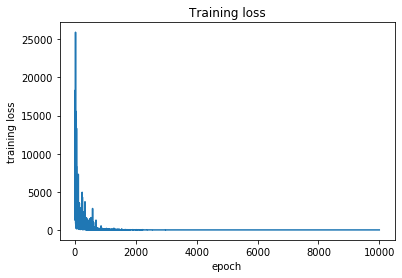

In [16]:
plt.plot(range(n_epochs), hist.history['loss'])
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('training loss')
n_test = 10
y_test_pred_ep_list = [ep_model(X_test) for _ in range(n_test)]

### Plot the training and test data

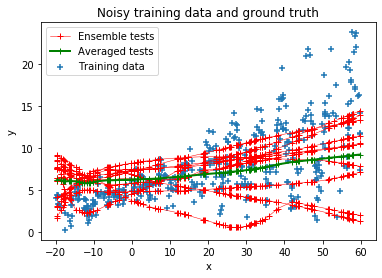

In [17]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
avg_mean = np.zeros_like(X_test)
for i, y in enumerate(y_test_pred_ep_list):
    y_mean = y.mean()
    plt.plot(X_test, y_mean, 'r-', marker='+', label='Ensemble tests' if i == 0 else None, linewidth=0.5)
    avg_mean += y_mean
plt.plot(X_test, avg_mean/n_test, 'g-', marker='+', label='Averaged tests', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Estimate aleatoric + epistemic uncertainty

### Define and train the model

In [18]:
def build_aleatoric_epistemic_model(train_size):
    model_in = Input(shape=(1,))
    x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(model_in)
    x = LeakyReLU(0.1)(x)
#     x = DenseVariational(64, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
#     x = LeakyReLU(0.1)(x)
#     x = DenseVariational(16, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
#     x = LeakyReLU(0.1)(x)
    x = DenseVariational(2, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1],
                                                        scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])))(x)
    model = Model(model_in, model_out)
    return model

ae_model = build_aleatoric_epistemic_model(n_train)
ae_model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
ae_model.summary()
hist = ae_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=2)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_variational_4 (DenseVa (None, 16)                96        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_variational_5 (DenseVa (None, 2)                 102       
_________________________________________________________________
distribution_lambda_3 (Distr ((None, 1), (None, 1))    0         
Total params: 198
Trainable params: 198
Non-trainable params: 0
_________________________________________________________________
Train on 400 samples
Epoch 1/10000
400/400 - 0s - loss: 1855.5181 - mean_squared_error: 4347.3276
Epoch 2/10000
400/400 - 0s - 

Epoch 93/10000
400/400 - 0s - loss: 18204.6748 - mean_squared_error: 4210.9346
Epoch 94/10000
400/400 - 0s - loss: 376.0157 - mean_squared_error: 447.6808
Epoch 95/10000
400/400 - 0s - loss: 4241.0011 - mean_squared_error: 4292.0171
Epoch 96/10000
400/400 - 0s - loss: 4965.7013 - mean_squared_error: 5966.0952
Epoch 97/10000
400/400 - 0s - loss: 6980.6472 - mean_squared_error: 4404.8159
Epoch 98/10000
400/400 - 0s - loss: 4757.1910 - mean_squared_error: 12302.1621
Epoch 99/10000
400/400 - 0s - loss: 1651.5587 - mean_squared_error: 3418.3293
Epoch 100/10000
400/400 - 0s - loss: 1987.4617 - mean_squared_error: 2491.3152
Epoch 101/10000
400/400 - 0s - loss: 1180.4945 - mean_squared_error: 379.6118
Epoch 102/10000
400/400 - 0s - loss: 15583.9550 - mean_squared_error: 8200.0947
Epoch 103/10000
400/400 - 0s - loss: 46817.4899 - mean_squared_error: 6709.7588
Epoch 104/10000
400/400 - 0s - loss: 712.4734 - mean_squared_error: 1811.0994
Epoch 105/10000
400/400 - 0s - loss: 8340.2856 - mean_squar

Epoch 197/10000
400/400 - 0s - loss: 3308.7732 - mean_squared_error: 695.5465
Epoch 198/10000
400/400 - 0s - loss: 1099.0549 - mean_squared_error: 3203.1604
Epoch 199/10000
400/400 - 0s - loss: 530.0346 - mean_squared_error: 695.8026
Epoch 200/10000
400/400 - 0s - loss: 3263.1247 - mean_squared_error: 6100.5024
Epoch 201/10000
400/400 - 0s - loss: 1391.0783 - mean_squared_error: 2067.8403
Epoch 202/10000
400/400 - 0s - loss: 369.6840 - mean_squared_error: 453.4585
Epoch 203/10000
400/400 - 0s - loss: 1056.2768 - mean_squared_error: 957.5651
Epoch 204/10000
400/400 - 0s - loss: 1282.9109 - mean_squared_error: 2071.7180
Epoch 205/10000
400/400 - 0s - loss: 9507.2258 - mean_squared_error: 9960.8115
Epoch 206/10000
400/400 - 0s - loss: 731.8170 - mean_squared_error: 947.6881
Epoch 207/10000
400/400 - 0s - loss: 7393.4632 - mean_squared_error: 5148.9634
Epoch 208/10000
400/400 - 0s - loss: 1082.1037 - mean_squared_error: 1430.1461
Epoch 209/10000
400/400 - 0s - loss: 1794.8349 - mean_square

Epoch 301/10000
400/400 - 0s - loss: 835.9806 - mean_squared_error: 1362.9482
Epoch 302/10000
400/400 - 0s - loss: 3826.8565 - mean_squared_error: 6361.3218
Epoch 303/10000
400/400 - 0s - loss: 699.5957 - mean_squared_error: 2801.9822
Epoch 304/10000
400/400 - 0s - loss: 16329.3831 - mean_squared_error: 10342.1504
Epoch 305/10000
400/400 - 0s - loss: 1100.0504 - mean_squared_error: 2616.0259
Epoch 306/10000
400/400 - 0s - loss: 2466.1327 - mean_squared_error: 1041.3638
Epoch 307/10000
400/400 - 0s - loss: 10264.4549 - mean_squared_error: 4725.3921
Epoch 308/10000
400/400 - 0s - loss: 1958.8901 - mean_squared_error: 1363.5682
Epoch 309/10000
400/400 - 0s - loss: 2550.6895 - mean_squared_error: 2668.5120
Epoch 310/10000
400/400 - 0s - loss: 499.6450 - mean_squared_error: 807.5232
Epoch 311/10000
400/400 - 0s - loss: 1724.3849 - mean_squared_error: 3508.6775
Epoch 312/10000
400/400 - 0s - loss: 3076.0781 - mean_squared_error: 2833.9653
Epoch 313/10000
400/400 - 0s - loss: 4077.2427 - mean

Epoch 406/10000
400/400 - 0s - loss: 856.9334 - mean_squared_error: 3114.6995
Epoch 407/10000
400/400 - 0s - loss: 9426.0230 - mean_squared_error: 4691.0894
Epoch 408/10000
400/400 - 0s - loss: 27707.8777 - mean_squared_error: 5140.6108
Epoch 409/10000
400/400 - 0s - loss: 3382.5137 - mean_squared_error: 3698.5769
Epoch 410/10000
400/400 - 0s - loss: 788.5043 - mean_squared_error: 1471.6625
Epoch 411/10000
400/400 - 0s - loss: 748.2203 - mean_squared_error: 3055.7700
Epoch 412/10000
400/400 - 0s - loss: 1729.0448 - mean_squared_error: 847.7658
Epoch 413/10000
400/400 - 0s - loss: 956.6011 - mean_squared_error: 3737.2935
Epoch 414/10000
400/400 - 0s - loss: 1395.9943 - mean_squared_error: 2399.7954
Epoch 415/10000
400/400 - 0s - loss: 675.4387 - mean_squared_error: 900.1658
Epoch 416/10000
400/400 - 0s - loss: 6369.1682 - mean_squared_error: 884.8719
Epoch 417/10000
400/400 - 0s - loss: 9938.0959 - mean_squared_error: 10285.7949
Epoch 418/10000
400/400 - 0s - loss: 1105.5795 - mean_squa

Epoch 511/10000
400/400 - 0s - loss: 2007.1583 - mean_squared_error: 9928.1904
Epoch 512/10000
400/400 - 0s - loss: 1233.2718 - mean_squared_error: 4102.6450
Epoch 513/10000
400/400 - 0s - loss: 1385.4225 - mean_squared_error: 2993.9072
Epoch 514/10000
400/400 - 0s - loss: 2214.0717 - mean_squared_error: 4866.4644
Epoch 515/10000
400/400 - 0s - loss: 186.7576 - mean_squared_error: 635.6267
Epoch 516/10000
400/400 - 0s - loss: 1010.7979 - mean_squared_error: 1293.6165
Epoch 517/10000
400/400 - 0s - loss: 239.4563 - mean_squared_error: 551.7966
Epoch 518/10000
400/400 - 0s - loss: 1140.0459 - mean_squared_error: 906.8304
Epoch 519/10000
400/400 - 0s - loss: 910.9546 - mean_squared_error: 977.6055
Epoch 520/10000
400/400 - 0s - loss: 4035.6807 - mean_squared_error: 1523.4622
Epoch 521/10000
400/400 - 0s - loss: 913.2061 - mean_squared_error: 1192.7386
Epoch 522/10000
400/400 - 0s - loss: 1387.5225 - mean_squared_error: 4628.9512
Epoch 523/10000
400/400 - 0s - loss: 1166.5360 - mean_square

Epoch 616/10000
400/400 - 0s - loss: 777.7232 - mean_squared_error: 1054.7075
Epoch 617/10000
400/400 - 0s - loss: 309.3337 - mean_squared_error: 576.3234
Epoch 618/10000
400/400 - 0s - loss: 1926.1674 - mean_squared_error: 3374.3779
Epoch 619/10000
400/400 - 0s - loss: 11802.5803 - mean_squared_error: 1953.7781
Epoch 620/10000
400/400 - 0s - loss: 324.3857 - mean_squared_error: 602.5988
Epoch 621/10000
400/400 - 0s - loss: 1171.1204 - mean_squared_error: 1231.1443
Epoch 622/10000
400/400 - 0s - loss: 1285.0697 - mean_squared_error: 978.3839
Epoch 623/10000
400/400 - 0s - loss: 3312.4629 - mean_squared_error: 1160.5931
Epoch 624/10000
400/400 - 0s - loss: 983.7405 - mean_squared_error: 1545.6759
Epoch 625/10000
400/400 - 0s - loss: 619.1150 - mean_squared_error: 1082.0159
Epoch 626/10000
400/400 - 0s - loss: 2498.1114 - mean_squared_error: 5096.8027
Epoch 627/10000
400/400 - 0s - loss: 2696.7114 - mean_squared_error: 4327.5552
Epoch 628/10000
400/400 - 0s - loss: 17964.8843 - mean_squa

Epoch 721/10000
400/400 - 0s - loss: 975.4953 - mean_squared_error: 1450.1748
Epoch 722/10000
400/400 - 0s - loss: 5737.3634 - mean_squared_error: 8799.8398
Epoch 723/10000
400/400 - 0s - loss: 1581.2877 - mean_squared_error: 3534.3013
Epoch 724/10000
400/400 - 0s - loss: 748.0187 - mean_squared_error: 714.0085
Epoch 725/10000
400/400 - 0s - loss: 233163.9983 - mean_squared_error: 18172.3105
Epoch 726/10000
400/400 - 0s - loss: 2756.1604 - mean_squared_error: 2139.4521
Epoch 727/10000
400/400 - 0s - loss: 609.0557 - mean_squared_error: 882.8165
Epoch 728/10000
400/400 - 0s - loss: 371.2564 - mean_squared_error: 1002.2542
Epoch 729/10000
400/400 - 0s - loss: 1498.9855 - mean_squared_error: 2286.3762
Epoch 730/10000
400/400 - 0s - loss: 471.1169 - mean_squared_error: 4874.9937
Epoch 731/10000
400/400 - 0s - loss: 1827.1705 - mean_squared_error: 1396.8927
Epoch 732/10000
400/400 - 0s - loss: 202.6352 - mean_squared_error: 517.7397
Epoch 733/10000
400/400 - 0s - loss: 93.3634 - mean_square

Epoch 826/10000
400/400 - 0s - loss: 720.6326 - mean_squared_error: 1461.7506
Epoch 827/10000
400/400 - 0s - loss: 863.9696 - mean_squared_error: 1545.2063
Epoch 828/10000
400/400 - 0s - loss: 388.5484 - mean_squared_error: 430.2517
Epoch 829/10000
400/400 - 0s - loss: 350.6576 - mean_squared_error: 257.0035
Epoch 830/10000
400/400 - 0s - loss: 2581.0526 - mean_squared_error: 1519.2002
Epoch 831/10000
400/400 - 0s - loss: 663.3643 - mean_squared_error: 2796.2937
Epoch 832/10000
400/400 - 0s - loss: 418.9594 - mean_squared_error: 1176.6202
Epoch 833/10000
400/400 - 0s - loss: 906.7291 - mean_squared_error: 3168.2932
Epoch 834/10000
400/400 - 0s - loss: 2098.2666 - mean_squared_error: 3215.7532
Epoch 835/10000
400/400 - 0s - loss: 398.9033 - mean_squared_error: 1392.2072
Epoch 836/10000
400/400 - 0s - loss: 1427.9298 - mean_squared_error: 5526.3374
Epoch 837/10000
400/400 - 0s - loss: 814.8282 - mean_squared_error: 850.0356
Epoch 838/10000
400/400 - 0s - loss: 477.4589 - mean_squared_err

Epoch 931/10000
400/400 - 0s - loss: 2057.4347 - mean_squared_error: 5222.4995
Epoch 932/10000
400/400 - 0s - loss: 97135.8525 - mean_squared_error: 7825.0327
Epoch 933/10000
400/400 - 0s - loss: 522.5912 - mean_squared_error: 1305.9741
Epoch 934/10000
400/400 - 0s - loss: 1193.0230 - mean_squared_error: 1535.4739
Epoch 935/10000
400/400 - 0s - loss: 747.2812 - mean_squared_error: 1284.9554
Epoch 936/10000
400/400 - 0s - loss: 1240.1386 - mean_squared_error: 2989.5852
Epoch 937/10000
400/400 - 0s - loss: 417.4122 - mean_squared_error: 1351.6278
Epoch 938/10000
400/400 - 0s - loss: 1369.4418 - mean_squared_error: 1243.6265
Epoch 939/10000
400/400 - 0s - loss: 2406.4336 - mean_squared_error: 4336.6870
Epoch 940/10000
400/400 - 0s - loss: 584.4436 - mean_squared_error: 1225.4708
Epoch 941/10000
400/400 - 0s - loss: 2749.3022 - mean_squared_error: 4121.4302
Epoch 942/10000
400/400 - 0s - loss: 424.1252 - mean_squared_error: 1181.9446
Epoch 943/10000
400/400 - 0s - loss: 1646.6309 - mean_sq

Epoch 1036/10000
400/400 - 0s - loss: 1579.8185 - mean_squared_error: 2728.3872
Epoch 1037/10000
400/400 - 0s - loss: 1637.3257 - mean_squared_error: 2428.8657
Epoch 1038/10000
400/400 - 0s - loss: 533.0599 - mean_squared_error: 944.1238
Epoch 1039/10000
400/400 - 0s - loss: 990.3472 - mean_squared_error: 4118.9634
Epoch 1040/10000
400/400 - 0s - loss: 2336.8683 - mean_squared_error: 794.8875
Epoch 1041/10000
400/400 - 0s - loss: 1115.0215 - mean_squared_error: 2059.7373
Epoch 1042/10000
400/400 - 0s - loss: 375.9473 - mean_squared_error: 755.9301
Epoch 1043/10000
400/400 - 0s - loss: 429.5970 - mean_squared_error: 1174.0493
Epoch 1044/10000
400/400 - 0s - loss: 992.3361 - mean_squared_error: 4080.5349
Epoch 1045/10000
400/400 - 0s - loss: 529.1095 - mean_squared_error: 874.6094
Epoch 1046/10000
400/400 - 0s - loss: 1743.8219 - mean_squared_error: 11231.8740
Epoch 1047/10000
400/400 - 0s - loss: 457.4263 - mean_squared_error: 695.7914
Epoch 1048/10000
400/400 - 0s - loss: 5161.7558 - m

Epoch 1140/10000
400/400 - 0s - loss: 1707.9074 - mean_squared_error: 3510.9729
Epoch 1141/10000
400/400 - 0s - loss: 1430.2764 - mean_squared_error: 1512.6674
Epoch 1142/10000
400/400 - 0s - loss: 798.0428 - mean_squared_error: 2741.8528
Epoch 1143/10000
400/400 - 0s - loss: 693.1053 - mean_squared_error: 581.2872
Epoch 1144/10000
400/400 - 0s - loss: 575.5197 - mean_squared_error: 2482.9199
Epoch 1145/10000
400/400 - 0s - loss: 562.1180 - mean_squared_error: 1233.0735
Epoch 1146/10000
400/400 - 0s - loss: 1728.0692 - mean_squared_error: 2505.8860
Epoch 1147/10000
400/400 - 0s - loss: 229.1456 - mean_squared_error: 474.9318
Epoch 1148/10000
400/400 - 0s - loss: 597.0824 - mean_squared_error: 1336.2812
Epoch 1149/10000
400/400 - 0s - loss: 689.5691 - mean_squared_error: 1134.4717
Epoch 1150/10000
400/400 - 0s - loss: 1868.0910 - mean_squared_error: 2896.3669
Epoch 1151/10000
400/400 - 0s - loss: 1507.8633 - mean_squared_error: 2300.6414
Epoch 1152/10000
400/400 - 0s - loss: 1291.1028 -

Epoch 1244/10000
400/400 - 0s - loss: 383.2028 - mean_squared_error: 387.8395
Epoch 1245/10000
400/400 - 0s - loss: 335.4246 - mean_squared_error: 1271.8036
Epoch 1246/10000
400/400 - 0s - loss: 253.6804 - mean_squared_error: 620.9038
Epoch 1247/10000
400/400 - 0s - loss: 734.3337 - mean_squared_error: 3263.8047
Epoch 1248/10000
400/400 - 0s - loss: 385.2213 - mean_squared_error: 829.3948
Epoch 1249/10000
400/400 - 0s - loss: 388.1701 - mean_squared_error: 701.1660
Epoch 1250/10000
400/400 - 0s - loss: 216.8607 - mean_squared_error: 650.2479
Epoch 1251/10000
400/400 - 0s - loss: 1438.3633 - mean_squared_error: 2969.0134
Epoch 1252/10000
400/400 - 0s - loss: 1313.2023 - mean_squared_error: 952.9853
Epoch 1253/10000
400/400 - 0s - loss: 251.3999 - mean_squared_error: 456.8202
Epoch 1254/10000
400/400 - 0s - loss: 1142.5077 - mean_squared_error: 1303.9125
Epoch 1255/10000
400/400 - 0s - loss: 2119.1280 - mean_squared_error: 1623.9786
Epoch 1256/10000
400/400 - 0s - loss: 1259.5910 - mean_

Epoch 1348/10000
400/400 - 0s - loss: 1034.0642 - mean_squared_error: 1358.5088
Epoch 1349/10000
400/400 - 0s - loss: 743.3471 - mean_squared_error: 2988.9758
Epoch 1350/10000
400/400 - 0s - loss: 222.9403 - mean_squared_error: 688.0516
Epoch 1351/10000
400/400 - 0s - loss: 626.0987 - mean_squared_error: 987.0864
Epoch 1352/10000
400/400 - 0s - loss: 1217.8778 - mean_squared_error: 3166.2771
Epoch 1353/10000
400/400 - 0s - loss: 556.4423 - mean_squared_error: 899.7191
Epoch 1354/10000
400/400 - 0s - loss: 253.2073 - mean_squared_error: 655.3264
Epoch 1355/10000
400/400 - 0s - loss: 1246.0850 - mean_squared_error: 2950.1204
Epoch 1356/10000
400/400 - 0s - loss: 166.6739 - mean_squared_error: 432.9991
Epoch 1357/10000
400/400 - 0s - loss: 270.8464 - mean_squared_error: 698.6334
Epoch 1358/10000
400/400 - 0s - loss: 1115.4910 - mean_squared_error: 1032.8866
Epoch 1359/10000
400/400 - 0s - loss: 669.2816 - mean_squared_error: 1605.4034
Epoch 1360/10000
400/400 - 0s - loss: 399.7609 - mean_

Epoch 1452/10000
400/400 - 0s - loss: 496.4660 - mean_squared_error: 919.4946
Epoch 1453/10000
400/400 - 0s - loss: 295.7968 - mean_squared_error: 405.7279
Epoch 1454/10000
400/400 - 0s - loss: 492.9898 - mean_squared_error: 1784.8514
Epoch 1455/10000
400/400 - 0s - loss: 629.9129 - mean_squared_error: 1268.8918
Epoch 1456/10000
400/400 - 0s - loss: 1988.3691 - mean_squared_error: 2399.2788
Epoch 1457/10000
400/400 - 0s - loss: 995.1902 - mean_squared_error: 2419.3765
Epoch 1458/10000
400/400 - 0s - loss: 269.6722 - mean_squared_error: 291.1534
Epoch 1459/10000
400/400 - 0s - loss: 383.8560 - mean_squared_error: 827.8649
Epoch 1460/10000
400/400 - 0s - loss: 631.5915 - mean_squared_error: 834.9949
Epoch 1461/10000
400/400 - 0s - loss: 389.6152 - mean_squared_error: 671.2234
Epoch 1462/10000
400/400 - 0s - loss: 686.3922 - mean_squared_error: 2715.1689
Epoch 1463/10000
400/400 - 0s - loss: 469.6249 - mean_squared_error: 811.6512
Epoch 1464/10000
400/400 - 0s - loss: 222.8708 - mean_squa

Epoch 1557/10000
400/400 - 0s - loss: 188.3680 - mean_squared_error: 977.4326
Epoch 1558/10000
400/400 - 0s - loss: 827.2562 - mean_squared_error: 1277.6506
Epoch 1559/10000
400/400 - 0s - loss: 342.9319 - mean_squared_error: 505.6821
Epoch 1560/10000
400/400 - 0s - loss: 792.3944 - mean_squared_error: 1632.9342
Epoch 1561/10000
400/400 - 0s - loss: 660.5289 - mean_squared_error: 3378.9863
Epoch 1562/10000
400/400 - 0s - loss: 378.4355 - mean_squared_error: 697.3883
Epoch 1563/10000
400/400 - 0s - loss: 395.1772 - mean_squared_error: 1242.2329
Epoch 1564/10000
400/400 - 0s - loss: 428.5390 - mean_squared_error: 1295.4645
Epoch 1565/10000
400/400 - 0s - loss: 230.1569 - mean_squared_error: 406.1089
Epoch 1566/10000
400/400 - 0s - loss: 312.3773 - mean_squared_error: 369.5359
Epoch 1567/10000
400/400 - 0s - loss: 433.8161 - mean_squared_error: 883.5386
Epoch 1568/10000
400/400 - 0s - loss: 406.2764 - mean_squared_error: 959.2894
Epoch 1569/10000
400/400 - 0s - loss: 358.0694 - mean_squar

Epoch 1662/10000
400/400 - 0s - loss: 892.1510 - mean_squared_error: 1348.3961
Epoch 1663/10000
400/400 - 0s - loss: 586.2761 - mean_squared_error: 687.0852
Epoch 1664/10000
400/400 - 0s - loss: 714.1600 - mean_squared_error: 951.2898
Epoch 1665/10000
400/400 - 0s - loss: 1220.8143 - mean_squared_error: 1391.3723
Epoch 1666/10000
400/400 - 0s - loss: 421.6368 - mean_squared_error: 843.1707
Epoch 1667/10000
400/400 - 0s - loss: 202.1767 - mean_squared_error: 335.0957
Epoch 1668/10000
400/400 - 0s - loss: 1111.3185 - mean_squared_error: 2001.2802
Epoch 1669/10000
400/400 - 0s - loss: 861.8282 - mean_squared_error: 1202.9169
Epoch 1670/10000
400/400 - 0s - loss: 875.2792 - mean_squared_error: 1299.4211
Epoch 1671/10000
400/400 - 0s - loss: 284.1051 - mean_squared_error: 589.2101
Epoch 1672/10000
400/400 - 0s - loss: 419.6125 - mean_squared_error: 656.2051
Epoch 1673/10000
400/400 - 0s - loss: 331.4494 - mean_squared_error: 1081.0540
Epoch 1674/10000
400/400 - 0s - loss: 297.1753 - mean_sq

Epoch 1767/10000
400/400 - 0s - loss: 87.4516 - mean_squared_error: 125.3233
Epoch 1768/10000
400/400 - 0s - loss: 445.1952 - mean_squared_error: 521.3787
Epoch 1769/10000
400/400 - 0s - loss: 183.5204 - mean_squared_error: 473.3745
Epoch 1770/10000
400/400 - 0s - loss: 320.1629 - mean_squared_error: 2174.7954
Epoch 1771/10000
400/400 - 0s - loss: 489.5749 - mean_squared_error: 632.1578
Epoch 1772/10000
400/400 - 0s - loss: 226.1527 - mean_squared_error: 379.0031
Epoch 1773/10000
400/400 - 0s - loss: 527.3952 - mean_squared_error: 994.5810
Epoch 1774/10000
400/400 - 0s - loss: 1215.2906 - mean_squared_error: 2568.7976
Epoch 1775/10000
400/400 - 0s - loss: 179.1052 - mean_squared_error: 548.1323
Epoch 1776/10000
400/400 - 0s - loss: 386.6623 - mean_squared_error: 761.0656
Epoch 1777/10000
400/400 - 0s - loss: 40.6834 - mean_squared_error: 102.9551
Epoch 1778/10000
400/400 - 0s - loss: 720.4177 - mean_squared_error: 1447.4565
Epoch 1779/10000
400/400 - 0s - loss: 900.5963 - mean_squared_

Epoch 1872/10000
400/400 - 0s - loss: 278.1388 - mean_squared_error: 843.3900
Epoch 1873/10000
400/400 - 0s - loss: 289.1065 - mean_squared_error: 616.2005
Epoch 1874/10000
400/400 - 0s - loss: 273.8442 - mean_squared_error: 577.1415
Epoch 1875/10000
400/400 - 0s - loss: 210.1327 - mean_squared_error: 438.9601
Epoch 1876/10000
400/400 - 0s - loss: 812.7505 - mean_squared_error: 1320.2310
Epoch 1877/10000
400/400 - 0s - loss: 733.4066 - mean_squared_error: 5279.8750
Epoch 1878/10000
400/400 - 0s - loss: 415.5290 - mean_squared_error: 805.4931
Epoch 1879/10000
400/400 - 0s - loss: 212.6434 - mean_squared_error: 405.1857
Epoch 1880/10000
400/400 - 0s - loss: 1373.4561 - mean_squared_error: 2131.2258
Epoch 1881/10000
400/400 - 0s - loss: 523.8012 - mean_squared_error: 1165.8375
Epoch 1882/10000
400/400 - 0s - loss: 903.2196 - mean_squared_error: 1215.9972
Epoch 1883/10000
400/400 - 0s - loss: 590.1525 - mean_squared_error: 1202.0844
Epoch 1884/10000
400/400 - 0s - loss: 240.7215 - mean_squ

Epoch 1977/10000
400/400 - 0s - loss: 184.3249 - mean_squared_error: 317.6767
Epoch 1978/10000
400/400 - 0s - loss: 215.8074 - mean_squared_error: 616.2321
Epoch 1979/10000
400/400 - 0s - loss: 1004.2537 - mean_squared_error: 1530.0707
Epoch 1980/10000
400/400 - 0s - loss: 1100.4049 - mean_squared_error: 1074.8004
Epoch 1981/10000
400/400 - 0s - loss: 649.8474 - mean_squared_error: 1338.4725
Epoch 1982/10000
400/400 - 0s - loss: 200.8930 - mean_squared_error: 282.1158
Epoch 1983/10000
400/400 - 0s - loss: 554.7538 - mean_squared_error: 1168.6801
Epoch 1984/10000
400/400 - 0s - loss: 98.1767 - mean_squared_error: 241.3610
Epoch 1985/10000
400/400 - 0s - loss: 518.5838 - mean_squared_error: 1263.0676
Epoch 1986/10000
400/400 - 0s - loss: 608.8278 - mean_squared_error: 784.1235
Epoch 1987/10000
400/400 - 0s - loss: 72.0850 - mean_squared_error: 193.1645
Epoch 1988/10000
400/400 - 0s - loss: 521.7508 - mean_squared_error: 1015.4440
Epoch 1989/10000
400/400 - 0s - loss: 388.5013 - mean_squa

Epoch 2082/10000
400/400 - 0s - loss: 359.0937 - mean_squared_error: 2251.4434
Epoch 2083/10000
400/400 - 0s - loss: 182.1128 - mean_squared_error: 318.3235
Epoch 2084/10000
400/400 - 0s - loss: 670.1529 - mean_squared_error: 1807.1929
Epoch 2085/10000
400/400 - 0s - loss: 589.8700 - mean_squared_error: 951.7635
Epoch 2086/10000
400/400 - 0s - loss: 532.3341 - mean_squared_error: 1012.0125
Epoch 2087/10000
400/400 - 0s - loss: 584.3383 - mean_squared_error: 5901.6357
Epoch 2088/10000
400/400 - 0s - loss: 333.0807 - mean_squared_error: 550.5359
Epoch 2089/10000
400/400 - 0s - loss: 80.3182 - mean_squared_error: 212.0060
Epoch 2090/10000
400/400 - 0s - loss: 1201.8549 - mean_squared_error: 1427.1277
Epoch 2091/10000
400/400 - 0s - loss: 398.6633 - mean_squared_error: 860.7079
Epoch 2092/10000
400/400 - 0s - loss: 362.3773 - mean_squared_error: 445.3043
Epoch 2093/10000
400/400 - 0s - loss: 378.6529 - mean_squared_error: 656.5629
Epoch 2094/10000
400/400 - 0s - loss: 2033.8835 - mean_squa

Epoch 2187/10000
400/400 - 0s - loss: 153.0306 - mean_squared_error: 167.9495
Epoch 2188/10000
400/400 - 0s - loss: 518.1071 - mean_squared_error: 1548.6893
Epoch 2189/10000
400/400 - 0s - loss: 649.4737 - mean_squared_error: 1142.7174
Epoch 2190/10000
400/400 - 0s - loss: 91.5584 - mean_squared_error: 436.1733
Epoch 2191/10000
400/400 - 0s - loss: 215.6665 - mean_squared_error: 706.8077
Epoch 2192/10000
400/400 - 0s - loss: 241.4709 - mean_squared_error: 618.8981
Epoch 2193/10000
400/400 - 0s - loss: 607.3514 - mean_squared_error: 2050.4233
Epoch 2194/10000
400/400 - 0s - loss: 384.3232 - mean_squared_error: 561.7314
Epoch 2195/10000
400/400 - 0s - loss: 383.6703 - mean_squared_error: 1355.4888
Epoch 2196/10000
400/400 - 0s - loss: 401.7677 - mean_squared_error: 787.2307
Epoch 2197/10000
400/400 - 0s - loss: 434.1457 - mean_squared_error: 1783.8225
Epoch 2198/10000
400/400 - 0s - loss: 1042.4384 - mean_squared_error: 2694.1721
Epoch 2199/10000
400/400 - 0s - loss: 242.8580 - mean_squa

Epoch 2292/10000
400/400 - 0s - loss: 320.9674 - mean_squared_error: 1160.3063
Epoch 2293/10000
400/400 - 0s - loss: 293.4292 - mean_squared_error: 497.5612
Epoch 2294/10000
400/400 - 0s - loss: 607.8222 - mean_squared_error: 1514.9106
Epoch 2295/10000
400/400 - 0s - loss: 166.7466 - mean_squared_error: 399.6711
Epoch 2296/10000
400/400 - 0s - loss: 2551.4357 - mean_squared_error: 3162.7927
Epoch 2297/10000
400/400 - 0s - loss: 211.7434 - mean_squared_error: 405.4623
Epoch 2298/10000
400/400 - 0s - loss: 403.6480 - mean_squared_error: 1239.5474
Epoch 2299/10000
400/400 - 0s - loss: 228.7409 - mean_squared_error: 672.9436
Epoch 2300/10000
400/400 - 0s - loss: 818.7063 - mean_squared_error: 1240.4762
Epoch 2301/10000
400/400 - 0s - loss: 325.7643 - mean_squared_error: 2585.1028
Epoch 2302/10000
400/400 - 0s - loss: 193.1198 - mean_squared_error: 339.1147
Epoch 2303/10000
400/400 - 0s - loss: 344.7498 - mean_squared_error: 774.9315
Epoch 2304/10000
400/400 - 0s - loss: 207.8135 - mean_squ

Epoch 2397/10000
400/400 - 0s - loss: 326.1199 - mean_squared_error: 942.9052
Epoch 2398/10000
400/400 - 0s - loss: 321.0109 - mean_squared_error: 1798.0814
Epoch 2399/10000
400/400 - 0s - loss: 300.8831 - mean_squared_error: 703.7361
Epoch 2400/10000
400/400 - 0s - loss: 97.5909 - mean_squared_error: 218.5349
Epoch 2401/10000
400/400 - 0s - loss: 738.6510 - mean_squared_error: 2289.8574
Epoch 2402/10000
400/400 - 0s - loss: 433.2119 - mean_squared_error: 501.8226
Epoch 2403/10000
400/400 - 0s - loss: 288.0691 - mean_squared_error: 543.4465
Epoch 2404/10000
400/400 - 0s - loss: 306.1456 - mean_squared_error: 2373.6340
Epoch 2405/10000
400/400 - 0s - loss: 268.3687 - mean_squared_error: 577.5949
Epoch 2406/10000
400/400 - 0s - loss: 1199.6165 - mean_squared_error: 3601.7576
Epoch 2407/10000
400/400 - 0s - loss: 342.1074 - mean_squared_error: 858.1570
Epoch 2408/10000
400/400 - 0s - loss: 231.9044 - mean_squared_error: 940.2071
Epoch 2409/10000
400/400 - 0s - loss: 217.5058 - mean_square

Epoch 2502/10000
400/400 - 0s - loss: 232.4409 - mean_squared_error: 383.4423
Epoch 2503/10000
400/400 - 0s - loss: 1439.2192 - mean_squared_error: 1257.1724
Epoch 2504/10000
400/400 - 0s - loss: 849.8047 - mean_squared_error: 1119.8556
Epoch 2505/10000
400/400 - 0s - loss: 531.5762 - mean_squared_error: 523.2961
Epoch 2506/10000
400/400 - 0s - loss: 285.3832 - mean_squared_error: 1298.5220
Epoch 2507/10000
400/400 - 0s - loss: 69.8283 - mean_squared_error: 110.5035
Epoch 2508/10000
400/400 - 0s - loss: 1773.7793 - mean_squared_error: 2847.1931
Epoch 2509/10000
400/400 - 0s - loss: 130.9223 - mean_squared_error: 146.3696
Epoch 2510/10000
400/400 - 0s - loss: 273.5392 - mean_squared_error: 3247.4199
Epoch 2511/10000
400/400 - 0s - loss: 877.2009 - mean_squared_error: 1542.2809
Epoch 2512/10000
400/400 - 0s - loss: 275.4217 - mean_squared_error: 957.9040
Epoch 2513/10000
400/400 - 0s - loss: 1155.9893 - mean_squared_error: 2937.8660
Epoch 2514/10000
400/400 - 0s - loss: 387.5031 - mean_s

Epoch 2607/10000
400/400 - 0s - loss: 131.3378 - mean_squared_error: 206.0311
Epoch 2608/10000
400/400 - 0s - loss: 307.0855 - mean_squared_error: 878.3967
Epoch 2609/10000
400/400 - 0s - loss: 196.1025 - mean_squared_error: 779.3209
Epoch 2610/10000
400/400 - 0s - loss: 535.5042 - mean_squared_error: 3474.4937
Epoch 2611/10000
400/400 - 0s - loss: 259.9715 - mean_squared_error: 1358.1410
Epoch 2612/10000
400/400 - 0s - loss: 560.8320 - mean_squared_error: 1781.6875
Epoch 2613/10000
400/400 - 0s - loss: 105.3799 - mean_squared_error: 258.6431
Epoch 2614/10000
400/400 - 0s - loss: 383.3106 - mean_squared_error: 740.3051
Epoch 2615/10000
400/400 - 0s - loss: 94.4250 - mean_squared_error: 535.0066
Epoch 2616/10000
400/400 - 0s - loss: 481.3359 - mean_squared_error: 784.4821
Epoch 2617/10000
400/400 - 0s - loss: 292.7897 - mean_squared_error: 461.6743
Epoch 2618/10000
400/400 - 0s - loss: 506.8883 - mean_squared_error: 799.8398
Epoch 2619/10000
400/400 - 0s - loss: 641.5168 - mean_squared_

400/400 - 0s - loss: 402.3293 - mean_squared_error: 461.4587
Epoch 2713/10000
400/400 - 0s - loss: 149.8026 - mean_squared_error: 394.0650
Epoch 2714/10000
400/400 - 0s - loss: 98.4913 - mean_squared_error: 376.2505
Epoch 2715/10000
400/400 - 0s - loss: 101.2087 - mean_squared_error: 475.6220
Epoch 2716/10000
400/400 - 0s - loss: 218.4181 - mean_squared_error: 989.8683
Epoch 2717/10000
400/400 - 0s - loss: 269.2332 - mean_squared_error: 1347.9033
Epoch 2718/10000
400/400 - 0s - loss: 162.2812 - mean_squared_error: 364.2616
Epoch 2719/10000
400/400 - 0s - loss: 392.8603 - mean_squared_error: 575.2381
Epoch 2720/10000
400/400 - 0s - loss: 32.1428 - mean_squared_error: 76.2873
Epoch 2721/10000
400/400 - 0s - loss: 98.1844 - mean_squared_error: 839.7067
Epoch 2722/10000
400/400 - 0s - loss: 232.9705 - mean_squared_error: 851.8967
Epoch 2723/10000
400/400 - 0s - loss: 178.1405 - mean_squared_error: 671.9615
Epoch 2724/10000
400/400 - 0s - loss: 166.3839 - mean_squared_error: 463.3605
Epoch 

Epoch 2818/10000
400/400 - 0s - loss: 216.6922 - mean_squared_error: 379.8268
Epoch 2819/10000
400/400 - 0s - loss: 116.7747 - mean_squared_error: 682.4704
Epoch 2820/10000
400/400 - 0s - loss: 230.0209 - mean_squared_error: 834.0385
Epoch 2821/10000
400/400 - 0s - loss: 91.4261 - mean_squared_error: 886.9600
Epoch 2822/10000
400/400 - 0s - loss: 156.2185 - mean_squared_error: 1424.9336
Epoch 2823/10000
400/400 - 0s - loss: 238.6298 - mean_squared_error: 640.7977
Epoch 2824/10000
400/400 - 0s - loss: 339.2461 - mean_squared_error: 1737.2532
Epoch 2825/10000
400/400 - 0s - loss: 192.0257 - mean_squared_error: 345.4470
Epoch 2826/10000
400/400 - 0s - loss: 158.9194 - mean_squared_error: 626.7936
Epoch 2827/10000
400/400 - 0s - loss: 474.9020 - mean_squared_error: 663.6629
Epoch 2828/10000
400/400 - 0s - loss: 838.1372 - mean_squared_error: 831.1536
Epoch 2829/10000
400/400 - 0s - loss: 56.8426 - mean_squared_error: 129.9325
Epoch 2830/10000
400/400 - 0s - loss: 185.4634 - mean_squared_er

Epoch 2924/10000
400/400 - 0s - loss: 19.3347 - mean_squared_error: 37.8642
Epoch 2925/10000
400/400 - 0s - loss: 95.7059 - mean_squared_error: 354.4517
Epoch 2926/10000
400/400 - 0s - loss: 809.2167 - mean_squared_error: 1873.1156
Epoch 2927/10000
400/400 - 0s - loss: 552.3332 - mean_squared_error: 1358.2260
Epoch 2928/10000
400/400 - 0s - loss: 118.0002 - mean_squared_error: 571.4152
Epoch 2929/10000
400/400 - 0s - loss: 148.6504 - mean_squared_error: 469.7897
Epoch 2930/10000
400/400 - 0s - loss: 121.1567 - mean_squared_error: 402.9308
Epoch 2931/10000
400/400 - 0s - loss: 134.1571 - mean_squared_error: 430.6321
Epoch 2932/10000
400/400 - 0s - loss: 91.9079 - mean_squared_error: 246.1121
Epoch 2933/10000
400/400 - 0s - loss: 147.7377 - mean_squared_error: 427.3592
Epoch 2934/10000
400/400 - 0s - loss: 135.3075 - mean_squared_error: 459.0563
Epoch 2935/10000
400/400 - 0s - loss: 177.2351 - mean_squared_error: 802.6066
Epoch 2936/10000
400/400 - 0s - loss: 102.3110 - mean_squared_erro

Epoch 3030/10000
400/400 - 0s - loss: 83.4996 - mean_squared_error: 294.4011
Epoch 3031/10000
400/400 - 0s - loss: 195.5450 - mean_squared_error: 294.0635
Epoch 3032/10000
400/400 - 0s - loss: 63.9167 - mean_squared_error: 624.9916
Epoch 3033/10000
400/400 - 0s - loss: 94.7188 - mean_squared_error: 331.7171
Epoch 3034/10000
400/400 - 0s - loss: 66.6358 - mean_squared_error: 223.9958
Epoch 3035/10000
400/400 - 0s - loss: 49.1711 - mean_squared_error: 246.6349
Epoch 3036/10000
400/400 - 0s - loss: 164.3855 - mean_squared_error: 479.2080
Epoch 3037/10000
400/400 - 0s - loss: 126.1125 - mean_squared_error: 561.1891
Epoch 3038/10000
400/400 - 0s - loss: 74.3763 - mean_squared_error: 710.2756
Epoch 3039/10000
400/400 - 0s - loss: 103.3450 - mean_squared_error: 199.9366
Epoch 3040/10000
400/400 - 0s - loss: 146.6461 - mean_squared_error: 683.7281
Epoch 3041/10000
400/400 - 0s - loss: 252.2031 - mean_squared_error: 1685.5398
Epoch 3042/10000
400/400 - 0s - loss: 142.6931 - mean_squared_error: 

Epoch 3136/10000
400/400 - 0s - loss: 15.4221 - mean_squared_error: 39.2430
Epoch 3137/10000
400/400 - 0s - loss: 167.7837 - mean_squared_error: 542.6898
Epoch 3138/10000
400/400 - 0s - loss: 121.2616 - mean_squared_error: 385.0561
Epoch 3139/10000
400/400 - 0s - loss: 122.5848 - mean_squared_error: 554.1093
Epoch 3140/10000
400/400 - 0s - loss: 70.4330 - mean_squared_error: 619.8907
Epoch 3141/10000
400/400 - 0s - loss: 111.4363 - mean_squared_error: 414.2991
Epoch 3142/10000
400/400 - 0s - loss: 165.7438 - mean_squared_error: 674.9484
Epoch 3143/10000
400/400 - 0s - loss: 103.8551 - mean_squared_error: 309.5441
Epoch 3144/10000
400/400 - 0s - loss: 102.3546 - mean_squared_error: 514.8480
Epoch 3145/10000
400/400 - 0s - loss: 194.7969 - mean_squared_error: 846.5946
Epoch 3146/10000
400/400 - 0s - loss: 107.0856 - mean_squared_error: 260.7243
Epoch 3147/10000
400/400 - 0s - loss: 60.7960 - mean_squared_error: 390.0509
Epoch 3148/10000
400/400 - 0s - loss: 24.0793 - mean_squared_error: 

Epoch 3242/10000
400/400 - 0s - loss: 38.5701 - mean_squared_error: 114.3409
Epoch 3243/10000
400/400 - 0s - loss: 46.9212 - mean_squared_error: 327.3039
Epoch 3244/10000
400/400 - 0s - loss: 26.6255 - mean_squared_error: 119.2197
Epoch 3245/10000
400/400 - 0s - loss: 85.5914 - mean_squared_error: 375.2334
Epoch 3246/10000
400/400 - 0s - loss: 104.8877 - mean_squared_error: 591.5698
Epoch 3247/10000
400/400 - 0s - loss: 65.9117 - mean_squared_error: 375.9085
Epoch 3248/10000
400/400 - 0s - loss: 59.9944 - mean_squared_error: 161.8601
Epoch 3249/10000
400/400 - 0s - loss: 45.2652 - mean_squared_error: 279.0733
Epoch 3250/10000
400/400 - 0s - loss: 70.0000 - mean_squared_error: 557.6531
Epoch 3251/10000
400/400 - 0s - loss: 17.1838 - mean_squared_error: 53.2011
Epoch 3252/10000
400/400 - 0s - loss: 112.3827 - mean_squared_error: 439.6895
Epoch 3253/10000
400/400 - 0s - loss: 32.4590 - mean_squared_error: 76.5245
Epoch 3254/10000
400/400 - 0s - loss: 64.6320 - mean_squared_error: 636.2558

400/400 - 0s - loss: 161.6173 - mean_squared_error: 786.1099
Epoch 3349/10000
400/400 - 0s - loss: 66.5905 - mean_squared_error: 392.0937
Epoch 3350/10000
400/400 - 0s - loss: 50.1206 - mean_squared_error: 458.3959
Epoch 3351/10000
400/400 - 0s - loss: 33.5858 - mean_squared_error: 172.4780
Epoch 3352/10000
400/400 - 0s - loss: 75.5474 - mean_squared_error: 364.0477
Epoch 3353/10000
400/400 - 0s - loss: 126.6392 - mean_squared_error: 523.3571
Epoch 3354/10000
400/400 - 0s - loss: 43.3329 - mean_squared_error: 203.6300
Epoch 3355/10000
400/400 - 0s - loss: 152.5955 - mean_squared_error: 796.5967
Epoch 3356/10000
400/400 - 0s - loss: 30.1728 - mean_squared_error: 77.9331
Epoch 3357/10000
400/400 - 0s - loss: 32.8839 - mean_squared_error: 222.1543
Epoch 3358/10000
400/400 - 0s - loss: 46.0690 - mean_squared_error: 128.4167
Epoch 3359/10000
400/400 - 0s - loss: 44.6395 - mean_squared_error: 374.8729
Epoch 3360/10000
400/400 - 0s - loss: 36.8795 - mean_squared_error: 149.3619
Epoch 3361/100

Epoch 3455/10000
400/400 - 0s - loss: 24.4494 - mean_squared_error: 79.1460
Epoch 3456/10000
400/400 - 0s - loss: 20.8797 - mean_squared_error: 96.0862
Epoch 3457/10000
400/400 - 0s - loss: 93.5365 - mean_squared_error: 590.4927
Epoch 3458/10000
400/400 - 0s - loss: 23.0298 - mean_squared_error: 138.2544
Epoch 3459/10000
400/400 - 0s - loss: 79.1215 - mean_squared_error: 408.1823
Epoch 3460/10000
400/400 - 0s - loss: 58.3473 - mean_squared_error: 484.2362
Epoch 3461/10000
400/400 - 0s - loss: 23.9097 - mean_squared_error: 191.5909
Epoch 3462/10000
400/400 - 0s - loss: 82.9344 - mean_squared_error: 341.9996
Epoch 3463/10000
400/400 - 0s - loss: 23.8582 - mean_squared_error: 191.2809
Epoch 3464/10000
400/400 - 0s - loss: 55.3968 - mean_squared_error: 241.0043
Epoch 3465/10000
400/400 - 0s - loss: 42.1146 - mean_squared_error: 324.7391
Epoch 3466/10000
400/400 - 0s - loss: 23.3749 - mean_squared_error: 87.8946
Epoch 3467/10000
400/400 - 0s - loss: 47.6992 - mean_squared_error: 147.0662
Ep

Epoch 3562/10000
400/400 - 0s - loss: 39.2184 - mean_squared_error: 274.7751
Epoch 3563/10000
400/400 - 0s - loss: 18.8991 - mean_squared_error: 256.1644
Epoch 3564/10000
400/400 - 0s - loss: 25.8482 - mean_squared_error: 267.9611
Epoch 3565/10000
400/400 - 0s - loss: 15.2310 - mean_squared_error: 104.6594
Epoch 3566/10000
400/400 - 0s - loss: 70.7242 - mean_squared_error: 247.7617
Epoch 3567/10000
400/400 - 0s - loss: 33.3887 - mean_squared_error: 411.3384
Epoch 3568/10000
400/400 - 0s - loss: 24.0667 - mean_squared_error: 242.0461
Epoch 3569/10000
400/400 - 0s - loss: 37.8949 - mean_squared_error: 280.1234
Epoch 3570/10000
400/400 - 0s - loss: 42.6567 - mean_squared_error: 228.8263
Epoch 3571/10000
400/400 - 0s - loss: 16.1228 - mean_squared_error: 232.7354
Epoch 3572/10000
400/400 - 0s - loss: 31.7436 - mean_squared_error: 266.9527
Epoch 3573/10000
400/400 - 0s - loss: 41.4501 - mean_squared_error: 293.9274
Epoch 3574/10000
400/400 - 0s - loss: 61.8134 - mean_squared_error: 458.7566

Epoch 3669/10000
400/400 - 0s - loss: 41.6825 - mean_squared_error: 214.8395
Epoch 3670/10000
400/400 - 0s - loss: 17.7326 - mean_squared_error: 263.9542
Epoch 3671/10000
400/400 - 0s - loss: 31.1021 - mean_squared_error: 350.6629
Epoch 3672/10000
400/400 - 0s - loss: 26.3293 - mean_squared_error: 188.6112
Epoch 3673/10000
400/400 - 0s - loss: 67.3671 - mean_squared_error: 480.2715
Epoch 3674/10000
400/400 - 0s - loss: 23.7177 - mean_squared_error: 297.8202
Epoch 3675/10000
400/400 - 0s - loss: 15.8046 - mean_squared_error: 107.5136
Epoch 3676/10000
400/400 - 0s - loss: 28.5016 - mean_squared_error: 134.1869
Epoch 3677/10000
400/400 - 0s - loss: 27.2352 - mean_squared_error: 124.6468
Epoch 3678/10000
400/400 - 0s - loss: 38.2542 - mean_squared_error: 244.3375
Epoch 3679/10000
400/400 - 0s - loss: 20.6386 - mean_squared_error: 129.9311
Epoch 3680/10000
400/400 - 0s - loss: 19.3396 - mean_squared_error: 150.1329
Epoch 3681/10000
400/400 - 0s - loss: 69.4450 - mean_squared_error: 821.1042

Epoch 3776/10000
400/400 - 0s - loss: 19.2754 - mean_squared_error: 228.7839
Epoch 3777/10000
400/400 - 0s - loss: 24.2957 - mean_squared_error: 494.0375
Epoch 3778/10000
400/400 - 0s - loss: 39.7565 - mean_squared_error: 295.0003
Epoch 3779/10000
400/400 - 0s - loss: 31.1209 - mean_squared_error: 329.6642
Epoch 3780/10000
400/400 - 0s - loss: 11.2430 - mean_squared_error: 49.7446
Epoch 3781/10000
400/400 - 0s - loss: 20.8814 - mean_squared_error: 124.2236
Epoch 3782/10000
400/400 - 0s - loss: 37.3685 - mean_squared_error: 306.1099
Epoch 3783/10000
400/400 - 0s - loss: 25.8459 - mean_squared_error: 119.0547
Epoch 3784/10000
400/400 - 0s - loss: 25.7359 - mean_squared_error: 187.5499
Epoch 3785/10000
400/400 - 0s - loss: 17.3676 - mean_squared_error: 94.7902
Epoch 3786/10000
400/400 - 0s - loss: 45.6995 - mean_squared_error: 540.1549
Epoch 3787/10000
400/400 - 0s - loss: 7.9575 - mean_squared_error: 98.5965
Epoch 3788/10000
400/400 - 0s - loss: 20.1189 - mean_squared_error: 126.1014
Epo

Epoch 3883/10000
400/400 - 0s - loss: 20.3577 - mean_squared_error: 247.4805
Epoch 3884/10000
400/400 - 0s - loss: 11.0011 - mean_squared_error: 98.7497
Epoch 3885/10000
400/400 - 0s - loss: 16.1191 - mean_squared_error: 286.5014
Epoch 3886/10000
400/400 - 0s - loss: 23.0007 - mean_squared_error: 107.9100
Epoch 3887/10000
400/400 - 0s - loss: 60.7099 - mean_squared_error: 595.6810
Epoch 3888/10000
400/400 - 0s - loss: 34.8025 - mean_squared_error: 151.5507
Epoch 3889/10000
400/400 - 0s - loss: 17.1648 - mean_squared_error: 369.3969
Epoch 3890/10000
400/400 - 0s - loss: 58.9229 - mean_squared_error: 385.5579
Epoch 3891/10000
400/400 - 0s - loss: 15.9286 - mean_squared_error: 70.4687
Epoch 3892/10000
400/400 - 0s - loss: 23.7236 - mean_squared_error: 432.0917
Epoch 3893/10000
400/400 - 0s - loss: 47.6315 - mean_squared_error: 416.8217
Epoch 3894/10000
400/400 - 0s - loss: 14.1345 - mean_squared_error: 190.1983
Epoch 3895/10000
400/400 - 0s - loss: 30.7240 - mean_squared_error: 252.3366
E

Epoch 3990/10000
400/400 - 0s - loss: 10.8129 - mean_squared_error: 225.2143
Epoch 3991/10000
400/400 - 0s - loss: 20.2700 - mean_squared_error: 281.3202
Epoch 3992/10000
400/400 - 0s - loss: 10.2766 - mean_squared_error: 130.8313
Epoch 3993/10000
400/400 - 0s - loss: 13.2740 - mean_squared_error: 91.4343
Epoch 3994/10000
400/400 - 0s - loss: 13.8093 - mean_squared_error: 64.3389
Epoch 3995/10000
400/400 - 0s - loss: 13.1069 - mean_squared_error: 146.7421
Epoch 3996/10000
400/400 - 0s - loss: 56.6972 - mean_squared_error: 402.8230
Epoch 3997/10000
400/400 - 0s - loss: 27.0748 - mean_squared_error: 336.7673
Epoch 3998/10000
400/400 - 0s - loss: 40.2357 - mean_squared_error: 354.1391
Epoch 3999/10000
400/400 - 0s - loss: 11.7942 - mean_squared_error: 81.3210
Epoch 4000/10000
400/400 - 0s - loss: 9.6782 - mean_squared_error: 58.1076
Epoch 4001/10000
400/400 - 0s - loss: 18.1555 - mean_squared_error: 157.2631
Epoch 4002/10000
400/400 - 0s - loss: 9.0642 - mean_squared_error: 108.1662
Epoch

Epoch 4097/10000
400/400 - 0s - loss: 6.6984 - mean_squared_error: 53.2681
Epoch 4098/10000
400/400 - 0s - loss: 29.2494 - mean_squared_error: 337.9862
Epoch 4099/10000
400/400 - 0s - loss: 34.3058 - mean_squared_error: 219.2693
Epoch 4100/10000
400/400 - 0s - loss: 27.0606 - mean_squared_error: 279.9328
Epoch 4101/10000
400/400 - 0s - loss: 12.8690 - mean_squared_error: 154.3118
Epoch 4102/10000
400/400 - 0s - loss: 10.6977 - mean_squared_error: 69.5044
Epoch 4103/10000
400/400 - 0s - loss: 20.0254 - mean_squared_error: 152.0973
Epoch 4104/10000
400/400 - 0s - loss: 34.7333 - mean_squared_error: 253.6989
Epoch 4105/10000
400/400 - 0s - loss: 73.6271 - mean_squared_error: 191.3661
Epoch 4106/10000
400/400 - 0s - loss: 28.2476 - mean_squared_error: 105.7010
Epoch 4107/10000
400/400 - 0s - loss: 12.5871 - mean_squared_error: 223.5878
Epoch 4108/10000
400/400 - 0s - loss: 18.8200 - mean_squared_error: 136.5694
Epoch 4109/10000
400/400 - 0s - loss: 10.3927 - mean_squared_error: 67.4624
Epo

Epoch 4205/10000
400/400 - 0s - loss: 31.0087 - mean_squared_error: 291.8056
Epoch 4206/10000
400/400 - 0s - loss: 12.5237 - mean_squared_error: 111.7221
Epoch 4207/10000
400/400 - 0s - loss: 8.9211 - mean_squared_error: 85.0389
Epoch 4208/10000
400/400 - 0s - loss: 12.0220 - mean_squared_error: 60.1586
Epoch 4209/10000
400/400 - 0s - loss: 17.2694 - mean_squared_error: 127.9148
Epoch 4210/10000
400/400 - 0s - loss: 16.5713 - mean_squared_error: 161.8576
Epoch 4211/10000
400/400 - 0s - loss: 32.9036 - mean_squared_error: 462.2157
Epoch 4212/10000
400/400 - 0s - loss: 23.5180 - mean_squared_error: 266.1418
Epoch 4213/10000
400/400 - 0s - loss: 35.4332 - mean_squared_error: 111.8888
Epoch 4214/10000
400/400 - 0s - loss: 13.4940 - mean_squared_error: 105.4826
Epoch 4215/10000
400/400 - 0s - loss: 11.2346 - mean_squared_error: 49.9851
Epoch 4216/10000
400/400 - 0s - loss: 38.5835 - mean_squared_error: 228.1136
Epoch 4217/10000
400/400 - 0s - loss: 18.6939 - mean_squared_error: 312.1381
Epo

Epoch 4313/10000
400/400 - 0s - loss: 15.1522 - mean_squared_error: 93.3501
Epoch 4314/10000
400/400 - 0s - loss: 13.9382 - mean_squared_error: 67.7371
Epoch 4315/10000
400/400 - 0s - loss: 12.1392 - mean_squared_error: 94.0940
Epoch 4316/10000
400/400 - 0s - loss: 13.5780 - mean_squared_error: 138.5585
Epoch 4317/10000
400/400 - 0s - loss: 10.7971 - mean_squared_error: 139.7562
Epoch 4318/10000
400/400 - 0s - loss: 12.4389 - mean_squared_error: 155.7648
Epoch 4319/10000
400/400 - 0s - loss: 8.0677 - mean_squared_error: 109.5556
Epoch 4320/10000
400/400 - 0s - loss: 15.6979 - mean_squared_error: 61.3300
Epoch 4321/10000
400/400 - 0s - loss: 10.7451 - mean_squared_error: 112.3860
Epoch 4322/10000
400/400 - 0s - loss: 12.4459 - mean_squared_error: 92.9322
Epoch 4323/10000
400/400 - 0s - loss: 10.0944 - mean_squared_error: 110.9319
Epoch 4324/10000
400/400 - 0s - loss: 14.7893 - mean_squared_error: 279.2097
Epoch 4325/10000
400/400 - 0s - loss: 16.0515 - mean_squared_error: 190.4645
Epoch

Epoch 4421/10000
400/400 - 0s - loss: 19.6840 - mean_squared_error: 642.9902
Epoch 4422/10000
400/400 - 0s - loss: 11.0816 - mean_squared_error: 153.6579
Epoch 4423/10000
400/400 - 0s - loss: 16.0056 - mean_squared_error: 202.7355
Epoch 4424/10000
400/400 - 0s - loss: 12.2753 - mean_squared_error: 195.1467
Epoch 4425/10000
400/400 - 0s - loss: 20.9962 - mean_squared_error: 106.3607
Epoch 4426/10000
400/400 - 0s - loss: 13.2001 - mean_squared_error: 338.5598
Epoch 4427/10000
400/400 - 0s - loss: 9.5525 - mean_squared_error: 56.9757
Epoch 4428/10000
400/400 - 0s - loss: 15.3210 - mean_squared_error: 135.3086
Epoch 4429/10000
400/400 - 0s - loss: 7.8490 - mean_squared_error: 78.9953
Epoch 4430/10000
400/400 - 0s - loss: 8.0221 - mean_squared_error: 142.7470
Epoch 4431/10000
400/400 - 0s - loss: 18.9807 - mean_squared_error: 49.7264
Epoch 4432/10000
400/400 - 0s - loss: 17.4943 - mean_squared_error: 241.8529
Epoch 4433/10000
400/400 - 0s - loss: 13.1977 - mean_squared_error: 302.8639
Epoch

Epoch 4529/10000
400/400 - 0s - loss: 6.1081 - mean_squared_error: 53.9954
Epoch 4530/10000
400/400 - 0s - loss: 6.2748 - mean_squared_error: 91.3314
Epoch 4531/10000
400/400 - 0s - loss: 7.6524 - mean_squared_error: 77.8158
Epoch 4532/10000
400/400 - 0s - loss: 11.8047 - mean_squared_error: 118.1933
Epoch 4533/10000
400/400 - 0s - loss: 9.4092 - mean_squared_error: 79.8565
Epoch 4534/10000
400/400 - 0s - loss: 21.8923 - mean_squared_error: 369.2803
Epoch 4535/10000
400/400 - 0s - loss: 23.9440 - mean_squared_error: 176.9338
Epoch 4536/10000
400/400 - 0s - loss: 8.1509 - mean_squared_error: 102.7037
Epoch 4537/10000
400/400 - 0s - loss: 20.1553 - mean_squared_error: 98.2429
Epoch 4538/10000
400/400 - 0s - loss: 9.7049 - mean_squared_error: 210.8424
Epoch 4539/10000
400/400 - 0s - loss: 9.2208 - mean_squared_error: 94.2033
Epoch 4540/10000
400/400 - 0s - loss: 11.0996 - mean_squared_error: 118.6491
Epoch 4541/10000
400/400 - 0s - loss: 6.9176 - mean_squared_error: 86.8127
Epoch 4542/100

Epoch 4637/10000
400/400 - 0s - loss: 5.9718 - mean_squared_error: 127.2206
Epoch 4638/10000
400/400 - 0s - loss: 8.5226 - mean_squared_error: 208.0446
Epoch 4639/10000
400/400 - 0s - loss: 9.6542 - mean_squared_error: 131.6756
Epoch 4640/10000
400/400 - 0s - loss: 4.1082 - mean_squared_error: 52.9622
Epoch 4641/10000
400/400 - 0s - loss: 9.7603 - mean_squared_error: 150.7910
Epoch 4642/10000
400/400 - 0s - loss: 6.2148 - mean_squared_error: 57.1320
Epoch 4643/10000
400/400 - 0s - loss: 4.6591 - mean_squared_error: 47.8701
Epoch 4644/10000
400/400 - 0s - loss: 3.8488 - mean_squared_error: 74.0935
Epoch 4645/10000
400/400 - 0s - loss: 8.6609 - mean_squared_error: 246.3261
Epoch 4646/10000
400/400 - 0s - loss: 13.7666 - mean_squared_error: 54.2890
Epoch 4647/10000
400/400 - 0s - loss: 7.0229 - mean_squared_error: 97.9618
Epoch 4648/10000
400/400 - 0s - loss: 19.3380 - mean_squared_error: 298.9838
Epoch 4649/10000
400/400 - 0s - loss: 7.5655 - mean_squared_error: 130.2302
Epoch 4650/10000

Epoch 4746/10000
400/400 - 0s - loss: 5.9929 - mean_squared_error: 77.1338
Epoch 4747/10000
400/400 - 0s - loss: 8.9398 - mean_squared_error: 52.7097
Epoch 4748/10000
400/400 - 0s - loss: 3.9991 - mean_squared_error: 45.7903
Epoch 4749/10000
400/400 - 0s - loss: 6.5226 - mean_squared_error: 85.9276
Epoch 4750/10000
400/400 - 0s - loss: 5.7114 - mean_squared_error: 124.5162
Epoch 4751/10000
400/400 - 0s - loss: 7.5873 - mean_squared_error: 54.4724
Epoch 4752/10000
400/400 - 0s - loss: 13.9401 - mean_squared_error: 125.3400
Epoch 4753/10000
400/400 - 0s - loss: 4.9301 - mean_squared_error: 33.4442
Epoch 4754/10000
400/400 - 0s - loss: 4.2766 - mean_squared_error: 68.3012
Epoch 4755/10000
400/400 - 0s - loss: 5.8352 - mean_squared_error: 50.2090
Epoch 4756/10000
400/400 - 0s - loss: 55.2291 - mean_squared_error: 147.9129
Epoch 4757/10000
400/400 - 0s - loss: 5.5535 - mean_squared_error: 50.3793
Epoch 4758/10000
400/400 - 0s - loss: 4.0106 - mean_squared_error: 39.9812
Epoch 4759/10000
400

Epoch 4855/10000
400/400 - 0s - loss: 5.0716 - mean_squared_error: 75.7085
Epoch 4856/10000
400/400 - 0s - loss: 10.1786 - mean_squared_error: 180.2345
Epoch 4857/10000
400/400 - 0s - loss: 5.6649 - mean_squared_error: 113.5819
Epoch 4858/10000
400/400 - 0s - loss: 5.6890 - mean_squared_error: 86.2032
Epoch 4859/10000
400/400 - 0s - loss: 5.6374 - mean_squared_error: 62.9613
Epoch 4860/10000
400/400 - 0s - loss: 6.3757 - mean_squared_error: 44.9227
Epoch 4861/10000
400/400 - 0s - loss: 17.2691 - mean_squared_error: 84.6030
Epoch 4862/10000
400/400 - 0s - loss: 6.4844 - mean_squared_error: 38.3832
Epoch 4863/10000
400/400 - 0s - loss: 3.7835 - mean_squared_error: 52.4044
Epoch 4864/10000
400/400 - 0s - loss: 13.2432 - mean_squared_error: 171.5132
Epoch 4865/10000
400/400 - 0s - loss: 5.5837 - mean_squared_error: 37.2687
Epoch 4866/10000
400/400 - 0s - loss: 7.9226 - mean_squared_error: 318.5064
Epoch 4867/10000
400/400 - 0s - loss: 4.7321 - mean_squared_error: 94.0262
Epoch 4868/10000
4

Epoch 4964/10000
400/400 - 0s - loss: 8.9540 - mean_squared_error: 200.9351
Epoch 4965/10000
400/400 - 0s - loss: 4.3561 - mean_squared_error: 65.2344
Epoch 4966/10000
400/400 - 0s - loss: 5.0883 - mean_squared_error: 101.9937
Epoch 4967/10000
400/400 - 0s - loss: 5.5825 - mean_squared_error: 137.1894
Epoch 4968/10000
400/400 - 0s - loss: 5.0773 - mean_squared_error: 52.8635
Epoch 4969/10000
400/400 - 0s - loss: 4.2726 - mean_squared_error: 91.6011
Epoch 4970/10000
400/400 - 0s - loss: 7.1262 - mean_squared_error: 100.0805
Epoch 4971/10000
400/400 - 0s - loss: 4.2373 - mean_squared_error: 41.5907
Epoch 4972/10000
400/400 - 0s - loss: 4.4123 - mean_squared_error: 58.8394
Epoch 4973/10000
400/400 - 0s - loss: 7.8268 - mean_squared_error: 83.3758
Epoch 4974/10000
400/400 - 0s - loss: 9.2881 - mean_squared_error: 250.9389
Epoch 4975/10000
400/400 - 0s - loss: 5.5506 - mean_squared_error: 96.5957
Epoch 4976/10000
400/400 - 0s - loss: 5.7409 - mean_squared_error: 55.2792
Epoch 4977/10000
400

Epoch 5073/10000
400/400 - 0s - loss: 9.4412 - mean_squared_error: 101.3748
Epoch 5074/10000
400/400 - 0s - loss: 4.7222 - mean_squared_error: 89.7586
Epoch 5075/10000
400/400 - 0s - loss: 3.2663 - mean_squared_error: 46.6218
Epoch 5076/10000
400/400 - 0s - loss: 9.0627 - mean_squared_error: 151.1476
Epoch 5077/10000
400/400 - 0s - loss: 4.5626 - mean_squared_error: 29.5401
Epoch 5078/10000
400/400 - 0s - loss: 4.1595 - mean_squared_error: 156.8046
Epoch 5079/10000
400/400 - 0s - loss: 6.8899 - mean_squared_error: 42.5199
Epoch 5080/10000
400/400 - 0s - loss: 5.6743 - mean_squared_error: 62.3850
Epoch 5081/10000
400/400 - 0s - loss: 4.3318 - mean_squared_error: 35.3359
Epoch 5082/10000
400/400 - 0s - loss: 4.9121 - mean_squared_error: 65.0265
Epoch 5083/10000
400/400 - 0s - loss: 7.7588 - mean_squared_error: 139.2515
Epoch 5084/10000
400/400 - 0s - loss: 5.2683 - mean_squared_error: 156.8963
Epoch 5085/10000
400/400 - 0s - loss: 6.5427 - mean_squared_error: 59.6756
Epoch 5086/10000
400

Epoch 5182/10000
400/400 - 0s - loss: 4.0070 - mean_squared_error: 50.6104
Epoch 5183/10000
400/400 - 0s - loss: 11.7795 - mean_squared_error: 67.9142
Epoch 5184/10000
400/400 - 0s - loss: 6.6751 - mean_squared_error: 57.0889
Epoch 5185/10000
400/400 - 0s - loss: 5.1514 - mean_squared_error: 67.7391
Epoch 5186/10000
400/400 - 0s - loss: 3.4926 - mean_squared_error: 28.4465
Epoch 5187/10000
400/400 - 0s - loss: 3.7021 - mean_squared_error: 39.1805
Epoch 5188/10000
400/400 - 0s - loss: 3.7958 - mean_squared_error: 48.1847
Epoch 5189/10000
400/400 - 0s - loss: 5.6425 - mean_squared_error: 67.1442
Epoch 5190/10000
400/400 - 0s - loss: 4.1995 - mean_squared_error: 52.6319
Epoch 5191/10000
400/400 - 0s - loss: 5.9387 - mean_squared_error: 82.5408
Epoch 5192/10000
400/400 - 0s - loss: 3.8722 - mean_squared_error: 67.2140
Epoch 5193/10000
400/400 - 0s - loss: 4.8332 - mean_squared_error: 49.0486
Epoch 5194/10000
400/400 - 0s - loss: 5.6453 - mean_squared_error: 117.0518
Epoch 5195/10000
400/40

Epoch 5292/10000
400/400 - 0s - loss: 3.5493 - mean_squared_error: 104.6501
Epoch 5293/10000
400/400 - 0s - loss: 3.4857 - mean_squared_error: 54.2190
Epoch 5294/10000
400/400 - 0s - loss: 4.5552 - mean_squared_error: 65.7176
Epoch 5295/10000
400/400 - 0s - loss: 5.8853 - mean_squared_error: 69.7578
Epoch 5296/10000
400/400 - 0s - loss: 5.1735 - mean_squared_error: 58.3033
Epoch 5297/10000
400/400 - 0s - loss: 3.3536 - mean_squared_error: 70.7652
Epoch 5298/10000
400/400 - 0s - loss: 4.8196 - mean_squared_error: 59.4553
Epoch 5299/10000
400/400 - 0s - loss: 4.0592 - mean_squared_error: 62.7785
Epoch 5300/10000
400/400 - 0s - loss: 4.7016 - mean_squared_error: 87.8912
Epoch 5301/10000
400/400 - 0s - loss: 11.8380 - mean_squared_error: 191.0056
Epoch 5302/10000
400/400 - 0s - loss: 5.8859 - mean_squared_error: 58.3943
Epoch 5303/10000
400/400 - 0s - loss: 3.7995 - mean_squared_error: 104.0417
Epoch 5304/10000
400/400 - 0s - loss: 4.6064 - mean_squared_error: 62.4196
Epoch 5305/10000
400/

Epoch 5401/10000
400/400 - 0s - loss: 4.6945 - mean_squared_error: 128.6521
Epoch 5402/10000
400/400 - 0s - loss: 4.4643 - mean_squared_error: 81.6761
Epoch 5403/10000
400/400 - 0s - loss: 5.0836 - mean_squared_error: 146.6070
Epoch 5404/10000
400/400 - 0s - loss: 3.2390 - mean_squared_error: 61.0998
Epoch 5405/10000
400/400 - 0s - loss: 3.6234 - mean_squared_error: 92.4805
Epoch 5406/10000
400/400 - 0s - loss: 4.3542 - mean_squared_error: 70.9172
Epoch 5407/10000
400/400 - 0s - loss: 3.5207 - mean_squared_error: 44.7084
Epoch 5408/10000
400/400 - 0s - loss: 5.7522 - mean_squared_error: 48.5640
Epoch 5409/10000
400/400 - 0s - loss: 5.4731 - mean_squared_error: 71.9371
Epoch 5410/10000
400/400 - 0s - loss: 3.3850 - mean_squared_error: 53.0446
Epoch 5411/10000
400/400 - 0s - loss: 3.3682 - mean_squared_error: 49.6077
Epoch 5412/10000
400/400 - 0s - loss: 4.8795 - mean_squared_error: 58.8185
Epoch 5413/10000
400/400 - 0s - loss: 3.0441 - mean_squared_error: 35.5056
Epoch 5414/10000
400/40

400/400 - 0s - loss: 4.0729 - mean_squared_error: 57.5160
Epoch 5511/10000
400/400 - 0s - loss: 4.0029 - mean_squared_error: 115.1221
Epoch 5512/10000
400/400 - 0s - loss: 3.9492 - mean_squared_error: 57.4263
Epoch 5513/10000
400/400 - 0s - loss: 3.6438 - mean_squared_error: 60.9406
Epoch 5514/10000
400/400 - 0s - loss: 3.1935 - mean_squared_error: 38.3546
Epoch 5515/10000
400/400 - 0s - loss: 4.0694 - mean_squared_error: 55.3630
Epoch 5516/10000
400/400 - 0s - loss: 3.1802 - mean_squared_error: 57.2754
Epoch 5517/10000
400/400 - 0s - loss: 2.8848 - mean_squared_error: 39.9045
Epoch 5518/10000
400/400 - 0s - loss: 3.3983 - mean_squared_error: 42.4684
Epoch 5519/10000
400/400 - 0s - loss: 2.9860 - mean_squared_error: 38.0798
Epoch 5520/10000
400/400 - 0s - loss: 4.2278 - mean_squared_error: 93.0811
Epoch 5521/10000
400/400 - 0s - loss: 2.8467 - mean_squared_error: 42.6809
Epoch 5522/10000
400/400 - 0s - loss: 3.0007 - mean_squared_error: 41.7691
Epoch 5523/10000
400/400 - 0s - loss: 4.0

Epoch 5620/10000
400/400 - 0s - loss: 2.8517 - mean_squared_error: 28.4565
Epoch 5621/10000
400/400 - 0s - loss: 4.8018 - mean_squared_error: 60.6951
Epoch 5622/10000
400/400 - 0s - loss: 3.8716 - mean_squared_error: 58.5231
Epoch 5623/10000
400/400 - 0s - loss: 4.9937 - mean_squared_error: 73.7913
Epoch 5624/10000
400/400 - 0s - loss: 4.6563 - mean_squared_error: 77.4170
Epoch 5625/10000
400/400 - 0s - loss: 3.0322 - mean_squared_error: 46.5218
Epoch 5626/10000
400/400 - 0s - loss: 3.0188 - mean_squared_error: 67.0473
Epoch 5627/10000
400/400 - 0s - loss: 2.9076 - mean_squared_error: 27.7762
Epoch 5628/10000
400/400 - 0s - loss: 3.2454 - mean_squared_error: 61.4309
Epoch 5629/10000
400/400 - 0s - loss: 4.0437 - mean_squared_error: 94.7543
Epoch 5630/10000
400/400 - 0s - loss: 2.8740 - mean_squared_error: 39.7460
Epoch 5631/10000
400/400 - 0s - loss: 3.0690 - mean_squared_error: 35.4443
Epoch 5632/10000
400/400 - 0s - loss: 3.5411 - mean_squared_error: 50.2107
Epoch 5633/10000
400/400 

Epoch 5730/10000
400/400 - 0s - loss: 2.8170 - mean_squared_error: 40.0780
Epoch 5731/10000
400/400 - 0s - loss: 3.0456 - mean_squared_error: 65.7227
Epoch 5732/10000
400/400 - 0s - loss: 2.6666 - mean_squared_error: 43.2723
Epoch 5733/10000
400/400 - 0s - loss: 4.0970 - mean_squared_error: 71.3238
Epoch 5734/10000
400/400 - 0s - loss: 2.9536 - mean_squared_error: 30.3530
Epoch 5735/10000
400/400 - 0s - loss: 4.2386 - mean_squared_error: 64.2052
Epoch 5736/10000
400/400 - 0s - loss: 3.3854 - mean_squared_error: 62.1615
Epoch 5737/10000
400/400 - 0s - loss: 2.9498 - mean_squared_error: 51.1476
Epoch 5738/10000
400/400 - 0s - loss: 3.2726 - mean_squared_error: 35.9808
Epoch 5739/10000
400/400 - 0s - loss: 3.0902 - mean_squared_error: 65.7288
Epoch 5740/10000
400/400 - 0s - loss: 4.0537 - mean_squared_error: 50.9526
Epoch 5741/10000
400/400 - 0s - loss: 3.7180 - mean_squared_error: 100.6897
Epoch 5742/10000
400/400 - 0s - loss: 3.3863 - mean_squared_error: 40.0469
Epoch 5743/10000
400/400

Epoch 5840/10000
400/400 - 0s - loss: 2.5678 - mean_squared_error: 28.2147
Epoch 5841/10000
400/400 - 0s - loss: 2.5661 - mean_squared_error: 35.2854
Epoch 5842/10000
400/400 - 0s - loss: 2.6415 - mean_squared_error: 46.0545
Epoch 5843/10000
400/400 - 0s - loss: 3.7418 - mean_squared_error: 73.3374
Epoch 5844/10000
400/400 - 0s - loss: 2.6387 - mean_squared_error: 48.4085
Epoch 5845/10000
400/400 - 0s - loss: 3.6167 - mean_squared_error: 38.8220
Epoch 5846/10000
400/400 - 0s - loss: 2.7203 - mean_squared_error: 40.6081
Epoch 5847/10000
400/400 - 0s - loss: 2.5624 - mean_squared_error: 32.7027
Epoch 5848/10000
400/400 - 0s - loss: 3.1275 - mean_squared_error: 79.5142
Epoch 5849/10000
400/400 - 0s - loss: 3.1925 - mean_squared_error: 63.9575
Epoch 5850/10000
400/400 - 0s - loss: 2.7446 - mean_squared_error: 40.4795
Epoch 5851/10000
400/400 - 0s - loss: 3.3837 - mean_squared_error: 40.0843
Epoch 5852/10000
400/400 - 0s - loss: 3.3266 - mean_squared_error: 36.6292
Epoch 5853/10000
400/400 

Epoch 5950/10000
400/400 - 0s - loss: 3.1655 - mean_squared_error: 61.4411
Epoch 5951/10000
400/400 - 0s - loss: 2.6381 - mean_squared_error: 31.5364
Epoch 5952/10000
400/400 - 0s - loss: 2.7481 - mean_squared_error: 25.4060
Epoch 5953/10000
400/400 - 0s - loss: 3.9195 - mean_squared_error: 71.4464
Epoch 5954/10000
400/400 - 0s - loss: 3.6927 - mean_squared_error: 42.7177
Epoch 5955/10000
400/400 - 0s - loss: 2.5502 - mean_squared_error: 35.9417
Epoch 5956/10000
400/400 - 0s - loss: 3.8119 - mean_squared_error: 55.9134
Epoch 5957/10000
400/400 - 0s - loss: 3.4940 - mean_squared_error: 60.7645
Epoch 5958/10000
400/400 - 0s - loss: 3.4613 - mean_squared_error: 54.0477
Epoch 5959/10000
400/400 - 0s - loss: 2.6461 - mean_squared_error: 33.6814
Epoch 5960/10000
400/400 - 0s - loss: 2.8330 - mean_squared_error: 44.6079
Epoch 5961/10000
400/400 - 0s - loss: 3.2110 - mean_squared_error: 57.8160
Epoch 5962/10000
400/400 - 0s - loss: 2.8972 - mean_squared_error: 38.3909
Epoch 5963/10000
400/400 

Epoch 6060/10000
400/400 - 0s - loss: 2.6597 - mean_squared_error: 30.9236
Epoch 6061/10000
400/400 - 0s - loss: 2.6221 - mean_squared_error: 25.5376
Epoch 6062/10000
400/400 - 0s - loss: 3.2499 - mean_squared_error: 65.7647
Epoch 6063/10000
400/400 - 0s - loss: 2.7515 - mean_squared_error: 35.0061
Epoch 6064/10000
400/400 - 0s - loss: 3.1388 - mean_squared_error: 48.0016
Epoch 6065/10000
400/400 - 0s - loss: 2.7568 - mean_squared_error: 32.9495
Epoch 6066/10000
400/400 - 0s - loss: 3.0967 - mean_squared_error: 40.9579
Epoch 6067/10000
400/400 - 0s - loss: 3.1687 - mean_squared_error: 53.1408
Epoch 6068/10000
400/400 - 0s - loss: 2.6610 - mean_squared_error: 40.1945
Epoch 6069/10000
400/400 - 0s - loss: 3.0760 - mean_squared_error: 42.8748
Epoch 6070/10000
400/400 - 0s - loss: 2.7679 - mean_squared_error: 38.6340
Epoch 6071/10000
400/400 - 0s - loss: 3.1387 - mean_squared_error: 52.3620
Epoch 6072/10000
400/400 - 0s - loss: 2.6932 - mean_squared_error: 30.6269
Epoch 6073/10000
400/400 

Epoch 6170/10000
400/400 - 0s - loss: 2.7192 - mean_squared_error: 46.0272
Epoch 6171/10000
400/400 - 0s - loss: 2.6744 - mean_squared_error: 38.5750
Epoch 6172/10000
400/400 - 0s - loss: 2.5685 - mean_squared_error: 43.2677
Epoch 6173/10000
400/400 - 0s - loss: 3.0347 - mean_squared_error: 31.1473
Epoch 6174/10000
400/400 - 0s - loss: 2.7613 - mean_squared_error: 33.1783
Epoch 6175/10000
400/400 - 0s - loss: 2.7541 - mean_squared_error: 42.1462
Epoch 6176/10000
400/400 - 0s - loss: 2.6938 - mean_squared_error: 52.4816
Epoch 6177/10000
400/400 - 0s - loss: 2.9275 - mean_squared_error: 49.7125
Epoch 6178/10000
400/400 - 0s - loss: 2.7408 - mean_squared_error: 39.8618
Epoch 6179/10000
400/400 - 0s - loss: 2.9082 - mean_squared_error: 46.4756
Epoch 6180/10000
400/400 - 0s - loss: 2.7138 - mean_squared_error: 43.2346
Epoch 6181/10000
400/400 - 0s - loss: 3.1826 - mean_squared_error: 44.3190
Epoch 6182/10000
400/400 - 0s - loss: 2.6727 - mean_squared_error: 27.8469
Epoch 6183/10000
400/400 

Epoch 6280/10000
400/400 - 0s - loss: 2.5690 - mean_squared_error: 25.4818
Epoch 6281/10000
400/400 - 0s - loss: 2.6747 - mean_squared_error: 36.3869
Epoch 6282/10000
400/400 - 0s - loss: 2.6281 - mean_squared_error: 36.4035
Epoch 6283/10000
400/400 - 0s - loss: 3.4073 - mean_squared_error: 51.6443
Epoch 6284/10000
400/400 - 0s - loss: 2.8067 - mean_squared_error: 36.3990
Epoch 6285/10000
400/400 - 0s - loss: 3.1220 - mean_squared_error: 37.7432
Epoch 6286/10000
400/400 - 0s - loss: 2.6794 - mean_squared_error: 35.2589
Epoch 6287/10000
400/400 - 0s - loss: 2.6422 - mean_squared_error: 43.8388
Epoch 6288/10000
400/400 - 0s - loss: 2.4994 - mean_squared_error: 28.9489
Epoch 6289/10000
400/400 - 0s - loss: 2.5711 - mean_squared_error: 33.3511
Epoch 6290/10000
400/400 - 0s - loss: 2.7075 - mean_squared_error: 37.5038
Epoch 6291/10000
400/400 - 0s - loss: 2.6023 - mean_squared_error: 39.1358
Epoch 6292/10000
400/400 - 0s - loss: 2.7813 - mean_squared_error: 41.3604
Epoch 6293/10000
400/400 

Epoch 6390/10000
400/400 - 0s - loss: 2.6275 - mean_squared_error: 27.1408
Epoch 6391/10000
400/400 - 0s - loss: 2.5755 - mean_squared_error: 34.3156
Epoch 6392/10000
400/400 - 0s - loss: 2.6388 - mean_squared_error: 30.5189
Epoch 6393/10000
400/400 - 0s - loss: 2.5894 - mean_squared_error: 42.1081
Epoch 6394/10000
400/400 - 0s - loss: 2.5985 - mean_squared_error: 31.6443
Epoch 6395/10000
400/400 - 0s - loss: 2.6408 - mean_squared_error: 52.3665
Epoch 6396/10000
400/400 - 0s - loss: 2.8063 - mean_squared_error: 71.6503
Epoch 6397/10000
400/400 - 0s - loss: 2.5639 - mean_squared_error: 40.8551
Epoch 6398/10000
400/400 - 0s - loss: 2.7729 - mean_squared_error: 42.6626
Epoch 6399/10000
400/400 - 0s - loss: 2.7076 - mean_squared_error: 33.5391
Epoch 6400/10000
400/400 - 0s - loss: 2.6978 - mean_squared_error: 39.1290
Epoch 6401/10000
400/400 - 0s - loss: 2.7234 - mean_squared_error: 39.8357
Epoch 6402/10000
400/400 - 0s - loss: 2.6398 - mean_squared_error: 30.2955
Epoch 6403/10000
400/400 

Epoch 6500/10000
400/400 - 0s - loss: 2.5086 - mean_squared_error: 33.2145
Epoch 6501/10000
400/400 - 0s - loss: 2.7225 - mean_squared_error: 40.1931
Epoch 6502/10000
400/400 - 0s - loss: 2.6246 - mean_squared_error: 30.9252
Epoch 6503/10000
400/400 - 0s - loss: 2.5582 - mean_squared_error: 38.4887
Epoch 6504/10000
400/400 - 0s - loss: 2.6221 - mean_squared_error: 38.1465
Epoch 6505/10000
400/400 - 0s - loss: 2.5977 - mean_squared_error: 39.4930
Epoch 6506/10000
400/400 - 0s - loss: 2.5151 - mean_squared_error: 28.6385
Epoch 6507/10000
400/400 - 0s - loss: 2.5873 - mean_squared_error: 29.2109
Epoch 6508/10000
400/400 - 0s - loss: 2.7172 - mean_squared_error: 40.6730
Epoch 6509/10000
400/400 - 0s - loss: 2.4995 - mean_squared_error: 31.3539
Epoch 6510/10000
400/400 - 0s - loss: 2.6544 - mean_squared_error: 36.4862
Epoch 6511/10000
400/400 - 0s - loss: 2.9148 - mean_squared_error: 31.7628
Epoch 6512/10000
400/400 - 0s - loss: 2.6597 - mean_squared_error: 35.0404
Epoch 6513/10000
400/400 

Epoch 6610/10000
400/400 - 0s - loss: 2.5083 - mean_squared_error: 27.8425
Epoch 6611/10000
400/400 - 0s - loss: 2.6080 - mean_squared_error: 32.9455
Epoch 6612/10000
400/400 - 0s - loss: 2.5488 - mean_squared_error: 41.5566
Epoch 6613/10000
400/400 - 0s - loss: 2.6092 - mean_squared_error: 31.6146
Epoch 6614/10000
400/400 - 0s - loss: 2.5400 - mean_squared_error: 29.2622
Epoch 6615/10000
400/400 - 0s - loss: 2.5816 - mean_squared_error: 31.5151
Epoch 6616/10000
400/400 - 0s - loss: 2.6304 - mean_squared_error: 32.5390
Epoch 6617/10000
400/400 - 0s - loss: 2.7365 - mean_squared_error: 38.3216
Epoch 6618/10000
400/400 - 0s - loss: 2.6061 - mean_squared_error: 23.2181
Epoch 6619/10000
400/400 - 0s - loss: 2.5697 - mean_squared_error: 32.6133
Epoch 6620/10000
400/400 - 0s - loss: 2.8361 - mean_squared_error: 43.1386
Epoch 6621/10000
400/400 - 0s - loss: 2.6485 - mean_squared_error: 28.2422
Epoch 6622/10000
400/400 - 0s - loss: 2.5470 - mean_squared_error: 30.8482
Epoch 6623/10000
400/400 

Epoch 6720/10000
400/400 - 0s - loss: 2.5618 - mean_squared_error: 33.0853
Epoch 6721/10000
400/400 - 0s - loss: 2.5933 - mean_squared_error: 31.4848
Epoch 6722/10000
400/400 - 0s - loss: 2.7912 - mean_squared_error: 33.7303
Epoch 6723/10000
400/400 - 0s - loss: 2.6009 - mean_squared_error: 31.6856
Epoch 6724/10000
400/400 - 0s - loss: 2.5136 - mean_squared_error: 34.4935
Epoch 6725/10000
400/400 - 0s - loss: 2.4725 - mean_squared_error: 28.5770
Epoch 6726/10000
400/400 - 0s - loss: 2.7504 - mean_squared_error: 37.3150
Epoch 6727/10000
400/400 - 0s - loss: 2.7530 - mean_squared_error: 37.0130
Epoch 6728/10000
400/400 - 0s - loss: 2.5790 - mean_squared_error: 27.8303
Epoch 6729/10000
400/400 - 0s - loss: 2.5958 - mean_squared_error: 25.9462
Epoch 6730/10000
400/400 - 0s - loss: 2.6328 - mean_squared_error: 30.3417
Epoch 6731/10000
400/400 - 0s - loss: 2.6383 - mean_squared_error: 29.5934
Epoch 6732/10000
400/400 - 0s - loss: 2.6561 - mean_squared_error: 30.9504
Epoch 6733/10000
400/400 

Epoch 6830/10000
400/400 - 0s - loss: 2.5010 - mean_squared_error: 25.1661
Epoch 6831/10000
400/400 - 0s - loss: 2.5079 - mean_squared_error: 24.9177
Epoch 6832/10000
400/400 - 0s - loss: 2.4920 - mean_squared_error: 23.7507
Epoch 6833/10000
400/400 - 0s - loss: 2.5011 - mean_squared_error: 27.0506
Epoch 6834/10000
400/400 - 0s - loss: 2.7350 - mean_squared_error: 27.9949
Epoch 6835/10000
400/400 - 0s - loss: 2.5394 - mean_squared_error: 27.3512
Epoch 6836/10000
400/400 - 0s - loss: 2.5416 - mean_squared_error: 25.3915
Epoch 6837/10000
400/400 - 0s - loss: 2.5280 - mean_squared_error: 27.5463
Epoch 6838/10000
400/400 - 0s - loss: 2.5331 - mean_squared_error: 31.2873
Epoch 6839/10000
400/400 - 0s - loss: 2.6084 - mean_squared_error: 23.7047
Epoch 6840/10000
400/400 - 0s - loss: 2.5154 - mean_squared_error: 24.9163
Epoch 6841/10000
400/400 - 0s - loss: 2.4732 - mean_squared_error: 25.1246
Epoch 6842/10000
400/400 - 0s - loss: 2.6829 - mean_squared_error: 33.9921
Epoch 6843/10000
400/400 

Epoch 6940/10000
400/400 - 0s - loss: 2.4526 - mean_squared_error: 21.4457
Epoch 6941/10000
400/400 - 0s - loss: 2.5100 - mean_squared_error: 36.6340
Epoch 6942/10000
400/400 - 0s - loss: 2.5136 - mean_squared_error: 29.4983
Epoch 6943/10000
400/400 - 0s - loss: 2.5559 - mean_squared_error: 32.0483
Epoch 6944/10000
400/400 - 0s - loss: 2.4806 - mean_squared_error: 29.0533
Epoch 6945/10000
400/400 - 0s - loss: 2.4831 - mean_squared_error: 21.4888
Epoch 6946/10000
400/400 - 0s - loss: 2.4998 - mean_squared_error: 23.7064
Epoch 6947/10000
400/400 - 0s - loss: 2.9505 - mean_squared_error: 53.0707
Epoch 6948/10000
400/400 - 0s - loss: 2.5337 - mean_squared_error: 26.5696
Epoch 6949/10000
400/400 - 0s - loss: 2.5278 - mean_squared_error: 30.9598
Epoch 6950/10000
400/400 - 0s - loss: 2.5161 - mean_squared_error: 26.0107
Epoch 6951/10000
400/400 - 0s - loss: 2.5487 - mean_squared_error: 30.0670
Epoch 6952/10000
400/400 - 0s - loss: 2.5281 - mean_squared_error: 28.9370
Epoch 6953/10000
400/400 

Epoch 7050/10000
400/400 - 0s - loss: 2.5060 - mean_squared_error: 23.6978
Epoch 7051/10000
400/400 - 0s - loss: 2.4719 - mean_squared_error: 24.9740
Epoch 7052/10000
400/400 - 0s - loss: 2.4737 - mean_squared_error: 20.6667
Epoch 7053/10000
400/400 - 0s - loss: 2.4624 - mean_squared_error: 24.6379
Epoch 7054/10000
400/400 - 0s - loss: 2.5661 - mean_squared_error: 29.8464
Epoch 7055/10000
400/400 - 0s - loss: 2.5156 - mean_squared_error: 31.3316
Epoch 7056/10000
400/400 - 0s - loss: 2.6408 - mean_squared_error: 32.6589
Epoch 7057/10000
400/400 - 0s - loss: 2.5019 - mean_squared_error: 24.5506
Epoch 7058/10000
400/400 - 0s - loss: 2.5000 - mean_squared_error: 25.6494
Epoch 7059/10000
400/400 - 0s - loss: 2.5731 - mean_squared_error: 36.5802
Epoch 7060/10000
400/400 - 0s - loss: 2.6106 - mean_squared_error: 24.3754
Epoch 7061/10000
400/400 - 0s - loss: 2.5262 - mean_squared_error: 26.7176
Epoch 7062/10000
400/400 - 0s - loss: 2.5164 - mean_squared_error: 25.2615
Epoch 7063/10000
400/400 

Epoch 7160/10000
400/400 - 0s - loss: 2.4840 - mean_squared_error: 26.9883
Epoch 7161/10000
400/400 - 0s - loss: 2.4946 - mean_squared_error: 23.2336
Epoch 7162/10000
400/400 - 0s - loss: 2.4675 - mean_squared_error: 21.2864
Epoch 7163/10000
400/400 - 0s - loss: 2.5873 - mean_squared_error: 28.3884
Epoch 7164/10000
400/400 - 0s - loss: 2.4423 - mean_squared_error: 25.6962
Epoch 7165/10000
400/400 - 0s - loss: 2.7322 - mean_squared_error: 27.1877
Epoch 7166/10000
400/400 - 0s - loss: 2.5068 - mean_squared_error: 22.4051
Epoch 7167/10000
400/400 - 0s - loss: 2.4777 - mean_squared_error: 23.7066
Epoch 7168/10000
400/400 - 0s - loss: 2.5939 - mean_squared_error: 31.4938
Epoch 7169/10000
400/400 - 0s - loss: 2.5358 - mean_squared_error: 23.2363
Epoch 7170/10000
400/400 - 0s - loss: 2.5186 - mean_squared_error: 24.1305
Epoch 7171/10000
400/400 - 0s - loss: 2.5676 - mean_squared_error: 32.0054
Epoch 7172/10000
400/400 - 0s - loss: 2.4962 - mean_squared_error: 24.5905
Epoch 7173/10000
400/400 

Epoch 7270/10000
400/400 - 0s - loss: 2.5194 - mean_squared_error: 25.0865
Epoch 7271/10000
400/400 - 0s - loss: 2.5009 - mean_squared_error: 28.8966
Epoch 7272/10000
400/400 - 0s - loss: 2.4976 - mean_squared_error: 31.8546
Epoch 7273/10000
400/400 - 0s - loss: 2.5265 - mean_squared_error: 26.6560
Epoch 7274/10000
400/400 - 0s - loss: 2.5033 - mean_squared_error: 19.2303
Epoch 7275/10000
400/400 - 0s - loss: 2.4454 - mean_squared_error: 26.2744
Epoch 7276/10000
400/400 - 0s - loss: 2.5210 - mean_squared_error: 26.1724
Epoch 7277/10000
400/400 - 0s - loss: 2.4882 - mean_squared_error: 23.2624
Epoch 7278/10000
400/400 - 0s - loss: 2.4671 - mean_squared_error: 22.8842
Epoch 7279/10000
400/400 - 0s - loss: 2.4825 - mean_squared_error: 24.9975
Epoch 7280/10000
400/400 - 0s - loss: 2.5727 - mean_squared_error: 28.3824
Epoch 7281/10000
400/400 - 0s - loss: 2.7177 - mean_squared_error: 37.3703
Epoch 7282/10000
400/400 - 0s - loss: 2.4803 - mean_squared_error: 24.5800
Epoch 7283/10000
400/400 

Epoch 7380/10000
400/400 - 0s - loss: 2.5075 - mean_squared_error: 30.3120
Epoch 7381/10000
400/400 - 0s - loss: 2.4575 - mean_squared_error: 25.4059
Epoch 7382/10000
400/400 - 0s - loss: 2.4740 - mean_squared_error: 24.6704
Epoch 7383/10000
400/400 - 0s - loss: 2.5229 - mean_squared_error: 26.4317
Epoch 7384/10000
400/400 - 0s - loss: 2.4602 - mean_squared_error: 22.7317
Epoch 7385/10000
400/400 - 0s - loss: 2.4870 - mean_squared_error: 22.7632
Epoch 7386/10000
400/400 - 0s - loss: 2.4729 - mean_squared_error: 24.5964
Epoch 7387/10000
400/400 - 0s - loss: 2.4587 - mean_squared_error: 21.6878
Epoch 7388/10000
400/400 - 0s - loss: 2.5211 - mean_squared_error: 20.5185
Epoch 7389/10000
400/400 - 0s - loss: 2.4580 - mean_squared_error: 27.3561
Epoch 7390/10000
400/400 - 0s - loss: 2.4907 - mean_squared_error: 27.4169
Epoch 7391/10000
400/400 - 0s - loss: 2.4992 - mean_squared_error: 22.7494
Epoch 7392/10000
400/400 - 0s - loss: 2.4692 - mean_squared_error: 21.3158
Epoch 7393/10000
400/400 

Epoch 7490/10000
400/400 - 0s - loss: 2.4509 - mean_squared_error: 18.0944
Epoch 7491/10000
400/400 - 0s - loss: 2.4649 - mean_squared_error: 24.4487
Epoch 7492/10000
400/400 - 0s - loss: 2.4443 - mean_squared_error: 23.5001
Epoch 7493/10000
400/400 - 0s - loss: 2.4686 - mean_squared_error: 23.2258
Epoch 7494/10000
400/400 - 0s - loss: 2.5000 - mean_squared_error: 23.2712
Epoch 7495/10000
400/400 - 0s - loss: 2.5098 - mean_squared_error: 24.7020
Epoch 7496/10000
400/400 - 0s - loss: 2.4850 - mean_squared_error: 23.9455
Epoch 7497/10000
400/400 - 0s - loss: 2.4793 - mean_squared_error: 22.9808
Epoch 7498/10000
400/400 - 0s - loss: 2.5883 - mean_squared_error: 32.6093
Epoch 7499/10000
400/400 - 0s - loss: 2.4615 - mean_squared_error: 20.6401
Epoch 7500/10000
400/400 - 0s - loss: 2.4620 - mean_squared_error: 24.3391
Epoch 7501/10000
400/400 - 0s - loss: 2.4629 - mean_squared_error: 22.0843
Epoch 7502/10000
400/400 - 0s - loss: 2.5073 - mean_squared_error: 22.5794
Epoch 7503/10000
400/400 

Epoch 7600/10000
400/400 - 0s - loss: 2.4657 - mean_squared_error: 21.3557
Epoch 7601/10000
400/400 - 0s - loss: 2.5190 - mean_squared_error: 24.5475
Epoch 7602/10000
400/400 - 0s - loss: 2.4426 - mean_squared_error: 29.0510
Epoch 7603/10000
400/400 - 0s - loss: 2.5029 - mean_squared_error: 24.3778
Epoch 7604/10000
400/400 - 0s - loss: 2.5114 - mean_squared_error: 30.7531
Epoch 7605/10000
400/400 - 0s - loss: 2.4512 - mean_squared_error: 20.2731
Epoch 7606/10000
400/400 - 0s - loss: 2.5023 - mean_squared_error: 24.5747
Epoch 7607/10000
400/400 - 0s - loss: 2.4426 - mean_squared_error: 21.5350
Epoch 7608/10000
400/400 - 0s - loss: 2.5023 - mean_squared_error: 22.2004
Epoch 7609/10000
400/400 - 0s - loss: 2.4480 - mean_squared_error: 22.5479
Epoch 7610/10000
400/400 - 0s - loss: 2.4565 - mean_squared_error: 23.9663
Epoch 7611/10000
400/400 - 0s - loss: 2.4828 - mean_squared_error: 18.7767
Epoch 7612/10000
400/400 - 0s - loss: 2.5038 - mean_squared_error: 22.1627
Epoch 7613/10000
400/400 

Epoch 7710/10000
400/400 - 0s - loss: 2.5103 - mean_squared_error: 26.3120
Epoch 7711/10000
400/400 - 0s - loss: 2.5055 - mean_squared_error: 20.1449
Epoch 7712/10000
400/400 - 0s - loss: 2.4809 - mean_squared_error: 31.3752
Epoch 7713/10000
400/400 - 0s - loss: 2.4870 - mean_squared_error: 25.0386
Epoch 7714/10000
400/400 - 0s - loss: 2.5033 - mean_squared_error: 24.1054
Epoch 7715/10000
400/400 - 0s - loss: 2.4714 - mean_squared_error: 20.2061
Epoch 7716/10000
400/400 - 0s - loss: 2.6167 - mean_squared_error: 22.3674
Epoch 7717/10000
400/400 - 0s - loss: 2.4571 - mean_squared_error: 21.5643
Epoch 7718/10000
400/400 - 0s - loss: 2.4585 - mean_squared_error: 17.5431
Epoch 7719/10000
400/400 - 0s - loss: 2.5424 - mean_squared_error: 18.9661
Epoch 7720/10000
400/400 - 0s - loss: 2.4498 - mean_squared_error: 22.6671
Epoch 7721/10000
400/400 - 0s - loss: 2.4639 - mean_squared_error: 26.0963
Epoch 7722/10000
400/400 - 0s - loss: 2.4604 - mean_squared_error: 23.7703
Epoch 7723/10000
400/400 

Epoch 7820/10000
400/400 - 0s - loss: 2.4690 - mean_squared_error: 28.0326
Epoch 7821/10000
400/400 - 0s - loss: 2.4826 - mean_squared_error: 22.1750
Epoch 7822/10000
400/400 - 0s - loss: 2.4605 - mean_squared_error: 25.2206
Epoch 7823/10000
400/400 - 0s - loss: 2.4776 - mean_squared_error: 24.0535
Epoch 7824/10000
400/400 - 0s - loss: 2.5095 - mean_squared_error: 26.3312
Epoch 7825/10000
400/400 - 0s - loss: 2.4572 - mean_squared_error: 24.4917
Epoch 7826/10000
400/400 - 0s - loss: 2.4453 - mean_squared_error: 21.2477
Epoch 7827/10000
400/400 - 0s - loss: 2.4447 - mean_squared_error: 28.2792
Epoch 7828/10000
400/400 - 0s - loss: 2.4367 - mean_squared_error: 26.9240
Epoch 7829/10000
400/400 - 0s - loss: 2.4482 - mean_squared_error: 24.9844
Epoch 7830/10000
400/400 - 0s - loss: 2.4886 - mean_squared_error: 25.9320
Epoch 7831/10000
400/400 - 0s - loss: 2.4554 - mean_squared_error: 19.5625
Epoch 7832/10000
400/400 - 0s - loss: 2.4591 - mean_squared_error: 23.7787
Epoch 7833/10000
400/400 

Epoch 7930/10000
400/400 - 0s - loss: 2.4571 - mean_squared_error: 21.8747
Epoch 7931/10000
400/400 - 0s - loss: 2.4514 - mean_squared_error: 22.9752
Epoch 7932/10000
400/400 - 0s - loss: 2.4557 - mean_squared_error: 22.3883
Epoch 7933/10000
400/400 - 0s - loss: 2.4757 - mean_squared_error: 26.0690
Epoch 7934/10000
400/400 - 0s - loss: 2.4443 - mean_squared_error: 18.4675
Epoch 7935/10000
400/400 - 0s - loss: 2.4656 - mean_squared_error: 23.0933
Epoch 7936/10000
400/400 - 0s - loss: 2.4580 - mean_squared_error: 23.8944
Epoch 7937/10000
400/400 - 0s - loss: 2.4843 - mean_squared_error: 27.4214
Epoch 7938/10000
400/400 - 0s - loss: 2.4700 - mean_squared_error: 20.3056
Epoch 7939/10000
400/400 - 0s - loss: 2.5116 - mean_squared_error: 21.6800
Epoch 7940/10000
400/400 - 0s - loss: 2.4508 - mean_squared_error: 23.4317
Epoch 7941/10000
400/400 - 0s - loss: 2.4549 - mean_squared_error: 25.3686
Epoch 7942/10000
400/400 - 0s - loss: 2.4652 - mean_squared_error: 24.2539
Epoch 7943/10000
400/400 

Epoch 8040/10000
400/400 - 0s - loss: 2.4661 - mean_squared_error: 21.2115
Epoch 8041/10000
400/400 - 0s - loss: 2.4858 - mean_squared_error: 23.8763
Epoch 8042/10000
400/400 - 0s - loss: 2.4471 - mean_squared_error: 21.3043
Epoch 8043/10000
400/400 - 0s - loss: 2.4574 - mean_squared_error: 22.7134
Epoch 8044/10000
400/400 - 0s - loss: 2.4468 - mean_squared_error: 25.8302
Epoch 8045/10000
400/400 - 0s - loss: 2.4624 - mean_squared_error: 22.7503
Epoch 8046/10000
400/400 - 0s - loss: 2.4527 - mean_squared_error: 22.7694
Epoch 8047/10000
400/400 - 0s - loss: 2.4388 - mean_squared_error: 23.5094
Epoch 8048/10000
400/400 - 0s - loss: 2.4651 - mean_squared_error: 22.9208
Epoch 8049/10000
400/400 - 0s - loss: 2.4581 - mean_squared_error: 22.4718
Epoch 8050/10000
400/400 - 0s - loss: 2.4708 - mean_squared_error: 24.1512
Epoch 8051/10000
400/400 - 0s - loss: 2.5497 - mean_squared_error: 30.8891
Epoch 8052/10000
400/400 - 0s - loss: 2.4660 - mean_squared_error: 26.4163
Epoch 8053/10000
400/400 

Epoch 8150/10000
400/400 - 0s - loss: 2.4416 - mean_squared_error: 26.4322
Epoch 8151/10000
400/400 - 0s - loss: 2.4736 - mean_squared_error: 22.9659
Epoch 8152/10000
400/400 - 0s - loss: 2.5177 - mean_squared_error: 23.2552
Epoch 8153/10000
400/400 - 0s - loss: 2.4584 - mean_squared_error: 21.9337
Epoch 8154/10000
400/400 - 0s - loss: 2.4421 - mean_squared_error: 23.2794
Epoch 8155/10000
400/400 - 0s - loss: 2.4915 - mean_squared_error: 21.6103
Epoch 8156/10000
400/400 - 0s - loss: 2.4842 - mean_squared_error: 22.8597
Epoch 8157/10000
400/400 - 0s - loss: 2.4513 - mean_squared_error: 20.9373
Epoch 8158/10000
400/400 - 0s - loss: 2.4525 - mean_squared_error: 21.4932
Epoch 8159/10000
400/400 - 0s - loss: 2.4578 - mean_squared_error: 20.7895
Epoch 8160/10000
400/400 - 0s - loss: 2.4652 - mean_squared_error: 19.4562
Epoch 8161/10000
400/400 - 0s - loss: 2.4840 - mean_squared_error: 22.9538
Epoch 8162/10000
400/400 - 0s - loss: 2.4749 - mean_squared_error: 25.3865
Epoch 8163/10000
400/400 

Epoch 8260/10000
400/400 - 0s - loss: 2.4690 - mean_squared_error: 21.5652
Epoch 8261/10000
400/400 - 0s - loss: 2.4358 - mean_squared_error: 26.3666
Epoch 8262/10000
400/400 - 0s - loss: 2.4501 - mean_squared_error: 21.3193
Epoch 8263/10000
400/400 - 0s - loss: 2.4456 - mean_squared_error: 21.2936
Epoch 8264/10000
400/400 - 0s - loss: 2.4738 - mean_squared_error: 25.4974
Epoch 8265/10000
400/400 - 0s - loss: 2.4757 - mean_squared_error: 18.8846
Epoch 8266/10000
400/400 - 0s - loss: 2.4795 - mean_squared_error: 21.1651
Epoch 8267/10000
400/400 - 0s - loss: 2.4589 - mean_squared_error: 21.6519
Epoch 8268/10000
400/400 - 0s - loss: 2.4796 - mean_squared_error: 23.0991
Epoch 8269/10000
400/400 - 0s - loss: 2.4776 - mean_squared_error: 23.4974
Epoch 8270/10000
400/400 - 0s - loss: 2.4460 - mean_squared_error: 21.1335
Epoch 8271/10000
400/400 - 0s - loss: 2.4499 - mean_squared_error: 25.3239
Epoch 8272/10000
400/400 - 0s - loss: 2.4752 - mean_squared_error: 24.9581
Epoch 8273/10000
400/400 

Epoch 8370/10000
400/400 - 0s - loss: 2.4302 - mean_squared_error: 20.9537
Epoch 8371/10000
400/400 - 0s - loss: 2.4648 - mean_squared_error: 20.6717
Epoch 8372/10000
400/400 - 0s - loss: 2.4646 - mean_squared_error: 21.0050
Epoch 8373/10000
400/400 - 0s - loss: 2.4664 - mean_squared_error: 23.2238
Epoch 8374/10000
400/400 - 0s - loss: 2.4766 - mean_squared_error: 24.1576
Epoch 8375/10000
400/400 - 0s - loss: 2.4672 - mean_squared_error: 21.9242
Epoch 8376/10000
400/400 - 0s - loss: 2.4478 - mean_squared_error: 22.1471
Epoch 8377/10000
400/400 - 0s - loss: 2.4533 - mean_squared_error: 23.6644
Epoch 8378/10000
400/400 - 0s - loss: 2.4429 - mean_squared_error: 24.1020
Epoch 8379/10000
400/400 - 0s - loss: 2.4466 - mean_squared_error: 21.2641
Epoch 8380/10000
400/400 - 0s - loss: 2.4833 - mean_squared_error: 25.1792
Epoch 8381/10000
400/400 - 0s - loss: 2.4654 - mean_squared_error: 24.3498
Epoch 8382/10000
400/400 - 0s - loss: 2.4354 - mean_squared_error: 20.4120
Epoch 8383/10000
400/400 

Epoch 8480/10000
400/400 - 0s - loss: 2.4477 - mean_squared_error: 20.7323
Epoch 8481/10000
400/400 - 0s - loss: 2.5023 - mean_squared_error: 21.1783
Epoch 8482/10000
400/400 - 0s - loss: 2.4688 - mean_squared_error: 21.4361
Epoch 8483/10000
400/400 - 0s - loss: 2.4385 - mean_squared_error: 19.6419
Epoch 8484/10000
400/400 - 0s - loss: 2.4570 - mean_squared_error: 18.9688
Epoch 8485/10000
400/400 - 0s - loss: 2.4610 - mean_squared_error: 23.3260
Epoch 8486/10000
400/400 - 0s - loss: 2.5019 - mean_squared_error: 22.0760
Epoch 8487/10000
400/400 - 0s - loss: 2.4344 - mean_squared_error: 21.3467
Epoch 8488/10000
400/400 - 0s - loss: 2.4469 - mean_squared_error: 21.2036
Epoch 8489/10000
400/400 - 0s - loss: 2.4535 - mean_squared_error: 17.4657
Epoch 8490/10000
400/400 - 0s - loss: 2.4630 - mean_squared_error: 20.7543
Epoch 8491/10000
400/400 - 0s - loss: 2.4360 - mean_squared_error: 19.9241
Epoch 8492/10000
400/400 - 0s - loss: 2.4536 - mean_squared_error: 24.2678
Epoch 8493/10000
400/400 

Epoch 8590/10000
400/400 - 0s - loss: 2.4686 - mean_squared_error: 23.1445
Epoch 8591/10000
400/400 - 0s - loss: 2.4548 - mean_squared_error: 23.8240
Epoch 8592/10000
400/400 - 0s - loss: 2.4950 - mean_squared_error: 23.3416
Epoch 8593/10000
400/400 - 0s - loss: 2.4716 - mean_squared_error: 21.2948
Epoch 8594/10000
400/400 - 0s - loss: 2.4451 - mean_squared_error: 21.5517
Epoch 8595/10000
400/400 - 0s - loss: 2.4520 - mean_squared_error: 19.6294
Epoch 8596/10000
400/400 - 0s - loss: 2.4558 - mean_squared_error: 20.0443
Epoch 8597/10000
400/400 - 0s - loss: 2.4817 - mean_squared_error: 22.4015
Epoch 8598/10000
400/400 - 0s - loss: 2.4547 - mean_squared_error: 21.7963
Epoch 8599/10000
400/400 - 0s - loss: 2.4878 - mean_squared_error: 21.7684
Epoch 8600/10000
400/400 - 0s - loss: 2.4658 - mean_squared_error: 24.4310
Epoch 8601/10000
400/400 - 0s - loss: 2.5283 - mean_squared_error: 20.5487
Epoch 8602/10000
400/400 - 0s - loss: 2.4513 - mean_squared_error: 23.6930
Epoch 8603/10000
400/400 

Epoch 8700/10000
400/400 - 0s - loss: 2.4600 - mean_squared_error: 20.0981
Epoch 8701/10000
400/400 - 0s - loss: 2.4572 - mean_squared_error: 22.5564
Epoch 8702/10000
400/400 - 0s - loss: 2.4532 - mean_squared_error: 21.6608
Epoch 8703/10000
400/400 - 0s - loss: 2.4506 - mean_squared_error: 21.8970
Epoch 8704/10000
400/400 - 0s - loss: 2.4771 - mean_squared_error: 18.2811
Epoch 8705/10000
400/400 - 0s - loss: 2.4558 - mean_squared_error: 21.0068
Epoch 8706/10000
400/400 - 0s - loss: 2.4643 - mean_squared_error: 21.8433
Epoch 8707/10000
400/400 - 0s - loss: 2.4418 - mean_squared_error: 21.8205
Epoch 8708/10000
400/400 - 0s - loss: 2.4639 - mean_squared_error: 21.8378
Epoch 8709/10000
400/400 - 0s - loss: 2.4778 - mean_squared_error: 22.5145
Epoch 8710/10000
400/400 - 0s - loss: 2.4943 - mean_squared_error: 24.5475
Epoch 8711/10000
400/400 - 0s - loss: 2.4520 - mean_squared_error: 21.3972
Epoch 8712/10000
400/400 - 0s - loss: 2.4829 - mean_squared_error: 23.3352
Epoch 8713/10000
400/400 

Epoch 8810/10000
400/400 - 0s - loss: 2.4958 - mean_squared_error: 26.3688
Epoch 8811/10000
400/400 - 0s - loss: 2.4698 - mean_squared_error: 19.7219
Epoch 8812/10000
400/400 - 0s - loss: 2.4456 - mean_squared_error: 24.5218
Epoch 8813/10000
400/400 - 0s - loss: 2.4315 - mean_squared_error: 20.1364
Epoch 8814/10000
400/400 - 0s - loss: 2.4378 - mean_squared_error: 20.9307
Epoch 8815/10000
400/400 - 0s - loss: 2.4258 - mean_squared_error: 24.9532
Epoch 8816/10000
400/400 - 0s - loss: 2.4605 - mean_squared_error: 20.3881
Epoch 8817/10000
400/400 - 0s - loss: 2.4591 - mean_squared_error: 23.4086
Epoch 8818/10000
400/400 - 0s - loss: 2.4489 - mean_squared_error: 21.4335
Epoch 8819/10000
400/400 - 0s - loss: 2.4408 - mean_squared_error: 24.6788
Epoch 8820/10000
400/400 - 0s - loss: 2.4564 - mean_squared_error: 25.2895
Epoch 8821/10000
400/400 - 0s - loss: 2.4799 - mean_squared_error: 23.1066
Epoch 8822/10000
400/400 - 0s - loss: 2.4424 - mean_squared_error: 21.9672
Epoch 8823/10000
400/400 

Epoch 8920/10000
400/400 - 0s - loss: 2.4563 - mean_squared_error: 23.1048
Epoch 8921/10000
400/400 - 0s - loss: 2.4795 - mean_squared_error: 20.5289
Epoch 8922/10000
400/400 - 0s - loss: 2.4758 - mean_squared_error: 22.5626
Epoch 8923/10000
400/400 - 0s - loss: 2.4494 - mean_squared_error: 22.6038
Epoch 8924/10000
400/400 - 0s - loss: 2.4793 - mean_squared_error: 27.3450
Epoch 8925/10000
400/400 - 0s - loss: 2.4442 - mean_squared_error: 26.3961
Epoch 8926/10000
400/400 - 0s - loss: 2.4477 - mean_squared_error: 23.6763
Epoch 8927/10000
400/400 - 0s - loss: 2.4680 - mean_squared_error: 24.7299
Epoch 8928/10000
400/400 - 0s - loss: 2.4674 - mean_squared_error: 27.4416
Epoch 8929/10000
400/400 - 0s - loss: 2.4334 - mean_squared_error: 21.9578
Epoch 8930/10000
400/400 - 0s - loss: 2.4722 - mean_squared_error: 24.3909
Epoch 8931/10000
400/400 - 0s - loss: 2.4593 - mean_squared_error: 22.7000
Epoch 8932/10000
400/400 - 0s - loss: 2.5308 - mean_squared_error: 21.8813
Epoch 8933/10000
400/400 

Epoch 9030/10000
400/400 - 0s - loss: 2.4460 - mean_squared_error: 20.7098
Epoch 9031/10000
400/400 - 0s - loss: 2.4412 - mean_squared_error: 24.0481
Epoch 9032/10000
400/400 - 0s - loss: 2.4465 - mean_squared_error: 18.9805
Epoch 9033/10000
400/400 - 0s - loss: 2.4386 - mean_squared_error: 20.9029
Epoch 9034/10000
400/400 - 0s - loss: 2.4435 - mean_squared_error: 24.2937
Epoch 9035/10000
400/400 - 0s - loss: 2.4518 - mean_squared_error: 22.8058
Epoch 9036/10000
400/400 - 0s - loss: 2.4521 - mean_squared_error: 20.5099
Epoch 9037/10000
400/400 - 0s - loss: 2.4599 - mean_squared_error: 23.8849
Epoch 9038/10000
400/400 - 0s - loss: 2.4437 - mean_squared_error: 25.6565
Epoch 9039/10000
400/400 - 0s - loss: 2.4840 - mean_squared_error: 22.9698
Epoch 9040/10000
400/400 - 0s - loss: 2.4464 - mean_squared_error: 19.9736
Epoch 9041/10000
400/400 - 0s - loss: 2.4452 - mean_squared_error: 22.0317
Epoch 9042/10000
400/400 - 0s - loss: 2.4490 - mean_squared_error: 22.6494
Epoch 9043/10000
400/400 

Epoch 9140/10000
400/400 - 0s - loss: 2.4453 - mean_squared_error: 23.5504
Epoch 9141/10000
400/400 - 0s - loss: 2.4485 - mean_squared_error: 25.6675
Epoch 9142/10000
400/400 - 0s - loss: 2.4590 - mean_squared_error: 23.9100
Epoch 9143/10000
400/400 - 0s - loss: 2.4620 - mean_squared_error: 19.9612
Epoch 9144/10000
400/400 - 0s - loss: 2.4694 - mean_squared_error: 21.5897
Epoch 9145/10000
400/400 - 0s - loss: 2.4428 - mean_squared_error: 20.7008
Epoch 9146/10000
400/400 - 0s - loss: 2.4515 - mean_squared_error: 21.4046
Epoch 9147/10000
400/400 - 0s - loss: 2.4288 - mean_squared_error: 22.3352
Epoch 9148/10000
400/400 - 0s - loss: 2.4180 - mean_squared_error: 24.5338
Epoch 9149/10000
400/400 - 0s - loss: 2.4477 - mean_squared_error: 21.3377
Epoch 9150/10000
400/400 - 0s - loss: 2.4514 - mean_squared_error: 23.2781
Epoch 9151/10000
400/400 - 0s - loss: 2.4565 - mean_squared_error: 19.7977
Epoch 9152/10000
400/400 - 0s - loss: 2.4502 - mean_squared_error: 24.8527
Epoch 9153/10000
400/400 

Epoch 9250/10000
400/400 - 0s - loss: 2.4422 - mean_squared_error: 20.0258
Epoch 9251/10000
400/400 - 0s - loss: 2.4340 - mean_squared_error: 20.4696
Epoch 9252/10000
400/400 - 0s - loss: 2.4492 - mean_squared_error: 26.8716
Epoch 9253/10000
400/400 - 0s - loss: 2.4573 - mean_squared_error: 24.3316
Epoch 9254/10000
400/400 - 0s - loss: 2.4764 - mean_squared_error: 20.3017
Epoch 9255/10000
400/400 - 0s - loss: 2.4394 - mean_squared_error: 21.6279
Epoch 9256/10000
400/400 - 0s - loss: 2.4448 - mean_squared_error: 25.0743
Epoch 9257/10000
400/400 - 0s - loss: 2.4526 - mean_squared_error: 25.5542
Epoch 9258/10000
400/400 - 0s - loss: 2.4462 - mean_squared_error: 20.4102
Epoch 9259/10000
400/400 - 0s - loss: 2.4333 - mean_squared_error: 21.6586
Epoch 9260/10000
400/400 - 0s - loss: 2.4498 - mean_squared_error: 22.8408
Epoch 9261/10000
400/400 - 0s - loss: 2.4288 - mean_squared_error: 20.2911
Epoch 9262/10000
400/400 - 0s - loss: 2.4270 - mean_squared_error: 20.9014
Epoch 9263/10000
400/400 

Epoch 9360/10000
400/400 - 0s - loss: 2.4376 - mean_squared_error: 21.6154
Epoch 9361/10000
400/400 - 0s - loss: 2.4467 - mean_squared_error: 24.1490
Epoch 9362/10000
400/400 - 0s - loss: 2.4536 - mean_squared_error: 24.1550
Epoch 9363/10000
400/400 - 0s - loss: 2.4923 - mean_squared_error: 22.4594
Epoch 9364/10000
400/400 - 0s - loss: 2.4143 - mean_squared_error: 20.9626
Epoch 9365/10000
400/400 - 0s - loss: 2.4472 - mean_squared_error: 24.4468
Epoch 9366/10000
400/400 - 0s - loss: 2.4369 - mean_squared_error: 21.2714
Epoch 9367/10000
400/400 - 0s - loss: 2.4474 - mean_squared_error: 22.2591
Epoch 9368/10000
400/400 - 0s - loss: 2.4460 - mean_squared_error: 25.7911
Epoch 9369/10000
400/400 - 0s - loss: 2.4165 - mean_squared_error: 24.7402
Epoch 9370/10000
400/400 - 0s - loss: 2.4716 - mean_squared_error: 26.7030
Epoch 9371/10000
400/400 - 0s - loss: 2.4515 - mean_squared_error: 21.2910
Epoch 9372/10000
400/400 - 0s - loss: 2.4313 - mean_squared_error: 24.1047
Epoch 9373/10000
400/400 

Epoch 9470/10000
400/400 - 0s - loss: 2.4365 - mean_squared_error: 18.4258
Epoch 9471/10000
400/400 - 0s - loss: 2.4338 - mean_squared_error: 19.6041
Epoch 9472/10000
400/400 - 0s - loss: 2.4666 - mean_squared_error: 21.4930
Epoch 9473/10000
400/400 - 0s - loss: 2.4292 - mean_squared_error: 20.1084
Epoch 9474/10000
400/400 - 0s - loss: 2.4631 - mean_squared_error: 22.2786
Epoch 9475/10000
400/400 - 0s - loss: 2.4371 - mean_squared_error: 21.4291
Epoch 9476/10000
400/400 - 0s - loss: 2.4319 - mean_squared_error: 20.4837
Epoch 9477/10000
400/400 - 0s - loss: 2.4240 - mean_squared_error: 20.8390
Epoch 9478/10000
400/400 - 0s - loss: 2.4506 - mean_squared_error: 22.8249
Epoch 9479/10000
400/400 - 0s - loss: 2.4853 - mean_squared_error: 26.1212
Epoch 9480/10000
400/400 - 0s - loss: 2.4314 - mean_squared_error: 24.8178
Epoch 9481/10000
400/400 - 0s - loss: 2.4418 - mean_squared_error: 23.0812
Epoch 9482/10000
400/400 - 0s - loss: 2.4645 - mean_squared_error: 23.3144
Epoch 9483/10000
400/400 

Epoch 9580/10000
400/400 - 0s - loss: 2.4764 - mean_squared_error: 22.9773
Epoch 9581/10000
400/400 - 0s - loss: 2.4518 - mean_squared_error: 23.9181
Epoch 9582/10000
400/400 - 0s - loss: 2.4399 - mean_squared_error: 18.8353
Epoch 9583/10000
400/400 - 0s - loss: 2.4538 - mean_squared_error: 21.1576
Epoch 9584/10000
400/400 - 0s - loss: 2.4448 - mean_squared_error: 21.0477
Epoch 9585/10000
400/400 - 0s - loss: 2.4383 - mean_squared_error: 20.7925
Epoch 9586/10000
400/400 - 0s - loss: 2.4280 - mean_squared_error: 23.2181
Epoch 9587/10000
400/400 - 0s - loss: 2.4539 - mean_squared_error: 25.3593
Epoch 9588/10000
400/400 - 0s - loss: 2.4446 - mean_squared_error: 26.7729
Epoch 9589/10000
400/400 - 0s - loss: 2.4518 - mean_squared_error: 24.9471
Epoch 9590/10000
400/400 - 0s - loss: 2.4399 - mean_squared_error: 21.5815
Epoch 9591/10000
400/400 - 0s - loss: 2.4407 - mean_squared_error: 20.6733
Epoch 9592/10000
400/400 - 0s - loss: 2.4592 - mean_squared_error: 22.7870
Epoch 9593/10000
400/400 

Epoch 9690/10000
400/400 - 0s - loss: 2.4394 - mean_squared_error: 26.5104
Epoch 9691/10000
400/400 - 0s - loss: 2.4460 - mean_squared_error: 24.2190
Epoch 9692/10000
400/400 - 0s - loss: 2.4230 - mean_squared_error: 19.9988
Epoch 9693/10000
400/400 - 0s - loss: 2.4344 - mean_squared_error: 23.5474
Epoch 9694/10000
400/400 - 0s - loss: 2.4311 - mean_squared_error: 20.4184
Epoch 9695/10000
400/400 - 0s - loss: 2.4394 - mean_squared_error: 23.2902
Epoch 9696/10000
400/400 - 0s - loss: 2.4249 - mean_squared_error: 23.8198
Epoch 9697/10000
400/400 - 0s - loss: 2.4462 - mean_squared_error: 19.7518
Epoch 9698/10000
400/400 - 0s - loss: 2.4374 - mean_squared_error: 23.3460
Epoch 9699/10000
400/400 - 0s - loss: 2.4452 - mean_squared_error: 19.6434
Epoch 9700/10000
400/400 - 0s - loss: 2.4358 - mean_squared_error: 23.0088
Epoch 9701/10000
400/400 - 0s - loss: 2.4282 - mean_squared_error: 17.4246
Epoch 9702/10000
400/400 - 0s - loss: 2.4891 - mean_squared_error: 23.6143
Epoch 9703/10000
400/400 

Epoch 9800/10000
400/400 - 0s - loss: 2.4300 - mean_squared_error: 25.1189
Epoch 9801/10000
400/400 - 0s - loss: 2.4135 - mean_squared_error: 26.8492
Epoch 9802/10000
400/400 - 0s - loss: 2.4358 - mean_squared_error: 20.3827
Epoch 9803/10000
400/400 - 0s - loss: 2.4360 - mean_squared_error: 23.4454
Epoch 9804/10000
400/400 - 0s - loss: 2.4697 - mean_squared_error: 22.2557
Epoch 9805/10000
400/400 - 0s - loss: 2.4300 - mean_squared_error: 23.9194
Epoch 9806/10000
400/400 - 0s - loss: 2.4307 - mean_squared_error: 25.8899
Epoch 9807/10000
400/400 - 0s - loss: 2.4456 - mean_squared_error: 20.0074
Epoch 9808/10000
400/400 - 0s - loss: 2.4347 - mean_squared_error: 23.0222
Epoch 9809/10000
400/400 - 0s - loss: 2.4694 - mean_squared_error: 22.2444
Epoch 9810/10000
400/400 - 0s - loss: 2.4321 - mean_squared_error: 22.5538
Epoch 9811/10000
400/400 - 0s - loss: 2.4396 - mean_squared_error: 26.1270
Epoch 9812/10000
400/400 - 0s - loss: 2.4283 - mean_squared_error: 22.0700
Epoch 9813/10000
400/400 

Epoch 9910/10000
400/400 - 0s - loss: 2.4243 - mean_squared_error: 24.7601
Epoch 9911/10000
400/400 - 0s - loss: 2.4340 - mean_squared_error: 19.5005
Epoch 9912/10000
400/400 - 0s - loss: 2.4296 - mean_squared_error: 18.8587
Epoch 9913/10000
400/400 - 0s - loss: 2.4286 - mean_squared_error: 26.2843
Epoch 9914/10000
400/400 - 0s - loss: 2.4187 - mean_squared_error: 20.0004
Epoch 9915/10000
400/400 - 0s - loss: 2.4285 - mean_squared_error: 23.6749
Epoch 9916/10000
400/400 - 0s - loss: 2.4551 - mean_squared_error: 20.6072
Epoch 9917/10000
400/400 - 0s - loss: 2.4372 - mean_squared_error: 25.7664
Epoch 9918/10000
400/400 - 0s - loss: 2.4561 - mean_squared_error: 23.2321
Epoch 9919/10000
400/400 - 0s - loss: 2.4906 - mean_squared_error: 23.7966
Epoch 9920/10000
400/400 - 0s - loss: 2.4955 - mean_squared_error: 22.3647
Epoch 9921/10000
400/400 - 0s - loss: 2.4318 - mean_squared_error: 19.4814
Epoch 9922/10000
400/400 - 0s - loss: 2.4424 - mean_squared_error: 27.5535
Epoch 9923/10000
400/400 

### Show all layer names, weight names and shapes

In [19]:
print({l.name: {w.name: w.numpy().shape for w in l.weights} for l in ae_model.layers})

{'input_4': {}, 'dense_variational_4': {'dense_variational_4/constant:0': (32,)}, 'leaky_re_lu_9': {}, 'dense_variational_5': {'dense_variational_5/constant:0': (34,)}, 'distribution_lambda_3': {}}


### Plot the training loss and predict the test data

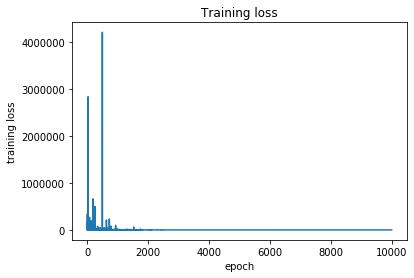

In [20]:
plt.plot(range(n_epochs), hist.history['loss'])
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('training loss')
y_test_pred_ae_list = [ae_model(X_test) for _ in range(n_test)]

### Plot the training and test data

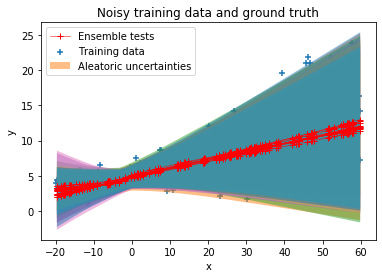

In [21]:
plt.scatter(X_train, y_train, marker='+', label='Training data')
avg_mean = np.zeros_like(X_test)
for i, y in enumerate(y_test_pred_ae_list):
    y_mean = y.mean()
    y_stddev = y.stddev()
    plt.plot(X_test, y_mean, 'r-', marker='+', label='Ensemble tests' if i == 0 else None, linewidth=0.5)
    plt.fill_between(np.squeeze(X_test), 
                     np.squeeze(y_mean + 2 * y_stddev),
                     np.squeeze(y_mean - 2 * y_stddev),
                     alpha=0.5, label='Aleatoric uncertainties' if i == 0 else None)
    avg_mean += y_mean
plt.xlabel('x')
plt.ylabel('y')
plt.title('Noisy training data and ground truth')
plt.legend()

## Uncertainties in CNNs

### Define the loss function of negative log-likelihood (input as logits)

In [22]:
def neg_log_likelihood_with_logits(y_true, y_pred):
    y_pred_dist = tfp.distributions.Categorical(logits=y_pred)
    return -tf.reduce_mean(y_pred_dist.log_prob(tf.argmax(y_true, axis=-1)))

### Load MNIST dataset

Loading MNIST dataset
X_train.shape = (60000, 28, 28, 1)
y_train.shape = (60000, 10)
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


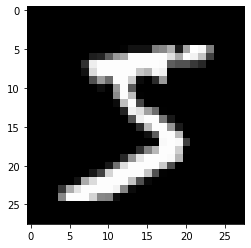

In [23]:
n_class = 10

batch_size = 128
n_epochs = 20
lr = 1e-3

print('Loading MNIST dataset')
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, -1)
n_train = X_train.shape[0]
X_test = np.expand_dims(X_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, n_class)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

plt.imshow(X_train[0, :, :, 0], cmap='gist_gray')

### Define the kernel divergence function that comes with a weight

In [24]:
def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function

    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function

    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn

In [25]:
def add_kl_weight(layer, train_size, w_value=1.0):
    w = layer.add_weight(name=layer.name+'/kl_loss_weight', shape=(),
                         initializer=tf.initializers.constant(w_value), trainable=False)
    layer.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return layer

### Build and train the Bayesian CNN model

In [26]:
def build_bayesian_bcnn_model(input_shape, train_size):
    model_in = Input(shape=input_shape)
    conv_1 = Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_1 = add_kl_weight(conv_1, train_size)
    x = conv_1(model_in)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    conv_2 = Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2,
                                  kernel_divergence_fn=None)
    conv_2 = add_kl_weight(conv_2, train_size)
    x = conv_2(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    dense_1 = DenseFlipout(512, activation='relu',
                           kernel_divergence_fn=None)
    dense_1 = add_kl_weight(dense_1, train_size)
    x = dense_1(x)
    dense_2 = DenseFlipout(10, activation=None,
                           kernel_divergence_fn=None)
    dense_2 = add_kl_weight(dense_2, train_size)
    model_out = dense_2(x)  # logits
    model = Model(model_in, model_out)
    return model
    
bcnn_model = build_bayesian_bcnn_model(X_train.shape[1:], n_train)
bcnn_model.compile(loss=neg_log_likelihood_with_logits, optimizer=Adam(lr), metrics=['acc'])
bcnn_model.summary()
hist = bcnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1)

W0803 00:00:41.258046  7464 deprecation.py:323] From C:\ProgramData\Anaconda3\envs\nightly\lib\site-packages\tensorflow_probability\python\layers\util.py:103: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_flipout (Conv2DFlipou (None, 14, 14, 32)        609       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 7, 7, 64)          36929     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0   

### Quantify the uncertainty in predictions

In [27]:
n_mc_run = 50
med_prob_thres = 0.2

y_pred_logits_list = [bcnn_model.predict(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 9994
Unrecognizable samples: [ 659 1299 3818 6625 8408 9679]
Test accuracy on MNIST (recognizable samples): 0.9874924954972983
Test accuracy on MNIST (unrecognizable samples): 0.16666666666666666


### Define the function that plots the histogram of predicted probabilities across all possible classes

In [28]:
def plot_pred_hist(y_pred, n_class, n_mc_run, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-30, 0, 31)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=(25, 10))
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median prob: {:.2f}) ({})".format(str(idx),
                                                                       np.median(y_pred[idx]),
                                                                       str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

### A recognizable example

True label of the test sample 0: 7


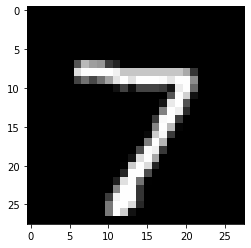

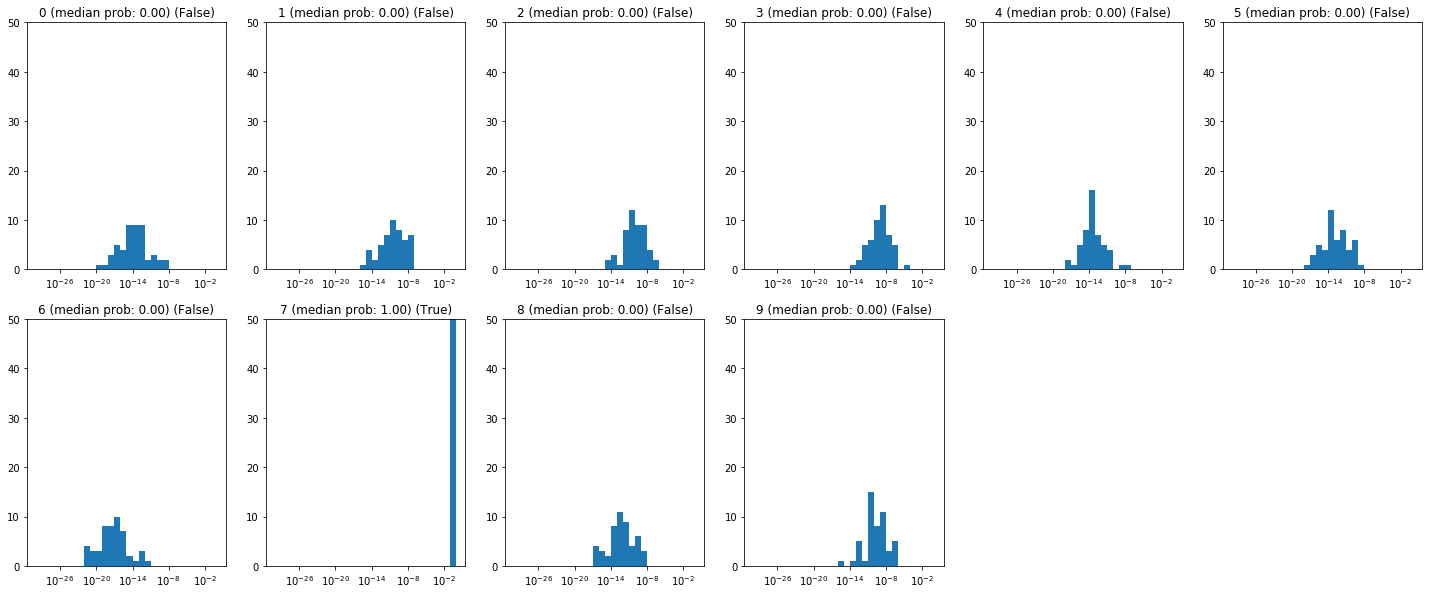

Predicted label of the test sample 0: 7


In [29]:
idx = 0
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

### An unrecognizable example

True label of the test sample 659: 2


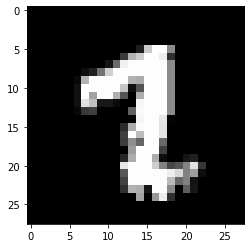

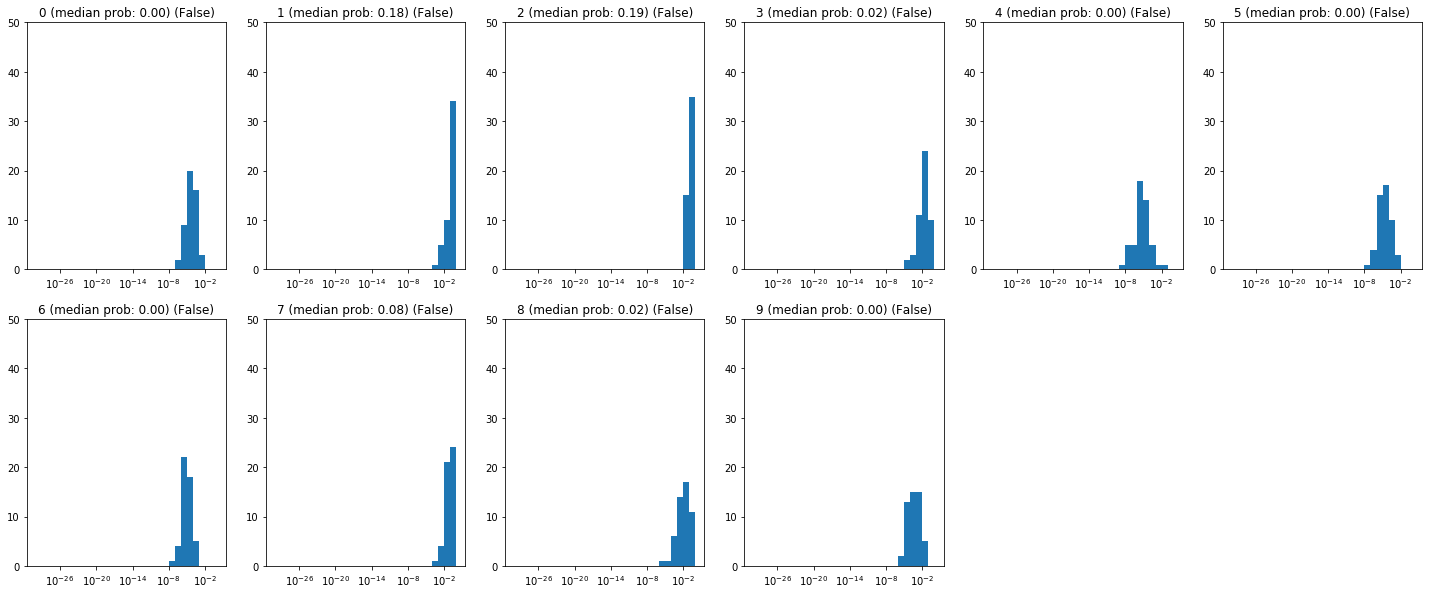

I don't know!


In [30]:
idx = np.where(idx_invalid)[0][0]
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

### Load Fashion-MNIST dataset

In [31]:
print('Loading Fashion-MNIST dataset')
_, (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_test = np.expand_dims(X_test, -1)
y_test = tf.keras.utils.to_categorical(y_test, n_class)

print("X_test.shape =", X_test.shape)
print("y_test.shape =", y_test.shape)

Loading Fashion-MNIST dataset
X_test.shape = (10000, 28, 28, 1)
y_test.shape = (10000, 10)


### Quantify the uncertainty in predictions

In [32]:
y_pred_logits_list = [bcnn_model.predict(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_valid], axis=-1), np.argmax(y_pred[idx_valid], axis=-1))) / len(y_test[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(np.argmax(y_test[idx_invalid], axis=-1), np.argmax(y_pred[idx_invalid], axis=-1))) / len(y_test[idx_invalid]))

Number of recognizable samples: 1511
Unrecognizable samples: [   1    2    3 ... 9997 9998 9999]
Test accuracy on MNIST (recognizable samples): 0.024487094639311716
Test accuracy on MNIST (unrecognizable samples): 0.11638591117917305


### An unrecognizable example

True label of the test sample 1: 2


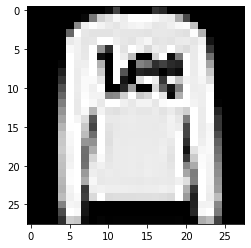

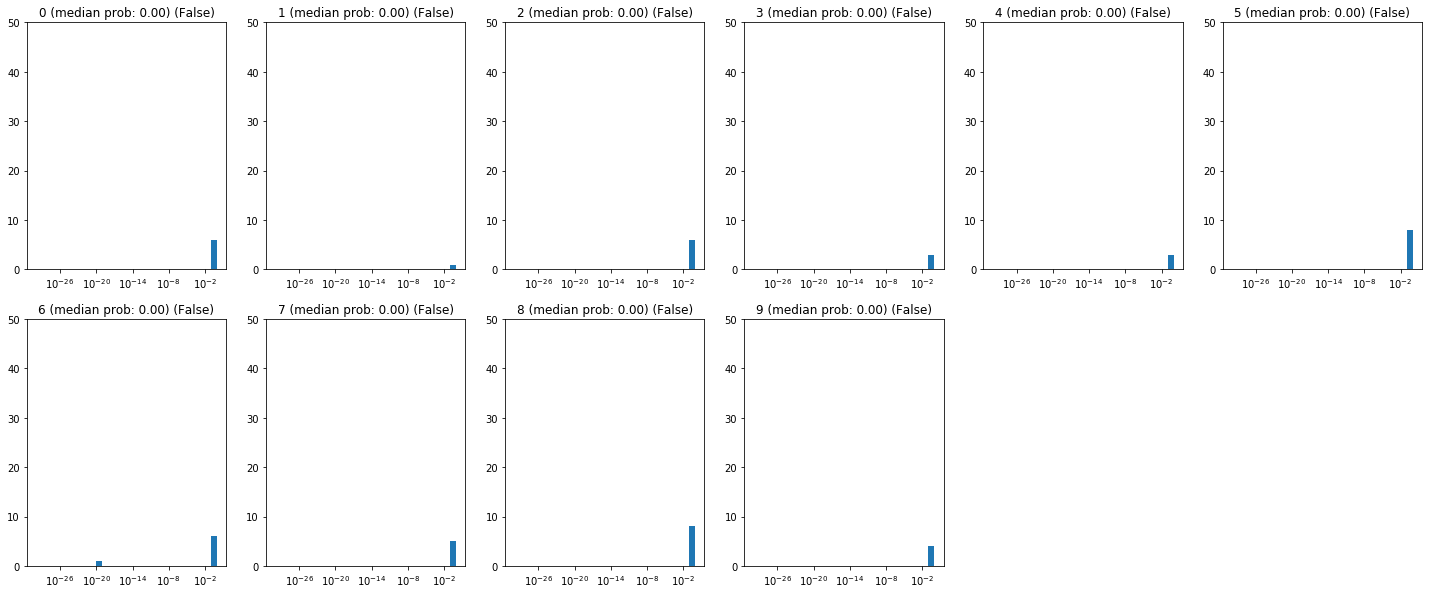

I don't know!


In [33]:
idx = np.where(idx_invalid)[0][0]
plt.imshow(X_test[idx, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(idx, np.argmax(y_test[idx], axis=-1)))

plot_pred_hist(y_pred_prob_all[idx], n_class, n_mc_run, med_prob_thres=med_prob_thres)

if any(y_pred[idx]):
    print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
else:
    print("I don't know!")

## Generate an HTML version of this notebook

In [34]:
!!python -m nbconvert *.ipynb

['[NbConvertApp] Converting notebook tfp_bnn.ipynb to html',
 '[NbConvertApp] Writing 2648470 bytes to tfp_bnn.html']